- V04 (2020/10/26): reordered figures 1 and 2, supplemental figure numbers updated
- V03 (2020/09/24): finalizing Figure 2 (differential expression analysis) with Hiroko's validation of scRNA-seq data and right figure and table numbers
- V02 (2020/08/12): changed interactions from stage_specific and cell_specific to only cell_specific

In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )
source("script/colors.R"    )


In [2]:
suppressPackageStartupMessages(library(shape         ))
suppressPackageStartupMessages(library(wordcloud     ))
suppressPackageStartupMessages(library(Seurat        ))


# Input data

In [3]:
geneinfo_start_genes    = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
geneinfo_start_isoforms = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)

nrow(geneinfo_start_genes   )
nrow(geneinfo_start_isoforms)

nrow(geneinfo_start_genes   [geneinfo_start_genes   $chrom %in% paste("chr", 1:22, sep = ""),])
nrow(geneinfo_start_isoforms[geneinfo_start_isoforms$chrom %in% paste("chr", 1:22, sep = ""),])


[1] 62492

[1] 229835

[1] 59328

[1] 221638

In [4]:
geneinfo_genes    = fread("pipeline/1.2.expression/gene_info.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
geneinfo_isoforms = fread("pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)


In [5]:
covariates  = add_rownames(fread("pipeline/3.1.covariates/covariates.txt", sep = "\t", header = TRUE, data.table = FALSE))
metadata    =              fread("pipeline/3.1.covariates/metadata.txt"  , sep = "\t", header = TRUE, data.table = FALSE)
subinfo     = merge(metadata[, c("run", "subject_id", "subject_name", "study")], covariates[,c("sex", "age", "height", "weight", "bmi", paste("pc", 1:20, sep = ""))], by.x = "run", by.y = "row.names")
subinfo$run = NULL
subinfo     = unique(subinfo)
covariates  = merge(metadata[,c("assay_id", "run", "subject_id", "study", "tissue", "body_site")], covariates, by.x = "run", by.y = "row.names")


## Initial numbers

In [6]:
message(paste("Samples (N)"           , nrow(covariates                                                      ) , sep = " = "))
message(paste("Subjects (N)"          , nrow(subinfo                                                         ) , sep = " = "))
message(paste("Samples (N - iPSCORE)" , nrow(covariates[covariates$study          == "ipscore",             ]) , sep = " = "))
message(paste("Samples (N - GTEx)"    , nrow(covariates[covariates$study          == "gtex"   ,             ]) , sep = " = "))
message(paste("Subjects (N - iPSCORE)", length(unique(covariates[covariates$study == "ipscore", "subject_id"])), sep = " = "))
message(paste("Subjects (N - GTEx)"   , length(unique(covariates[covariates$study == "gtex"   , "subject_id"])), sep = " = "))

invisible(lapply(sort(unique(covariates$body_site)), function(x)
{
    message(paste("Samples (", x, ") = " , nrow(covariates[covariates$body_site == x,]) , sep = ""))
}))

Samples (N) = 966

Subjects (N) = 491

Samples (N - iPSCORE) = 180

Samples (N - GTEx) = 786

Subjects (N - iPSCORE) = 139

Subjects (N - GTEx) = 352

Samples (arteria_aorta) = 227

Samples (arteria_coronary) = 125

Samples (heart_atrium) = 196

Samples (heart_ventricle) = 238

Samples (ipsc_cvpc) = 180



# Functions

In [7]:
values2color = function(x, colorscale = colorpanel(n = 100, low = "#ffeeee", high = cm.color), minval = NA, maxval = NA)
{
    if (is.na(minval) == TRUE){minval = min(x)}
    if (is.na(maxval) == TRUE){maxval = min(x)}
    if (length(x[is.na(x) == TRUE]) > 0){x[is.na(x) == TRUE] = minval}
    if (length(x[x < minval      ]) > 0){x[x < minval      ] = minval}
    if (length(x[x > maxval      ]) > 0){x[x > maxval      ] = maxval}

    y = round((x - minval) * length(colorscale) / (maxval - minval))
    if (length(y[y < 1]) > 0){y[y < 1] = 1}
    
    z = colorscale[y]
    
    return(z)
}


# Figures and Tables
## Table S1-2: subject and sample information
- Table S1: description of subjects included in this study.
- Table S2: description of RNA-seq samples.

In [9]:
load("/frazer01/home/jennifer/projects/cardiac_eqtls/3.Clustering/results/cardips.robj")

#umap_bulk0 = cardips@meta.data
#umap_bulk1 = cardips@meta.data


In [10]:
umap_bulk0          = as.data.frame(cardips@meta.data)
umap_bulk1          = as.data.frame(cardips@reductions$pca @cell.embeddings)
umap_bulk2          = as.data.frame(cardips@reductions$umap@cell.embeddings)
umap_bulk0$run      = rownames(umap_bulk0)
umap_bulk           = merge(umap_bulk0, umap_bulk1, by.x = "run", by.y = "row.names")
umap_bulk           = merge(umap_bulk , umap_bulk2, by.x = "run", by.y = "row.names")
umap_bulk$tissue    = umap_bulk$body_site
umap_bulk$body_site = NULL

for(res in c((0:9) * 0.01, (1:10) * 0.1))
{
    umap_bulk[,paste("res", res, sep = "_")] = as.numeric(umap_bulk[,paste("RNA_snn_res", res, sep = ".")])
}

In [11]:
totrim   = list.files("/frazer01/projects/CARDIPS/analysis/trimread_validation/pipeline", recursive = FALSE)
ipscore1 = fread("input/external/PMID_31668852//Table_S1A.txt", sep = "\t", header = TRUE, data.table = FALSE)
ipscore2 = fread("input/external/PMID_31668852//Table_S1B.txt", sep = "\t", header = TRUE, data.table = FALSE)
udids    = fread("pipeline/1.1.metadata//meta_rna.txt"        , sep = "\t", header = TRUE, data.table = FALSE)

colnames(ipscore1) = tolower(gsub("\\.", "_", colnames(ipscore1)))
colnames(ipscore2) = tolower(gsub(" "  , "_", gsub("\\.", "_", colnames(ipscore2))))

ipscore2 = merge(ipscore2, udids[,c("udid", "run")])

In [12]:
table_s1           = merge(subinfo, ipscore1[,c("subject_uuid", "family_id", "twin_id_dbgap", "twin_type_dbgap", "father_subject_id_dbgap", "mother_subject_id_dbgap")], all.x = TRUE, by.x = "subject_id", by.y = "subject_uuid")

table_s1[is.na(table_s1$twin_id_dbgap          ) == FALSE & table_s1$twin_id_dbgap           == "0", "twin_id_dbgap"          ] = ""
table_s1[is.na(table_s1$twin_type_dbgap        ) == FALSE & table_s1$twin_type_dbgap         == "0", "twin_type_dbgap"        ] = ""
table_s1[is.na(table_s1$father_subject_id_dbgap) == FALSE & table_s1$father_subject_id_dbgap == "0", "father_subject_id_dbgap"] = ""
table_s1[is.na(table_s1$mother_subject_id_dbgap) == FALSE & table_s1$mother_subject_id_dbgap == "0", "mother_subject_id_dbgap"] = ""

table_s1[is.na(table_s1$twin_id_dbgap          ) == TRUE, "twin_id_dbgap"          ] = ""
table_s1[is.na(table_s1$twin_type_dbgap        ) == TRUE, "twin_type_dbgap"        ] = ""
table_s1[is.na(table_s1$father_subject_id_dbgap) == TRUE, "father_subject_id_dbgap"] = ""
table_s1[is.na(table_s1$mother_subject_id_dbgap) == TRUE, "mother_subject_id_dbgap"] = ""

colnames(table_s1) = c("Subject ID", 
                       "Subject name",
                       "Source", 
                       "Sex", 
                       "Age", 
                       "Height", 
                       "Weight", 
                       "BMI",
                       paste("PC", 1:20, sep = ""),
                       "iPSCORE family ID",
                       "iPSCORE twin ID (dbGaP)",
                       "iPSCORE twin type (dbGaP)",
                       "iPSCORE father ID (dbGaP)",
                       "iPSCORE mother ID (dbGaP)"
                      )

table_s1$Sex    = suppressMessages(mapvalues(table_s1$Sex   , from=c(0,1              ), to = c("M", "F"         )))
table_s1$Source = suppressMessages(mapvalues(table_s1$Source, from=c("ipscore", "gtex"), to = c("iPSCORE", "GTEx")))


In [13]:
table_s2 = merge(covariates, ipscore2[,c("run", "udid", "ipsc_ipscore_id", "ipscore_resource", "ipsc_id")], all.x = TRUE)
table_s2 = merge(table_s2, umap_bulk[,c("run", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"), paste("res", c(0, 0.01, 0.2, 0.7), sep = "_"))])

table_s2[is.na(table_s2$udid            ) == TRUE, "udid"            ] = ""
table_s2[is.na(table_s2$ipsc_ipscore_id ) == TRUE, "ipsc_ipscore_id" ] = ""
table_s2[is.na(table_s2$ipscore_resource) == TRUE, "ipscore_resource"] = ""
table_s2[is.na(table_s2$ipsc_id         ) == TRUE, "ipsc_id"         ] = ""

table_s2 = table_s2[,c("study", 
                       "subject_id", 
                       "assay_id", 
                       "run", 
                       "udid", "ipsc_ipscore_id", "ipsc_id",
                       "total_reads", 
                       "uniquely_mapped_reads_to_canonical_chromsomes", 
                       "mitochondrial_reads", 
                       "arteria", "heart", "ipsc_cvpc", 
                       "arteria_aorta", "arteria_coronary", "heart_atrium", "heart_ventricle", 
                       paste("PC", 1:10, sep = "_"), 
                       "UMAP_1", "UMAP_2", 
                       paste("res", c(0, 0.01, 0.2, 0.7), sep = "_"),
                       colnames(covariates)[grep("cibersort", colnames(covariates)) == TRUE],
                       paste("peer"          , 1:285     , sep = "")
                      )]

colnames(table_s2) = c("Source", 
                       "Subject ID", 
                       "Assay ID", 
                       "SRA Run ID", 
                       "iPSCORE UDID", "iPSCORE iPSC ID (dbGaP)", "iPSCORE iPSC ID",
                       "Total number of reads", 
                       "Uniquely mapped reads to chr1-22, X or Y (%)",
                       "Mitochondrial reads (%)", 
                       "Arteria", "Heart", "iPSC-CVPC", 
                       "Aorta", "Coronary artery", "Atrial appendage", "Left ventricle", 
                       paste("PC"  , 1: 10, sep = ""),
                       "UMAP1", "UMAP2",
                       paste("Cluster", c(0, 0.01, 0.2, 0.7), "resolution"),
                       gsub("\\.", " ", gsub("cibersort", "CIBERSORT", gsub("combined", "(collapsed cell types)", gsub("regular\\.", "", colnames(covariates)[grep("cibersort", colnames(covariates)) == TRUE])))),
                       paste("PEER", 1:285, sep = "")
                      )

table_s2$Source = suppressMessages(mapvalues(table_s2$Source, from=c("ipscore", "gtex"), to = c("iPSCORE", "GTEx")))
table_s2$Trimmed = "No"
table_s2[table_s2[, "SRA Run ID"] %in% totrim, "Trimmed"] = "Yes"


In [14]:
fwrite(table_s1, "manuscript/table_s1.csv", sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s2, "manuscript/table_s2.csv", sep = ",", col.names = TRUE, row.names = FALSE)

## Figure S1: Description of the subjects included in this study 
- (A) Sex and (B) age distribution between iPSCORE individuals (blue) and GTEx individuals (pink).
- (C) PCA showing the ancestry of all subjects. Colored circles represent ancestry of individuals from the 1000 Genomes Project. GTEx and iPSCORE individuals are represented by pink and blue “X”, respectively.


In [15]:
kgp              =              add_rownames(fread("input/genotypes/kgp_populations.txt", sep = " " , header = FALSE, data.table = FALSE))
gt_pca           = add_rownames(add_rownames(fread("input/genotypes/genotype_pca.txt"   , sep = " " , header = FALSE, data.table = FALSE)))
colnames(gt_pca) = paste("pc", 1:ncol(gt_pca), sep = "")
colnames(kgp   ) = c("wgs_id", "cluster")
kgp              = kgp[!kgp$wgs_id %in% metadata$wgs_id,]


png 
  2

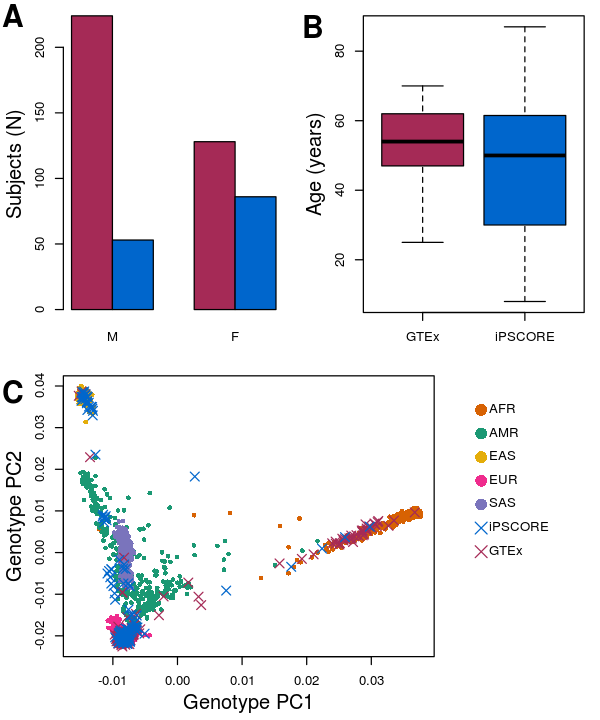

In [16]:
figure_s1a = function()
{
    sexdata           = as.matrix(table(subinfo[,c("sex", "study")]))
    rownames(sexdata) = c("M", "F")
    colnames(sexdata) = c("GTEx", "iPSCORE")
    mycolors          = data.frame(study = colnames(sexdata), color = study2color[c("gtex", "ipscore"), "color"])
    
    par(mar = c(3,4,1,1))
    barplot(t(sexdata), beside = TRUE, col = mycolors$color)
    mtext(text = "Subjects (N)", side = 2, line = 2.5)
    mtext(text = "A"           , side = 2, line = 2.5, at = max(as.numeric(as.matrix(sexdata))), font = 2, cex = 1.5, las = 2)
}

figure_s1b = function()
{
    agedata = merge(subinfo[,c("study", "age")], data.frame(study = c("ipscore", "gtex"), name = c("iPSCORE", "GTEx")))
    
    par(mar = c(3,4,1,1))
    
    mycolors = study2color[c("gtex", "ipscore"), "color"]
    boxplot(age ~ name, data = agedata, col = mycolors, outline = FALSE, ylab = "")
    mtext(text = "Age (years)", side = 2, line = 2.5)
    mtext(text = "B"          , side = 2, line = 2.5, at = max(agedata$age), font = 2, cex = 1.5, las = 2)
}

figure_s1c = function()
{
    subinfo     = merge(subinfo, study2color)
    cluster2col = data.frame(cluster = c("AFR", "AMR", "EAS", "EUR", "SAS"), color = paste(c("#d76203", "#1a9873", "#e4ad0a", "#ef2b8d", "#7a74bc"), "ff", sep = ""))
    pcadata     = merge(cbind(kgp, gt_pca[kgp$wgs_id,]), cluster2col, all.x = TRUE)
    pcadata$pch = 16

    par(mar = c(4,4,1,1))
    plot  (pcadata$pc1, pcadata$pc2, col = pcadata$color, pch = 16, cex = 0.8, xlab = "", ylab = "")
    points(subinfo$pc1, subinfo$pc2, col = subinfo$color, pch =  4, cex = 1.5)
    mtext(text = "Genotype PC1", side = 1, line = 2.5)
    mtext(text = "Genotype PC2", side = 2, line = 2.5)
    mtext(text = "C"           , side = 2, line = 2.5, at = max(subinfo$pc2), font = 2, cex = 1.5, las = 2)
    
    par(mar = c(4,1,1,1))
    plot(1,1, xlim = c(0,1), ylim = c(1,0), type = "n", xlab = "", ylab = "", axes = FALSE)
    
    points(rep(0.1, nrow(cluster2col) + 2), (1:(nrow(cluster2col) + 2)) / (nrow(cluster2col) + 6), pch    = c(rep(16, nrow(cluster2col)), 4, 4), col = c(cluster2col$color, study2color[c("ipscore", "gtex"), "color"]), cex = 2)
    text  (rep(0.1, nrow(cluster2col) + 2), (1:(nrow(cluster2col) + 2)) / (nrow(cluster2col) + 6), labels = c(cluster2col$cluster, "iPSCORE", "GTEx"), pos = 4)

}

figure_s1 = function()
{
    layout(rbind(c(1,1,2,2), 
                 c(3,3,3,4)))
    
    figure_s1a()
    figure_s1b()
    figure_s1c()
}

options(repr.plot.width = 5, repr.plot.height = 6)
figure_s1()

png(filename = "manuscript/figure_S1.png", width = 5, height = 6, units = "in", res = 300)
figure_s1()
dev.off()

In [17]:
message("GTEx enrichment for male individuals: p = ", signif(fisher.test(table(subinfo[,c("sex", "study")]))$p.value, digits = 3), " (Fisher's exact test)", sep = "")

GTEx enrichment for male individuals: p = 3.68e-07 (Fisher's exact test)



# Figure 1: Stage-specific expression differences between cardiac samples

In [18]:
diftiss0    = fread("pipeline/4.1.differential_expression/diffexp.txt"     , sep = "\t", header = TRUE, data.table = FALSE)
difcell0    = fread("pipeline/4.1.differential_expression/diffexp_cell.txt", sep = "\t", header = TRUE, data.table = FALSE)
diftiss     = diftiss0[diftiss0$type == "gene_tpm"   ,]
difcell     = difcell0[difcell0$type == "gene_tpm"   ,]
diftiss_iso = diftiss0[diftiss0$type == "isoform_use",]
difcell_iso = difcell0[difcell0$type == "isoform_use",]


In [19]:
length(unique(diftiss_iso$transcript_id))
length(unique(diftiss_iso$gene_id))
length(unique(diftiss    $gene_id))


[1] 38271

[1] 10686

[1] 20393

In [20]:
difct0    = fread("pipeline/4.1.differential_expression/diffexp_cell_tissue.txt", sep = "\t", header = TRUE, data.table = FALSE)
difct     = difct0[difct0$name == "gene_tpm"   ,]
difct_iso = difct0[difct0$name == "isoform_use",]


In [21]:
difct_all = merge(difct[, c("transcript_id", "tissue", "cell_type", "beta", "se", "pval", "qval")], 
                  difct[, c("transcript_id", "tissue", "cell_type", "beta", "se", "pval", "qval")],
                  by = c("transcript_id", "cell_type"),
                  suffixes = 1:2
                )

In [22]:
difct_all           = difct_all[difct_all$tissue1 != difct_all$tissue2,]
difct_all$cell_type = gsub("cibersort.regular.", "", difct_all$cell_type)

difct_comb = data.frame(tissue1   = c(rep("ipsc_cvpc", 4), rep("ipsc_cvpc", 2), rep("heart"  , 2)),
                        tissue2   = c(rep("heart"    , 4), rep("arteria"  , 2), rep("arteria", 2)),
                        cell_type = c("cardiac_muscle", "smooth_muscle", "endothelial", "endocardial", 
                                      "smooth_muscle", "endocardial",
                                      "smooth_muscle", "endocardial"
                                     )
                       )
difct_comb$y = 1:nrow(difct_comb)
difct_comb[5:nrow(difct_comb), "y"] = difct_comb[5:nrow(difct_comb), "y"] + 1
difct_comb[7:nrow(difct_comb), "y"] = difct_comb[7:nrow(difct_comb), "y"] + 1

difct_comb = cbind(difct_comb, as.data.frame(rbindlist(lapply(1:nrow(difct_comb), function(ii)
{
    tissue1 = difct_comb[ii, "tissue1"  ]
    tissue2 = difct_comb[ii, "tissue2"  ]
    cell    = difct_comb[ii, "cell_type"]
    
    this    = difct_all[difct_all$tissue1 == tissue1 & difct_all$tissue2 == tissue2 & difct_all$cell_type == cell,]
    out     = data.frame(tissue1_n = nrow(this[this$beta1 > 0 & this$qval1 <= 0.05 & this$qval2 > 0.05,]),
                         tissue2_n = nrow(this[this$beta2 > 0 & this$qval2 <= 0.05 & this$qval1 > 0.05,]),
                         both      = nrow(this[this$beta1 > 0 & this$qval1 <= 0.05 & this$beta2 > 0 & difct_cm$qval2 <= 0.05,]))
    
    return(out)
})), stringsAsFactors = FALSE))


ERROR: Error in `[.data.frame`(this, this$beta1 > 0 & this$qval1 <= 0.05 & this$beta2 > : object 'difct_cm' not found


In [ ]:
difct_cm = merge(difct[difct$tissue == "ipsc_cvpc" & difct$cell_type == "cibersort.regular.cardiac_muscle", c("transcript_id", "beta", "se", "pval", "qval")], 
                 difct[difct$tissue == "heart"     & difct$cell_type == "cibersort.regular.cardiac_muscle", c("transcript_id", "beta", "se", "pval", "qval")],
                 by = "transcript_id",
                 suffixes = 1:2
                )

diffct_iso_cm = merge(difct_iso[difct_iso$tissue == "ipsc_cvpc" & difct_iso$cell_type == "cibersort.regular.cardiac_muscle", c("transcript_id", "beta", "se", "pval", "qval")], 
                      difct_iso[difct_iso$tissue == "heart"     & difct_iso$cell_type == "cibersort.regular.cardiac_muscle", c("transcript_id", "beta", "se", "pval", "qval")],
                      by = "transcript_id",
                      suffixes = 1:2
                     )

In [ ]:
message(paste("Expressed genes", length(unique(diftiss$transcript_id)), sep = " = "))
message(paste("Differentially expressed genes (iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$type == "gene_tpm" & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart"  ,]), sep = " = "))
message(paste("Differentially expressed genes (iPSC-CVPC vs. Arteria)", nrow(diftiss[diftiss$qval < 0.05 & diftiss$type == "gene_tpm" & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria",]), sep = " = "))
message(paste("Differentially expressed genes (Heart vs. Arteria)"    , nrow(diftiss[diftiss$qval < 0.05 & diftiss$type == "gene_tpm" & diftiss$tissue1 == "heart"     & diftiss$tissue2 == "arteria",]), sep = " = "))

message(paste("Developmental stage-specific isoforms (log2 ratio > 1; iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & abs(diftiss$log2r) >= 1,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & abs(diftiss$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 3; iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & abs(diftiss$log2r) >= 3,]), sep = " = "))

message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart"   & abs(diftiss$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Arteria)", nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria" & abs(diftiss$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; Heart vs. Arteria)"    , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "heart"     & diftiss$tissue2 == "arteria" & abs(diftiss$log2r) >= 2,]), sep = " = "))

message(paste("Differentially expressed isoforms (iPSC-CVPC vs. Heart)"  , nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart"  ,]), sep = " = "))
message(paste("Differentially expressed isoforms (iPSC-CVPC vs. Arteria)", nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "arteria",]), sep = " = "))
message(paste("Differentially expressed isoforms (Heart vs. Arteria)"    , nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "heart"     & diftiss_iso$tissue2 == "arteria",]), sep = " = "))

message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Heart)"  , nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart"   & abs(diftiss_iso$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Arteria)", nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "arteria" & abs(diftiss_iso$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; Heart vs. Arteria)"    , nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "heart"     & diftiss_iso$tissue2 == "arteria" & abs(diftiss_iso$log2r) >= 2,]), sep = " = "))


In [ ]:
message(paste("Isoforms associated with cardiac muscle only in iPSC-CVPCs" , nrow(diffct_iso_cm[diffct_iso_cm$qval1 <  0.05 & diffct_iso_cm$qval2 >= 0.05 & diffct_iso_cm$beta1 > 0,]), sep = " = "))
message(paste("Isoforms associated with cardiac muscle only in adult heart", nrow(diffct_iso_cm[diffct_iso_cm$qval1 >= 0.05 & diffct_iso_cm$qval2 <  0.05 & diffct_iso_cm$beta2 > 0,]), sep = " = "))
message(paste("Isoforms associated with cardiac muscle in both"            , nrow(diffct_iso_cm[diffct_iso_cm$qval1 <  0.05 & diffct_iso_cm$qval2 <  0.05 & diffct_iso_cm$beta1 > 0 & diffct_iso_cm$beta2 > 0,]), sep = " = "))


In [ ]:
enrtiss = fread("pipeline/4.1.differential_expression/functional_enrichment.tissue.txt", sep = "\t", header = TRUE, data.table = FALSE)
enrcell = fread("pipeline/4.1.differential_expression/functional_enrichment.cell.txt"  , sep = "\t", header = TRUE, data.table = FALSE)


In [ ]:
suppressPackageStartupMessages(library(imager))

In [ ]:
myimage = load.image("manuscript//figure_1a.png")


In [ ]:
figure_1a = function()
{
    par(mar = c(1,2,1,1))
    myimage = load.image("manuscript//figure_1a.png")
    plot(myimage, axes = FALSE)
    mtext(text = "A", side = 2, line = 0, at = 0, font = 2, cex = 1.5, las = 2)
}

volcano_plot_beta = function(x, tissue1 = "", tissue2 = "", panel = "", legend = FALSE)
{
    if((tissue1 != "")&(tissue2 != ""))
    {
        x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2,]
        x$cex = 0.5
        x$color = "#cccccc"
        x[x$diffexp == TRUE & x$beta > 0, "color"] = tissue2color3[tissue1, "color"]
        x[x$diffexp == TRUE & x$beta < 0, "color"] = tissue2color3[tissue2, "color"]
        
        #x[x$diffexp == TRUE & x$log2r_filter == TRUE, "color"] = "#ff0000"
    }else
    {
        x$tissue12 = paste(x$tissue1, "vs.", x$tissue2)
        x          = merge(x, data.frame(tissue12 = sort(unique(x$tissue12)), color = diverging_hcl(n = length(unique(x$tissue12)), palette = "Berlin")))
    }
    
    par(mar = c(4,4,2.5,1))
    plot(x$beta, -log(x$pval), pch = 16, col = x$color, cex = x$cex, xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = "Effect size"                                                     , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                                                , side = 2, line =  2.5)
    mtext(text = panel                                                             , side = 2, line =  2  , at = max(-log(x$pval)) * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2color3[tissue1, "body_site"]                               , side = 3, line =  0  , at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.5)
    mtext(text = tissue2color3[tissue2, "body_site"]                               , side = 3, line =  0  , at = min(x[x$beta < 0 & x$beta > -20, "beta"]) * 0.5)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$beta > 0, ]), sep = " = "), side = 3, line = -1.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.7)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$beta < 0, ]), sep = " = "), side = 3, line = -1.5, at = min(x[x$beta < 0 & x$beta > -20, "beta"]) * 0.8)
}

volcano_plot_log2r = function(x, tissue1 = "", tissue2 = "", panel = "", legend = FALSE)
{
    if((tissue1 != "")&(tissue2 != ""))
    {
        x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2,]
        x$cex = 0.5
    }else
    {
        x$tissue12 = paste(x$tissue1, "vs.", x$tissue2)
        x          = merge(x, data.frame(tissue12 = sort(unique(x$tissue12)), color = diverging_hcl(n = length(unique(x$tissue12)), palette = "Berlin")))
    }

    x$filter = 0
    x[x$diffexp == TRUE, "filter"] = 1
    #x[x$diffexp == TRUE & abs(x$log2r) >= 1, "filter"] = 2
    x[x$diffexp == TRUE & abs(x$log2r) >= 2, "filter"] = 4
    #x[x$diffexp == TRUE & abs(x$log2r) >= 3, "filter"] = 4
    
    filter2color = data.frame(filter = 0:4, filter_label = c("N.S.", "FDR < 0.05", paste("log2r >", 1:3)), color = c("#888888", sequential_hcl(4, palette = "plasma", rev = TRUE)))
    
    x = merge(x, filter2color, by = "filter")
    
    par(mar = c(4,4,2.5,1))
    plot(x$log2r, -log(x$pval), pch = 16, col = x$color, cex = x$cex, xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = paste("log2(", tissue1, " / ", tissue2, ")", sep = "")              , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                                                  , side = 2, line =  2.5)
    mtext(text = panel                                                               , side = 2, line =  2  , at = max(-log(x$pval)) * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2color3[tissue1, "body_site"]                                 , side = 3, line =  0  , at = max(x[x$log2r > 0 & x$log2r <  20, "log2r"]) * 0.5)
    mtext(text = tissue2color3[tissue2, "body_site"]                                 , side = 3, line =  0  , at = min(x[x$log2r < 0 & x$log2r > -20, "log2r"]) * 0.5)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r >  2, ]), sep = " = "), side = 3, line = -1.5, at = max(x[x$log2r > 0 & x$log2r <  20, "log2r"]) * 0.7)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r < -2, ]), sep = " = "), side = 3, line = -1.5, at = min(x[x$log2r < 0 & x$log2r > -20, "log2r"]) * 0.8)
}

volcano_plot_cell = function(x, tissue, panel = "")
{
    alldata = x
    ylims   = max(-log10(x$pval))
    x       = x[x$cell_type == tissue,]
    xlims   = range(x[x$beta >= -20 & x$beta <= 20, "beta"])
    mycol   = cell2color_regular[cell2color_regular$cell_type == gsub("cibersort\\.", "", tissue), "color"]
    x$color = "#dddddd"
    #x$pch   = 16
    x$cex   = 0.4
    #x$bg    = NA
    
    x[x$qval <= 0.05 & x$beta > 0 &  x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "color"] = "#999999"
    x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "color"] = mycol 
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "pch"  ] = 21 
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "cex"  ] =  0.3 
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "bg"   ] = mycol 
    
    if(tissue != "cibersort.regular.cardiac_muscle"){x = rbind(x[x$color == "#dddddd",], x[x$color == "#999999",], x[x$color == mycol    ,])}
    if(tissue == "cibersort.regular.cardiac_muscle"){x = rbind(x[x$color == "#dddddd",], x[x$color == mycol    ,], x[x$color == "#999999",])}
    
    par(mar = c(4,4,2.5,1))
    #plot(x$beta, -log(x$pval), col = x$color, cex = x$cex, pch = x$pch, bg = x$bg, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    #plot(x$beta, -log(x$pval), col = x$color, cex = 0.3, pch = 16, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    plot(x$beta, -log(x$pval), col = x$color, cex = x$cex, pch = 16, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = "Effect size"                                                     , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                                                , side = 2, line =  2.5)
    mtext(text = gsub("_", " ", gsub("cibersort.regular\\.", "", tissue))          , side = 3, line =  0.5)
    mtext(text = panel                                                             , side = 2, line =  2  , at = ylims * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = paste("N", nrow(x[x$qval <= 0.05 & x$beta > 0, ]), sep = " = ")   , side = 1, line = -1.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.7)
}

figure_1i = function()
{
    this = diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart",]
    
    this$filter = 0
    this[this$diffexp == TRUE, "filter"] = 1
    #this[this$diffexp == TRUE & abs(this$log2r) >= 1, "filter"] = 2
    this[this$diffexp == TRUE & abs(this$log2r) >= 2, "filter"] = 4
    #this[this$diffexp == TRUE & abs(this$log2r) >= 3, "filter"] = 4
    
    filter2color = data.frame(filter = 0:4, filter_label = c("N.S.", "FDR < 0.05", paste("log2r >", 1:3)), color = c("#888888", sequential_hcl(4, palette = "plasma", rev = TRUE)))
    
    this = merge(this, filter2color)
    this = this[order(this$filter, decreasing = FALSE),]
    
    this$color = paste(this$color, "33", sep = "")
    
    par(mar = c(4,4,2.5,1))
    plot(this$tissue1_exp, this$tissue2_exp, col = this$color, xlim = c(0,100), ylim = c(-5,110), pch = 16, xlab = "", ylab = "")
    
    toplot = this[this$gene_name %in% c("TNNT2", "SCN5A", "TTN", "ABLIM1", "NME7", "CRB2") & this$diffexp == TRUE & (this$tissue1_exp > 5 | this$tissue2_exp > 5),]
    toplot$pos = 3
    #toplot[toplot$log2r_filter == TRUE & toplot$beta < 0, "pos"] = 4
    toplot[toplot$tissue2_exp < 5 & toplot$gene_name != "NME7", "pos"] = 1

    points(toplot$tissue1_exp, toplot$tissue2_exp, bg     = toplot$color, pch = 21, cex = 1.5)
    text  (toplot$tissue1_exp, toplot$tissue2_exp, labels = toplot$gene_name, pos = toplot$pos, font = 3)
    
    mtext(text = "I", side = 2, line = 2, at = 110 * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = "Mean isoform use (%, adult heart)", side = 2, line = 2.5)
    mtext(text = "Mean isoform use (%, iPSC-CVPC)"  , side = 1, line = 2.5)
    
    abline(h = 100)
    
    filter2color = filter2color[filter2color$filter %in% c(0,1,4),]

    points(x = c(0, 40, 40)    , y = c(110, 110, 105), bg     = filter2color$color       , pch = 21, cex = 2)
    text  (x = c(0, 40, 40) + 2, y = c(110, 110, 105), labels = c("N.S.", "Stage-associated", "Stage-specific"), pos = 4)
}

figure_umap = function(umap, x, colordata, panel = "", legend = FALSE)
{
    umap        = merge(umap, colordata)
    umap     $x = umap     [,x]
    
    par(mar = c(4,4,1,1))
    plot(umap$UMAP_1, umap$UMAP_2, pch = 16, col = umap$color, cex = 1.5, xlab = "", ylab = "", axes = FALSE)
    
    axis(1, labels = NA)
    axis(2, labels = NA)
    
    mtext(text = "UMAP 1", side = 1, line = 1)
    mtext(text = "UMAP 2", side = 2, line = 1)
    mtext(text = panel   , side = 2, line = 2, at = max(umap$UMAP_2), font = 2, cex = 1.5, las = 2)
    
    if(legend == TRUE)
    {
        plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata) + 0.5, 0.5), xlab = "", ylab = "", axes = FALSE)
        
        points(x = rep(0, nrow(colordata)), y = 1:nrow(colordata), pch = 16, cex = 2, col = colordata$color)
        text  (x = rep(0, nrow(colordata)), y = 1:nrow(colordata), labels = colordata$body_site, pos = 4, cex = 1.25)
    }else
    {
        totext = aggregate(list(umap1 = umap$UMAP_1, umap2 = umap$UMAP_2), by = list(x = umap$x, color_points = umap$color), FUN = mean)
        totext$color = "#ffffff"
        if(x == "res_0"   ){totext[totext$x == 1, "color"] = "#000000"}
        if(x == "res_0.01"){totext[totext$x == 1, "color"] = "#000000"}
        if(nrow(totext[totext$color_points == "#FFC0CB",]) > 0){totext[totext$color_points == "#FFC0CB", "color"] = "#000000"}
        text(x = totext$umap1, y = totext$umap2, labels = totext$x, cex = 1.5, col = totext$color)
    }
}

figure_s4 = function()
{
    layout(rbind(1:2))
    
    volcano_plot_log2r(diftiss, "ipsc_cvpc", "arteria", "A")
    volcano_plot_log2r(diftiss, "heart"    , "arteria", "B")
}

figure_s5_panel = function(gene_id, panel = "")
{
    expdata                = data.frame(assay_id = colnames(gene_tpm), exp = as.numeric(gene_tpm[gene_id,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata[,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    tissue2y               = tissue2color3[tissue2color3$tissue != "adult",]
    tissue2y               = tissue2y[order(tissue2y$tissue),]
    tissue2y$y             = 1:nrow(tissue2y)
    this                   = expdata
    this                   = merge(this, tissue2y[,c("tissue", "y", "color")])
    this$y                 = jitter(this$y - 0.5, factor = 1)

    par(mar = c(4,7.5,1.5,1))
    plot(1,1, type = "n", xlim = range(this$exp), ylim = c(0, max(tissue2y$y)), axes = FALSE, xlab = "", ylab = "")

    axis(1)

    boxplot(exp ~ tissue, data = this, horizontal = TRUE, add = TRUE, at = tissue2y$y - 0.5, col = paste(tissue2y$color, "33", sep = ""), outline = FALSE, axes = FALSE)
    mtext(text = panel             , side = 2, line = 5, at = max(tissue2y$y) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2y$body_site, side = 2, line = 0, at = tissue2y$y - 0.5, las = 2)
    mtext(text = "TPM"             , side = 1, line = 2.5)
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 3, line = 0, font = 3, cex = 1.2)
    points(this$exp, this$y, col = this$color, pch = 16)

}

figure_s6x = function(gene_id, panel = "")
{
    tissue2color3       = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    tissue2color3$order = 1:nrow(tissue2color3)
    
    isos            = geneinfo_isoforms[ geneinfo_isoforms$gene_id == gene_id, "transcript_id"]
    expdata         = as.data.frame(t(as.matrix(isof_use[isos,])))
    expdata$run     = rownames(expdata)
    expdata         = merge(expdata, metadata[,c("run", "study", "tissue")])
    expdata         = merge(expdata, tissue2color3[,c("tissue", "order", "color")])
    iso2order       = data.frame(transcript_id = isos, mean = colMeans(expdata[,isos]))
    iso2order       = iso2order[order(iso2order$mean, decreasing = TRUE),]
    iso2order$order = 1:nrow(iso2order)
    iso2order$color = qualitative_hcl(n = nrow(iso2order), palette = "Set 2")
    expdata         = expdata[order(expdata$order, -expdata[,iso2order[1, "transcript_id"]], -expdata[,iso2order[1, "transcript_id"]]),]
    exons           = merge(iso2order, exons)
    xlims           = c(min(exons$start), max(exons$end))
        
    par(mar = c(4,16,1,1))
    plot(1,1, type = "n", xlim = xlims, ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
    axis(1, at = pretty(xlims), labels = pretty(xlims) * 1e-6)
    
    mtext(text = paste(unique(exons$chrom), "(Mb)"), side = 1, line =  2.5)
    mtext(text = iso2order$transcript_id           , side = 2, line =  0  , las = 2, at = iso2order$order - 0.5)
    mtext(text = panel                             , side = 2, line = 14  , las = 2, at = 0, font = 2, cex = 1.5)
    
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 2, line = 14, font = 3, cex = 1.2)
    
    for(ii in 1:nrow(iso2order))
    {
        toplot = exons[exons$transcript_id == iso2order[ii, "transcript_id"],]
        y0     = iso2order[ii, "order"]
        mycol  = iso2order[ii, "color"]
        
        rect    (xleft =     toplot$start , xright =     toplot$end , ybottom = y0 - 0.8, ytop = y0 - 0.2, col = mycol, border = mycol)
        segments(x0    = min(toplot$start), x1     = max(toplot$end), y0      = y0 - 0.5,                  col = mycol)
    }
    
    toplot     = aggregate(. ~ tissue + order + color, data = expdata[,c("tissue", "order", "color", iso2order$transcript_id)], FUN = mean)
    
    par(mar = c(4,1,1,1))
    plot(1,1, type = "n", xlim = c(0, max(as.matrix(toplot[,iso2order$transcript_id]))), ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    mtext(text = "Isoform use (%)", side = 1, line = 2.5)
    
    for(ii in 1:nrow(iso2order))
    {
        toplot     = expdata
        toplot$exp = toplot[,iso2order[ii, "transcript_id"]]
        toplot     = aggregate(exp ~ tissue + order + color, data = toplot, FUN = mean)
        
        rect(xleft = 0, xright = toplot$exp, ybottom = ii - 1 + (toplot$order - 1) / max(toplot$order + 1), ytop = ii - 1 + (toplot$order) / max(toplot$order + 1), col = toplot$color)
    }
    
    toplot = merge(iso2order, diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart", c("transcript_id", "log2r", "diffexp")])
    
    if(nrow(toplot[toplot$log2r >  5,]) > 0){toplot[toplot$log2r >  5, "log2r"] =  5}
    if(nrow(toplot[toplot$log2r < -5,]) > 0){toplot[toplot$log2r < -5, "log2r"] = -5}
    
    par(mar = c(4,1,1,1))
    plot(1,1, type = "n", xlim = c(min(toplot$log2r) - 1, max(toplot$log2r) + 1), ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    mtext(text = "log2(iPSC-CVPC / Heart)", side = 1, line = 2.5)
    
    
    rect  (xleft = 0, xright = toplot$log2r, ybottom = toplot$order - 0.8, ytop = toplot$order - 0.2, col = toplot$color)
    
    tostar = toplot[toplot$diffexp == TRUE,]
    tostar$x = tostar$log2r + 0.75
    
    if(nrow(tostar[tostar$log2r < 0,]) > 0){tostar[tostar$log2r < 0, "x"] = tostar[tostar$log2r < 0, "log2r"] - 0.75}
    
    points(x = tostar$x, y = tostar$order - 0.5, pch = 8, cex = 2, col = "#ff0000")
    
    abline(v = -3:3, lty = "dotted")
    abline(v = 0)
    
}

figure_s6_cell = function(x, cell, panel = "")
{
    tissue2color3          = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    expdata                = data.frame(assay_id = colnames(isof_use), exp = as.numeric(isof_use[x,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    this                   = expdata
    this                   = merge(this, tissue2color3[,c("tissue", "color")])
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    mtext(text = panel                                                          , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis                                                      , side = 1, line = 2.5)
    mtext(text = "TPM"                                                          , side = 2, line = 2.5)
    mtext(text = paste(x, " (", geneinfo_isoforms[ geneinfo_isoforms$transcript_id == x, "gene_name"], ")", sep = ""), side = 3, line = 0  , font = 3, cex = 1.2)
    
    for(tissue in tissue2color3[tissue2color3$tissue != "adult", "tissue"])
    {
        tox = this[this$tissue == tissue,]
        abline(lm(exp ~ cell, data = tox), col = tissue2color3[tissue2color3$tissue == tissue, "color"], lty = "dashed")
    }
}

figure_s5 = function()
{
    layout(matrix(c(1:6), nrow = 3, byrow = TRUE))
    figure_s4_panel(geneinfo_genes[ geneinfo_genes$gene_name == "CELF1" , "gene_id"], "A")
    figure_s4_panel(geneinfo_genes[ geneinfo_genes$gene_name == "MBNL1" , "gene_id"], "B")
    figure_s4_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBFOX1", "gene_id"], "C")
    figure_s4_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBFOX2", "gene_id"], "D")
    figure_s4_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBM24" , "gene_id"], "E")
    figure_s4_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBM5"  , "gene_id"], "F")

    #colordata = tissue2color3[c("ipsc_cvpc" , "heart", "arteria"),]
    #plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata) + 0.5, 0.5), xlab = "", ylab = "", axes = FALSE)
    #
    #points(x = rep(0   , nrow(colordata)), y = 1:nrow(colordata), cex = 3  , pch = 16, col = colordata$color)
    #text  (x = rep(0.05, nrow(colordata)), y = 1:nrow(colordata), cex = 1.5, labels = colordata$body_site, pos = 4)

}

figure_1 = function()
{
    mylayout = rbind(c(     rep( 1, 6    ), rep(2,3)),
                     c(     rep( 1, 6    ), rep(3,3)),
                     c(sort(rep( 5: 7, 2)), rep(4,3)),
                     c(sort(rep( 8:10, 2)), rep(4,3)),
                     c(     rep(11, 5    ), sort(rep(12:13, 2)))
                    )
    layout(mylayout)
    
    figure_1a()
    
    volcano_plot_log2r(diftiss, "ipsc_cvpc", "heart", "G")
    
    figure_s4_panel(geneinfo_genes[ geneinfo_genes$gene_name == "HNRNPL", "gene_id"], "H")
    
    figure_1i()
    
    
    tissue2color$tissue = gsub("heart_", "", gsub("arteria_", "", tissue2color$tissue))
    
    figure_umap(umap_bulk, "tissue", tissue2color, "B", TRUE)
    
    
    mycol     = paste("res", 0, sep = "_")
    colordata = data.frame(res       = sort(unique(umap_bulk[,mycol])), 
                           body_site = sort(unique(umap_bulk[,mycol])), 
                           color     = c("#A52A56", "#0066CC")
                          )
    
    colnames(colordata)[[1]] = mycol
    
    colordata_0 = colordata
    
    mycol     = paste("res", 0.01, sep = "_")
    colordata = data.frame(res       = sort(unique(umap_bulk[,mycol])), 
                           body_site = sort(unique(umap_bulk[,mycol])), 
                           color     = c("#A52A56", "#2E8B57", "#0066CC")
                          )
    
    colnames(colordata)[[1]] = mycol
    
    colordata_0.01 = colordata
    
    mycol     = paste("res", 0.2, sep = "_")
    colordata = data.frame(res       = sort(unique(umap_bulk[,mycol])), 
                           body_site = sort(unique(umap_bulk[,mycol])), 
                           color     = c("#8B1C62", "#8B636C", "#FF34B3", "#0066CC", "#FFC0CB")
                          )
    
    colnames(colordata)[[1]] = mycol
    
    colordata_0.2 = colordata
    
    mycol     = paste("res", 0.7, sep = "_")
    colordata = data.frame(res       = sort(unique(umap_bulk[,mycol])), 
                           body_site = sort(unique(umap_bulk[,mycol])), 
                           color     = c("#8B636C", "#FF34B3", "#FFC0CB", "#0066CC", "#8B1C62", "#9F79EE", "#00bbff")
                          )
    
    colnames(colordata)[[1]] = mycol
    
    colordata_0.7 = colordata
    
    figure_umap(umap_bulk, paste("res", 0   , sep = "_"), colordata_0   , "C", FALSE)
    figure_umap(umap_bulk, paste("res", 0.01, sep = "_"), colordata_0.01, "D", FALSE)
    figure_umap(umap_bulk, paste("res", 0.2 , sep = "_"), colordata_0.2 , "E", FALSE)
    figure_umap(umap_bulk, paste("res", 0.7 , sep = "_"), colordata_0.7 , "F", FALSE)
    
    out = list(colordata_0, colordata_0.01, colordata_0.2, colordata_0.7)
    names(out) = paste("Resolution", c(0, 0.01, 0.2, 0.7))
    
    saveRDS(out, "manuscript/figure1_colors.rds")
    
    figure_s5x(geneinfo_genes[ geneinfo_genes$gene_name == "CRB2"  , "gene_id"], "J")
}

png(filename = "manuscript/figure_1.png", width = 10, height = 11, units = "in", res = 300)
figure_1()
dev.off()

options(repr.plot.width = 10, repr.plot.height = 11)
figure_1()

## Figure S4, S5

In [ ]:
png(filename = "manuscript/figure_S4.png", width = 8.5, height = 4, units = "in", res = 300)
figure_s4()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 4)
figure_s3()

In [ ]:
png(filename = "manuscript/figure_S5.png", width = 8.5, height = 7, units = "in", res = 300)
figure_s5()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 7)
figure_s5()

## Figure S6: examples of isoform differential expression (boxplots)

In [ ]:
exons = fread("/frazer01/reference/private/Gencode.v34lift37/exon_info.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [ ]:
fwrite(geneinfo_isoforms[ geneinfo_isoforms$transcript_id %in% diffct_iso_cm[diffct_iso_cm$qval1 <  0.05 & diffct_iso_cm$qval2 >= 0.05 & diffct_iso_cm$beta1 > 0, "transcript_id"], c("gene_name", "transcript_id")], "fetal.txt", sep = "\t", col.names = TRUE)
fwrite(geneinfo_isoforms[ geneinfo_isoforms$transcript_id %in% diffct_iso_cm[diffct_iso_cm$qval1 >= 0.05 & diffct_iso_cm$qval2 <  0.05 & diffct_iso_cm$beta2 > 0, "transcript_id"], c("gene_name", "transcript_id")], "adult.txt", sep = "\t", col.names = TRUE)

In [ ]:
figure_s6 = function()
{
    myline = c(1,1,2,3)
    layout(matrix(myline + sort(rep(0:6, 4)) * 3, nrow = 7, byrow = TRUE))
    figure_s6x(geneinfo_genes[ geneinfo_genes$gene_name == "SCN5A" , "gene_id"], "A")
    figure_s6x(geneinfo_genes[ geneinfo_genes$gene_name == "TNNT2" , "gene_id"], "B")
    figure_s6x(geneinfo_genes[ geneinfo_genes$gene_name == "ABLIM1", "gene_id"], "C")
    figure_s6x(geneinfo_genes[ geneinfo_genes$gene_name == "TTN"   , "gene_id"], "D")
    figure_s6x(geneinfo_genes[ geneinfo_genes$gene_name == "HNRNPL", "gene_id"], "E")
    figure_s6x(geneinfo_genes[ geneinfo_genes$gene_name == "RBM5"  , "gene_id"], "F")
    figure_s6x(geneinfo_genes[ geneinfo_genes$gene_name == "NME7"  , "gene_id"], "G")
}

png(filename = "manuscript/figure_S6.png", width = 8.5, height = 15, units = "in", res = 300)
figure_s6()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 15)
figure_s6()


### RBPs

In [ ]:
rbps = fread(cmd = 'grep ">" /frazer01/home/matteo/convert_rbp_motifs_to_homer/homer_input/motifs.all_updated.homer.txt | cut -f 2', sep = "\t", header = FALSE, data.table = FALSE)[,1]
rbps = unique(c(unlist(lapply(rbps[grepl("^RBPmap", rbps) == TRUE], function(x){unlist(strsplit(x, "_"))[[2]]})), rbps[grepl("^RBPmap", rbps) == FALSE]))

msig = fread(cmd = 'grep -P "^GO_RNA_BINDING\t" /frazer01/reference/public/msigdb.v7.1/c5.mf.v7.1.symbols.gmt', sep = "\t", header = FALSE, data.table = FALSE)
msig = as.character(msig[,3:ncol(msig)])

message(paste("RBPs", length(rbps), sep = " = "))
message(paste("RBPs in GO_RNA_BINDING = ", length(intersect(rbps, msig)), " (", signif(length(intersect(rbps, msig)) / length(rbps) * 100, digits = 3), "%)", sep = ""))

length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & diftiss$diffexp == TRUE & diftiss$log2r >=  2, "gene_name"])])
length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & diftiss$diffexp == TRUE & diftiss$log2r <= -2, "gene_name"])])

length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & diftiss$diffexp == TRUE & diftiss$log2r >=  0, "gene_name"])])
length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & diftiss$diffexp == TRUE & diftiss$log2r <= -0, "gene_name"])])

length(msig)

In [ ]:

length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r >=  2, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r <= -2, "gene_name"])])

length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r >=  0, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r <= -0, "gene_name"])])

length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & abs(diftiss_iso$log2r) >=  4, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & abs(diftiss_iso$log2r) >=  2, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE, "gene_name"])])

rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & abs(diftiss_iso$log2r) >=  2, "gene_name"])]

length(unique(diftiss_iso[diftiss_iso$gene_name %in% rbps & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r >=  2, "transcript_id"]))
length(unique(diftiss_iso[diftiss_iso$gene_name %in% rbps & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r <= -2, "transcript_id"]))


## Table S3,4,5,8,9: differential expression analysis and functional enrichment
- S3: Differential expression (tissue)
- S4: Functional enrichment (tissue)
- S5: differential expression (isoform - tissue)
- S8: Differential expression (cell)
- S9: Functional enrichment (cell)



In [ ]:
table_s3           = diftiss[,c("gene_id", "gene_name", "gene_type", "tissue1", "tissue2", "beta", "se", "pval", "qval", "log2r", "diffexp")]
colnames(table_s3) = c("Gene ID", "Gene name", "Gene type", "Tissue 1", "Tissue 2", "Effect size (beta)", "Standard error of beta", "P-value", "FDR (Bonferroni)", "log2 ratio", "Differentially expressed")

table_s4           = enrtiss[enrtiss$type == "gene_tpm", c("tissue1", "tissue2", "gs_source", "gene_set", "url", "ngenes", "ttest_estimate_in", "ttest_estimate_out", "ttest_pval", "ttest_fdr")]
table_s4$tissue1   = suppressMessages(mapvalues(table_s4$tissue1, from=c("ipsc_cvpc", "heart", "arteria"), to=c("iPSC-CVPC", "Heart", "Arteria")))
colnames(table_s4) = c("Tissue 1", "Tissue 2", "Gene set collection", "Gene set", "Gene set URL", "Genes in gene set (N)", "Mean effect size in", "Mean effect size out", "P-value", "FDR (Benjamini-Hochberg)")

fwrite(table_s3 , "manuscript/table_s3.csv" , sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s4 , "manuscript/table_s4.csv" , sep = ",", col.names = TRUE, row.names = FALSE)


In [ ]:
table_s5           = diftiss_iso[,c("transcript_id", "gene_id", "gene_name", "gene_type", "tissue1", "tissue2", "beta", "se", "pval", "qval", "tissue1_exp", "tissue2_exp", "log2r", "diffexp", "log2r_filter")]
colnames(table_s5) = c("Transcript ID", "Gene ID", "Gene name", "Gene type", "Tissue 1", "Tissue 2", "Effect size (beta)", "Standard error of beta", "P-value", "FDR (Bonferroni)", "Mean Use in Tissue1 (%)", "Mean Use in Tissue2 (%)", "log2 ratio", "Differentially expressed", "Stage-specific")

fwrite(table_s5, "manuscript/table_s5.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [ ]:
table_s8 = difcell[,c("gene_id", "gene_name", "gene_type", "cell_type", "beta", "se", "pval", "qval")]

table_s8$diffexp    = FALSE
table_s8$specific   = FALSE

table_s8[table_s8$qval <= 0.05 & table_s8$beta > 0, "diffexp"] = TRUE

table_s8 = as.data.frame(rbindlist(lapply(sort(unique(table_s8$cell_type)), function(x)
{
    this = table_s8[table_s8$cell_type == x,]
    
    this[this$diffexp == TRUE & !this$gene_id %in% table_s8[table_s8$cell_type != x & table_s8$diffexp == TRUE, "gene_id"], "specific"  ] = TRUE

    return(this)
})), stringsAsFactors = FALSE)

colnames(table_s8) = c("Gene ID", "Gene name", "Gene type", "Cell type", "Effect size (beta)", "Standard error of beta", "P-value", "FDR (Bonferroni)", "Associated with cell type", "Cell type-specific")

fwrite(table_s8 , "manuscript/table_s8.csv" , sep = ",", col.names = TRUE, row.names = FALSE)


In [ ]:
table_s9           = enrcell[enrcell$type == "gene_tpm", c("cell_type"         , "gs_source", "gene_set", "url", "ngenes", "ttest_estimate_in", "ttest_estimate_out", "ttest_pval", "ttest_fdr")]
table_s9$tissue2   = suppressMessages(mapvalues(table_s9$tissue2, from=c("ipsc_cvpc", "heart", "arteria"), to=c("iPSC-CVPC", "Heart", "Arteria")))
colnames(table_s9) = c("Cell type", "Gene set collection", "Gene set", "Gene set URL", "Genes in gene set (N)", "Mean effect size in", "Mean effect size out", "P-value", "FDR (Benjamini-Hochberg)")

fwrite(table_s9, "manuscript/table_s9.csv" , sep = ",", col.names = TRUE, row.names = FALSE)


In [ ]:
table(table_s8[,c("Cell type", "Cell type-specific"       )])
table(table_s8[,c("Cell type", "Associated with cell type")])


# Figure 2: Influence of cell composition on differential expression


In [ ]:
scdata      =              fread("pipeline/2.1.scrna_seq/tabula_muris.heart.metadata.txt"            , sep = "\t", header = TRUE, data.table = FALSE)
expcell     = add_rownames(fread("pipeline/2.1.scrna_seq/signature_gene_average_expression.heart.txt", sep = "\t", header = TRUE, data.table = FALSE))
cibersort   = add_rownames(fread("pipeline/2.1.scrna_seq/cibersort_results.txt"                      , sep = "\t", header = TRUE, data.table = FALSE))
cell2tissue = add_rownames(fread("pipeline/3.1.covariates/cell2tissue.txt"                           , sep = "\t", header = TRUE, data.table = FALSE))
markers     =              fread("pipeline/2.1.scrna_seq/markers.heart.txt"                          , sep = "\t", header = TRUE, data.table = FALSE)


In [ ]:
message(paste("Cells in Tabula muris heart"     , nrow(scdata)                                                    , sep = " = "))
message(paste("Cell types in Tabula muris heart", length(unique(scdata$cell_ontology_class))                      , sep = " = "))
message(paste("Cell types in Tabula muris heart", paste(sort(unique(scdata$cell_ontology_class)), collapse = ", "), sep = " = "))
message(paste("Marker genes"                    , length(unique(markers$gene))                                    , sep = " = "))


In [ ]:
cell2color_regular            = data.frame(cell_type = colnames(cibersort)[grepl("regular", colnames(cibersort)) == TRUE], color = c("#bb0000", "#00bb00", "#ff8888", "#FF34B3", "#0000bb", "#cdcd00", "#3D3D3D", "#8B814C")) 
cell2color_combined           = cell2color_regular
cell2color_combined$cell_type = gsub("regular", "combined", cell2color_combined$cell_type)
cell2color_combined           = cell2color_combined[cell2color_combined$cell_type %in% colnames(cibersort),]


## Table S6-7: data to get CIBERSORT
- Table S6: Marker genes
- Table S7: Expression matrix input to CIBERSORT


In [ ]:
table_s6           = markers[,c("gene", "cluster", "pct.1", "pct.2", "avg_logFC", "p_val", "p_val_adj")]
table_s6$pct.1     = table_s6$pct.1 * 100
table_s6$pct.2     = table_s6$pct.2 * 100
table_s6$cluster   = gsub("leukocyte", "immune", gsub(" ", "_", gsub(" cell", "", table_s6$cluster)))
colnames(table_s6) = c("Gene name", "Cell type", "Cells in cell type with expression (%)", "Cells not in cell type with expression (%)", "log2 fold change vs. all other cells", "p-value (Wilcoxon test)", "FDR-corrected p-value")

In [ ]:
table_s7               = expcell
colnames(table_s7)     = gsub("leukocyte", "immune", gsub("_cell", "", colnames(table_s7)))
table_s7[,"Gene name"] = rownames(table_s7)
table_s7               = table_s7[,c("Gene name", gsub("regular\\.", "", cell2color_regular$cell_type))]
colnames(table_s7)     = gsub("_", " ", colnames(table_s7))


In [ ]:
fwrite(table_s6, "manuscript/table_s6.csv", sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s7, "manuscript/table_s7.csv", sep = ",", col.names = TRUE, row.names = FALSE)


## Figure S7: Cell composition of adult and iPSC-CVPC cardiac samples
- (A) UMAP plot from Tabula muris
- (B) cell type distributions for collapsed cell types

In [ ]:
figure_s7a = function(metadata, umap1, umap2, colordata, is_cat = TRUE, add_labels = FALSE, panel = "")
{
    if(is_cat == TRUE)
    {
        metadata = merge(metadata, colordata)
        name     = colnames(colordata)[[1]]
    }
    
    
    par(mar = c(4,4,1,1))
    plot(metadata[,umap1], metadata[,umap2], pch = 16, cex = 1, col = metadata$color, xlab = "", ylab = "")
    mtext(text = "UMAP 1", side = 1, line = 2.5)
    mtext(text = "UMAP 2", side = 2, line = 2.5)
    mtext(text = panel    , side = 2, line = 2  , at = max(metadata[, umap2]), font = 2, cex = 1.5, las = 2)
    
    if(add_labels == TRUE)
    {
        totext = aggregate(list(x = metadata[,umap1], y = metadata[,umap2]), by = list(cell = metadata$cell_type), FUN = mean)
        
        text(x = totext$x, y = totext$y, labels = gsub("_", " ", totext$cell), cex = 1.5, pos = 3)
    }
}

figure_s7 = function()
{
    #layout(rbind(c(1,1,2),
    #             c(1,1,2),
    #             rep(3,3)
    #            ))
    
    cell2color = cell2color_regular
    cell2color$cell_type = gsub("regular\\.", "", cell2color$cell_type)
    scdata$cell_type     = gsub("leukocyte", "immune", gsub(" ", "_", gsub(" cell", "", scdata$cell_ontology_class)))
    figure_s6a(scdata, "umap1", "umap2", cell2color, TRUE, TRUE, "")
    #plot.new()
    #figure_1b(cibersort[, cell2color_combined$cell_type], metadata, cell2color_combined, "B") 
}

png(filename = "manuscript/figure_S7.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s7()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s7()


## Figure S9: Cell type-specific and cell type-associated genes

In [ ]:
figure_s9 = function()
{
    layout(matrix(1:9, nrow = 3, byrow = TRUE))
    
    invisible(lapply(sort(unique(difcell$cell_type)), function(cell){volcano_plot_cell(difcell, cell)}))
}

png(filename = "manuscript/figure_S9.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s9()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s9()

## Figure S10: scRNA-seq validation
- Input (to Hiroko)

In [ ]:
tosc     = sort(unique(difcell[difcell$cell_type == "cibersort.regular.cardiac_muscle" & difcell$qval <= 0.05 & difcell$beta > 0, "transcript_id"]))
tosc_n   = sort(unique(difcell[difcell$cell_type == "cibersort.regular.cardiac_muscle" & difcell$qval <= 0.05 & difcell$beta < 0, "transcript_id"]))
expgenes = sort(unique(difcell[, "transcript_id"]))

writeLines(tosc    , con = "to_scrna_validation.cardiac_muscle_genes.txt", sep = "\n")
writeLines(tosc_n  , con = "to_scrna_validation.cardiac_muscle_genes_negative_control.txt", sep = "\n")
writeLines(expgenes, con = "to_scrna_validation.expressed_genes.txt"     , sep = "\n")

In [ ]:
tosc_beta = difcell[difcell$cell_type == "cibersort.regular.cardiac_muscle", ]

fwrite(tosc_beta, "to_scrna_validation.cardiac_muscle_genes.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

- From Hiroko

In [ ]:
tocomb = fread("/frazer01/projects/CARDIPS/analysis/scRNAseq_validation/diff_genes/combine.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [ ]:
load("/frazer01/projects/CARDIPS/analysis/scRNAseq_validation/diff_genes/Robj/avg.1.R")
load("/frazer01/projects/CARDIPS/analysis/scRNAseq_validation/diff_genes/Robj/avg.2.R")

exp_cm = avg.1
exp_ep = avg.2

exp_sc = data.frame(gene_name = names(exp_cm), cm = as.numeric(exp_cm), epdc = as.numeric(exp_ep))
exp_sc$log2r = log2((exp(1))^(exp_sc$cm - exp_sc$epdc))

tovalid = merge(tosc_beta, exp_sc[,c("gene_name", "cm", "epdc", "log2r")])
tovalid = merge(tovalid  , tocomb[,c("gene_id", "cardiac_muscle_genes", "CM")])

tovalid$stage = "ipsc_cvpc"

tovalid$cell_type = "CM"
tovalid$fr1       = tovalid$cm
tovalid$fr2       = tovalid$epdc


In [ ]:
valid_adult       = fread("pipeline/4.1.differential_expression/scrna_validation.adult.txt"                 , sep = "\t", header = TRUE, data.table = FALSE)
valid_adult_scrna = fread("pipeline/4.1.differential_expression/scrna_validation.adult_umap_coordinates.txt", sep = "\t", header = TRUE, data.table = FALSE)
valid_cvpc_scrna  = fread("pipeline/4.1.differential_expression/scrna_validation.cvpc_umap_coordinates.txt" , sep = "\t", header = TRUE, data.table = FALSE)
valid_stage       = fread("pipeline/4.1.differential_expression/scrna_validation.stage.txt"                 , sep = "\t", header = TRUE, data.table = FALSE)

valid_adult$log2r = valid_adult$avg_logFC
valid_adult       = valid_adult[is.na(valid_adult$beta) == FALSE & is.na(valid_adult$log2r) == FALSE,]
valid_adult$stage = "adult"
valid_adult$fr1   = valid_adult$f.1
valid_adult$fr2   = valid_adult$f.2

validation = rbind(valid_adult[,c("cell_type", "stage", "beta", "fr1", "fr2", "log2r")], 
                   tovalid    [,c("cell_type", "stage", "beta", "fr1", "fr2", "log2r")]
                  )



validation$cell_type = gsub("cibersort.regular\\.", "", validation$cell_type)
validation$cell_type = gsub("regular\\."          , "", validation$cell_type)

valid_stage$fr1   = valid_stage$f.cvpc
valid_stage$fr2   = valid_stage$f.adult
valid_stage$log2r = - valid_stage$log2FC
valid_stage$beta  = valid_stage$tiss1_beta - valid_stage$tiss2_beta
valid_stage$stage = "adult"


In [ ]:
message(paste("iPSC-CVPC cells"  , nrow(valid_cvpc_scrna ), sep = " = "))
message(paste("Adult heart cells", nrow(valid_adult_scrna), sep = " = "))


In [ ]:
#message(paste("Correlation between beta (bulk) and log2r (scRNA) = ", 
#              signif(cor.test(tovalid$beta, tovalid$log2r)$estimate, digits = 3), 
#              " (p = ", 
#              signif(cor.test(tovalid$beta, tovalid$log2r)$p.value, digits = 3), 
#              ")",
#              sep = ""
#             ))

In [ ]:
figure_scrna = function(metadata, umap1, umap2, colordata, is_cat = TRUE, add_labels = FALSE, panel = "")
{
    metadata$cell_type = metadata$annot
    if(is_cat == TRUE)
    {
        metadata = merge(metadata, colordata)
        
        if(nrow(colordata[colordata$cell_type == "other cell types",]) > 0)
        {
            metadata = rbind(metadata[metadata$cell_type == "other cell types",],
                             metadata[metadata$cell_type != "other cell types",]
                            )
        }
        if(nrow(colordata[colordata$cell_type == "EPDC",]) > 0)
        {
            metadata = rbind(metadata[metadata$cell_type == "EPDC",],
                             metadata[metadata$cell_type == "CM"  ,]
                            )
        }
        
        name     = colnames(colordata)[[1]]
    }
    
    
    par(mar = c(4,4,1,1))
    plot(metadata[,umap1], metadata[,umap2], pch = 16, cex = 1, col = metadata$color, xlab = "", ylab = "")
    mtext(text = "UMAP 1", side = 1, line = 2.5)
    mtext(text = "UMAP 2", side = 2, line = 2.5)
    mtext(text = panel    , side = 2, line = 2  , at = max(metadata[, umap2]), font = 2, cex = 1.5, las = 2)
    
    if(add_labels == TRUE)
    {
        metadata = metadata[metadata$cell_type != "other cell types",]
        totext = aggregate(list(x = metadata[,umap1], y = metadata[,umap2]), by = list(cell = metadata$cell_type), FUN = mean)
        totext$color = "#000000"
        
        #totext[!totext$cell %in% c("EPDC", "fibroblast", "smooth_muscle"), "color"] = "#ffffff"
        
        text(x = totext$x, y = totext$y, labels = gsub("_", " ", totext$cell), cex = 1.5, pos = 3, col = totext$color, font = 2)
    }
}

figure_sm8_old = function()
{
    tovalid$color = "#aaaaaa"
    tovalid[tovalid$CM == "Y" & tovalid$cardiac_muscle_genes == "Y", "color"] = "#4876FF"
    tovalid[tovalid$CM == "Y" & tovalid$cardiac_muscle_genes == "N", "color"] = "#FF83FA"
    tovalid[tovalid$CM == "N" & tovalid$cardiac_muscle_genes == "Y", "color"] = cell2color_regular[cell2color_regular$cell_type == "regular.cardiac_muscle", "color"]
    
    par(mar = c(4,4,1,1))
    plot(tovalid$beta, tovalid$log2r, pch = 16, col = tovalid$color, xlab = "", ylab = "")
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
    abline(lm(log2r ~ beta, data = tovalid), lty = "dashed", lwd = 2, col = "#0000ff")
    
    mtext(text = "Effect size (bulk RNA-seq)"  , side = 1, line =  2.5)
    mtext(text = "log2 (CM / EPDC) (scRNA-seq)", side = 2, line =  2.5)
}

figure_validation = function(validation, metadata, stage, cell_type, frx = 0.1, write_cells = FALSE, panel = "")
{
    #validation = validation[validation$stag == stage & validation$cell_type == cell_type & (validation$fr1 >= 0.1 & validation$fr2 >= 0.1),]
    validation       = validation[validation$stage == stage & validation$cell_type == cell_type & is.na(validation$log2r) == FALSE & is.infinite(validation$log2r) == FALSE,]
    validation$color = "#0000ff"
    validation[validation$fr1 >= frx | validation$fr2 >= frx, "color"] = "#ff0000"
    
    validation          = rbind(validation[validation$color == "#0000ff",], validation[validation$color == "#ff0000",])
    validation_filtered = validation[validation$fr1 >= frx | validation$fr2 >= frx,]
    
    par(mar = c(4,4,1,1))
    plot(validation$beta, validation$log2r, col = validation$color, pch = 16, xlab = "", ylab = "")
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
    abline(lm(log2r ~ beta, data = validation         ), lty = "dashed", lwd = 2, col = "#0000aa")
    if(frx < 1){abline(lm(log2r ~ beta, data = validation_filtered), lty = "dashed", lwd = 2, col = "#aa0000")}
    
    mylabs1 = paste(paste("Genes"                                         , nrow(validation                                                       ), sep = " = "),
                    paste("R"                                             , signif(cor     (validation$beta, validation$log2r)        , digits = 3), sep = " = "),
                    paste("p"                                             , signif(cor.test(validation$beta, validation$log2r)$p.value, digits = 3), sep = " = "),
                    paste("Cells"                                         , nrow(metadata[metadata$ident.cell == cell_type,]                      ), sep = " = "),
                    sep = "\n"
                   )
    
    if(frx < 1){mylabs2 = paste(paste(paste("Expressed (>", frx * 100, "%)", sep = ""), nrow(validation_filtered                                                                ), sep = " = "),
                          paste("R"                                             , signif(cor     (validation_filtered$beta, validation_filtered$log2r)        , digits = 3), sep = " = "),
                          paste("p"                                             , signif(cor.test(validation_filtered$beta, validation_filtered$log2r)$p.value, digits = 3), sep = " = "),
                          paste("Cells"                                         , nrow(metadata[metadata$ident.cell == cell_type,]                                        ), sep = " = "),
                          sep = "\n"
                         )}
    
    
    
    if(write_cells == FALSE)
    {
        mylabs1 = paste(paste("Genes"                                         , nrow(validation                                                       ), sep = " = "),
                        paste("R"                                             , signif(cor     (validation$beta, validation$log2r)        , digits = 3), sep = " = "),
                        paste("p"                                             , signif(cor.test(validation$beta, validation$log2r)$p.value, digits = 3), sep = " = "),
                        sep = "\n"
                       )
        if(frx < 1){mylabs2 = paste(paste(paste("Expressed (>", frx * 100, "%)", sep = ""), nrow(validation_filtered                                                                ), sep = " = "),
                              paste("R"                                             , signif(cor     (validation_filtered$beta, validation_filtered$log2r)        , digits = 3), sep = " = "),
                              paste("p"                                             , signif(cor.test(validation_filtered$beta, validation_filtered$log2r)$p.value, digits = 3), sep = " = "),
                              sep = "\n"
                             )}
    }
    
    
    mtext(text = "Effect size (bulk RNA-seq)", side = 1, line =  2.5)
    mtext(text = "log2 ratio (scRNA-seq)"    , side = 2, line =  2.5)
    text (x      = min(validation$beta) , y = max(validation$log2r) * 0.65, labels = mylabs1, cex = 1.2, pos = 4, col = "#0000aa")
    if(frx < 1){text (x      = max(validation$beta) , y = min(validation$log2r) * 0.85, labels = mylabs2, cex = 1.2, pos = 2, col = "#aa0000")}
    mtext(text = panel    , side = 2, line = 2  , at = max(validation$log2r), font = 2, cex = 1.5, las = 2)
    
}

figure_s10 = function()
{
    #layout(rbind(c(1,1,1,2,2,2), c(3,3,4,4,5,5), c(6,6,7,7,8,8)))
    layout(matrix(1:8, nrow = 4, byrow = TRUE))
    
    cell2color = cell2color_regular
    cell2color$cell_type = gsub("regular\\.", "", cell2color$cell_type)
    cell2color           = rbind(data.frame(cell_type = "other cell types", color = "#cccccc"), cell2color)
    
    cvpc2color = cell2color[cell2color$cell_type %in% c("cardiac_muscle", "fibroblast"),]
    cvpc2color = data.frame(cell_type = c("CM", "EPDC"), color = c(cell2color[cell2color$cell_type == "cardiac_muscle", "color"],
                                                                   cell2color[cell2color$cell_type == "fibroblast"    , "color"]))
    
    valid_cvpc_scrna$annot = valid_cvpc_scrna$ident.cell
    
    figure_scrna(valid_cvpc_scrna , "umap1", "umap2", cvpc2color, TRUE, TRUE, "A")
    figure_scrna(valid_adult_scrna, "umap1", "umap2", cell2color, TRUE, TRUE, "B")
    
    figure_validation(validation , valid_cvpc_scrna , "ipsc_cvpc", "CM"            , 0.5, TRUE , "C")
    figure_validation(validation , valid_adult_scrna, "adult"    , "cardiac_muscle", 0.1, TRUE , "D")
    figure_validation(validation , valid_adult_scrna, "adult"    , "fibroblast"    , 0.1, TRUE , "E")
    figure_validation(validation , valid_adult_scrna, "adult"    , "endothelial"   , 0.1, TRUE , "F")
    figure_validation(validation , valid_adult_scrna, "adult"    , "smooth_muscle" , 0.1, TRUE , "G")
    figure_validation(valid_stage, valid_adult_scrna, "adult"    , "cardiac_muscle", 1  , FALSE, "H")
}

png(filename = "manuscript/figure_S10.png", width = 11, height = 15, units = "in", res = 300)
figure_s10()
dev.off()

options(repr.plot.width = 11, repr.plot.height = 15)
figure_s10()



## Figure S11: Examples of genes associated with cell type proportions only at one developmental stage


In [ ]:
figure_s11_cell = function(gene_id, cell, panel = "", legend = FALSE)
{
    tissue2color3          = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    expdata                = data.frame(assay_id = colnames(gene_tpm), exp = as.numeric(gene_tpm[gene_id,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    this                   = expdata
    this                   = merge(this, tissue2color3[,c("tissue", "color")])
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    mtext(text = panel                                                          , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis                                                      , side = 1, line = 2.5)
    mtext(text = "TPM"                                                          , side = 2, line = 2.5)
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 3, line = 0  , font = 3, cex = 1.2)
    
    for(tissue in tissue2color3[tissue2color3$tissue != "adult", "tissue"])
    {
        tox = this[this$tissue == tissue,]
        abline(lm(exp ~ cell, data = tox), col = tissue2color3[tissue2color3$tissue == tissue, "color"], lty = "dashed")
    }
    
    if(legend == TRUE)
    {
        colordata = tissue2color3[c("ipsc_cvpc" , "heart"),]
        points(x = rep(0, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 3  , pch = 16, col = colordata$color)
        text  (x = rep(2, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 1.5, labels = colordata$body_site, pos = 4)
    }
}

figure_s11_cell2 = function(x, cell, panel = "", legend = FALSE)
{
    tissue2color3          = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    expdata                = data.frame(assay_id = colnames(isof_use), exp = as.numeric(isof_use[x,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    this                   = expdata
    this                   = merge(this, tissue2color3[,c("tissue", "color")])
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    mtext(text = panel                                                          , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis                                                      , side = 1, line = 2.5)
    mtext(text = "TPM"                                                          , side = 2, line = 2.5)
    mtext(text = paste(x, " (", geneinfo_isoforms[ geneinfo_isoforms$transcript_id == x, "gene_name"], ")", sep = ""), side = 3, line = 0  , font = 3, cex = 1.2)
    
    for(tissue in tissue2color3[tissue2color3$tissue != "adult", "tissue"])
    {
        tox = this[this$tissue == tissue,]
        abline(lm(exp ~ cell, data = tox), col = tissue2color3[tissue2color3$tissue == tissue, "color"], lty = "dashed")
    }
    
    if(legend == TRUE)
    {
        colordata = tissue2color3[c("ipsc_cvpc" , "heart"),]
        points(x = rep(0, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 3  , pch = 16, col = colordata$color)
        text  (x = rep(2, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 1.5, labels = colordata$body_site, pos = 4)
    }
}

figure_s11 = function()
{
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    figure_s11_cell2("ENST00000392955.7_4" , "cibersort.regular.cardiac_muscle", "A", TRUE)
    figure_s11_cell2("ENST00000651023.1_2" , "cibersort.regular.cardiac_muscle", "B", TRUE)
    figure_s11_cell2("ENST00000333535.9_4" , "cibersort.regular.cardiac_muscle", "C", TRUE)
    figure_s11_cell2("ENST00000367318.10_5", "cibersort.regular.cardiac_muscle", "D", TRUE)
    figure_s11_cell2("ENST00000460472.6_4" , "cibersort.regular.cardiac_muscle", "E", TRUE)

}

png(filename = "manuscript/figure_S11.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s11()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s11()

In [ ]:

figure_2a = function(cibersort, metadata, cluster2color, panel = "")
{
    #cibersort               = cibersort[,order(colnames(cibersort))]
    indata                  = merge(metadata[, c("run", "assay_id", "body_site")], cibersort, by.x = "run", by.y = "row.names")
    rownames(cluster2color) = cluster2color$cell_type
    cluster2color           = cluster2color[colnames(cibersort),]

    ipsc_cvpc = indata[indata$body_site == "ipsc_cvpc"       ,]
    aorta     = indata[indata$body_site == "arteria_aorta"   ,]
    coronary  = indata[indata$body_site == "arteria_coronary",]
    atrium    = indata[indata$body_site == "heart_atrium"    ,]
    ventricle = indata[indata$body_site == "heart_ventricle" ,]
    
    ipsc_cvpc = ipsc_cvpc[order(ipsc_cvpc[,colnames(cibersort)[[1]]], ipsc_cvpc[,colnames(cibersort)[[2]]], decreasing = TRUE),]
    atrium    = atrium   [order(atrium   [,colnames(cibersort)[[1]]], atrium   [,colnames(cibersort)[[2]]], decreasing = TRUE),]
    ventricle = ventricle[order(ventricle[,colnames(cibersort)[[1]]], ventricle[,colnames(cibersort)[[2]]], decreasing = TRUE),]
    aorta     = aorta    [order(aorta    [,colnames(cibersort)[[1]]], aorta    [,colnames(cibersort)[[2]]], decreasing = TRUE),]
    coronary  = coronary [order(coronary [,colnames(cibersort)[[1]]], coronary [,colnames(cibersort)[[2]]], decreasing = TRUE),]
    
    par(mar = c(2,4,1,1))
    #plot(1,1, type = "n", xlim = c(0, nrow(indata) + 50), ylim = c(0,100), xlab = "", ylab = "", axes = FALSE)
    #axis(2)
    
    my_spaces        = c(rep(0, nrow(ipsc_cvpc)), 10, rep(0, nrow(atrium) -1 ), 10, rep(0, nrow(ventricle) -1 ), 10, rep(0, nrow(aorta) -1 ), 10, rep(0, nrow(coronary) -1 ))
    toplot           = rbind(ipsc_cvpc, atrium, ventricle, aorta, coronary)
    rownames(toplot) = NULL
    cluster2cell     = cluster2color
    #cluster2cell = data.frame(cluster = colnames(cibersort), color = qualitative_hcl(palette = "Set 2", n = ncol(cibersort)))
    
    barplot(t(as.matrix(toplot[, cluster2cell[,1]])) * 100, col = cluster2cell$color, width = 1, border = NA, space = my_spaces, xlim = c(0, nrow(toplot) + sum(my_spaces) + 250), ylim = c(-20,100), axes = FALSE)
    axis(2, at = (0:5) * 20)
    
    mtext(text = "Cell types (%)", side = 2, line = 2.5)
    mtext(text = panel           , side = 2, line = 2  , at = 100, font = 2, cex = 1.5, las = 2)

    mtext(text = "iPSC-CVPCs"    , side = 1, line = -2.5, at = nrow(ipsc_cvpc) / 2)
    mtext(text = "Atrium"        , side = 1, line = -2.5, at = nrow(atrium   ) / 2 + 10 + nrow(ipsc_cvpc))
    mtext(text = "Ventricle"     , side = 1, line = -2.5, at = nrow(ventricle) / 2 + 20 + nrow(ipsc_cvpc) + nrow(atrium))
    mtext(text = "Aorta"         , side = 1, line = -2.5, at = nrow(aorta    ) / 2 + 30 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle))
    mtext(text = "Coronary"      , side = 1, line = -2.5, at = nrow(coronary ) / 2 + 40 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle) + nrow(aorta))

    mtext(text = "Fetal-like"    , side = 1, line =  0  , at =  nrow(ipsc_cvpc) / 2)
    mtext(text = "Adult heart"   , side = 1, line =  0  , at = (nrow(atrium   ) + nrow(ventricle) + 10)/ 2 + 10 + nrow(ipsc_cvpc))
    mtext(text = "Adult arteria" , side = 1, line =  0  , at = (nrow(aorta    ) + nrow(coronary ) + 10)/ 2 + 30 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle))
    
    toseg = c(0, nrow(ipsc_cvpc), 10 + nrow(ipsc_cvpc), 20 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle), 30 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle), 40 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle) + nrow(aorta    ) + nrow(coronary ))
    segments(x0 = toseg, y0 = -10, y1 = -15)
    
    segments(x0 = toseg[c(1,3,5)], x1 = toseg[c(2,4,6)], y0 = -15)
    
    cluster2cell$y = 100 - seq(from = 10, to = 100, by = min(10, 100 / (1+nrow(cluster2cell))))[1:nrow(cluster2cell)]
    
    points(x = rep(nrow(toplot) + 70, nrow(cluster2cell)), y = cluster2cell$y, cex = 2  , pch = 22, bg = cluster2cell$color)
    text  (x = rep(nrow(toplot) + 70, nrow(cluster2cell)), y = cluster2cell$y, cex = 1.2, labels = gsub("regular.", "", gsub("combined.", "", gsub("_", " ", cluster2cell[,1]))), pos = 4)
}


figure_2b = function()
{
    difct_cm$color = "#dddddd"
    difct_cm[difct_cm$beta1 > 0 & difct_cm$qval1 <= 0.05 & difct_cm$qval2 > 0.05, "color"] = tissue2color3["ipsc_cvpc", "color"]
    difct_cm[difct_cm$beta2 > 0 & difct_cm$qval2 <= 0.05 & difct_cm$qval1 > 0.05, "color"] = tissue2color3["heart"    , "color"]
    difct_cm[difct_cm$beta1 > 0 & difct_cm$qval1 <= 0.05 & difct_cm$beta2 > 0 & difct_cm$qval2 <= 0.05, "color"] = "#aaffaa"
    
    par(mar = c(4,4,2.5,1))
    plot(difct_cm$beta1, difct_cm$beta2, pch = 16, col = difct_cm$color, xlab = "", ylab = "")
    mtext(text = "Cardiac muscle (gene expression)", side = 3, line = 0  )
    mtext(text = "Effect size (adult)"             , side = 2, line = 2.5)
    mtext(text = "Effect size (iPSC-CVPC)"         , side = 1, line = 2.5)
    mtext(text = "B"                               , side = 2, line = 2  , at = max(difct_cm$beta2) * 1.1, font = 2, cex = 1.5, las = 2)

    points(x = rep(-6, 4), y = 6 - (1:4) * 0.8, pch = 16, col = c(tissue2color3["ipsc_cvpc", "color"], tissue2color3["heart", "color"], "#aaffaa", "#dddddd"), cex = 2)
    text  (x = rep(-6, 4), y = 6 - (1:4) * 0.8, labels = c("iPSC-CVPC-specific", "Heart-specific", "Cell type-associated", "N.S."), pos = 4)
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
}

figure_2c = function()
{
    difct_comb$n = rowSums(difct_comb[, c("both", "tissue1_n", "tissue2_n")])
    
    par(mar = c(4,12,2,1))
    plot(1,1, type = "n", xlim = c(0, max(difct_comb$n)), ylim = c(max(difct_comb$y), 0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    rect(xleft = 0                                            , xright = difct_comb$both                                           , ybottom = difct_comb$y -1, ytop = difct_comb$y, col = "#aaffaa")
    rect(xleft = difct_comb$both                              , xright = rowSums(difct_comb[, c("both", "tissue1_n"             )]), ybottom = difct_comb$y -1, ytop = difct_comb$y, col = tissue2color3[difct_comb$tissue1, "color"])
    rect(xleft = rowSums(difct_comb[, c("both", "tissue1_n")]), xright = rowSums(difct_comb[, c("both", "tissue1_n", "tissue2_n")]), ybottom = difct_comb$y -1, ytop = difct_comb$y, col = tissue2color3[difct_comb$tissue2, "color"])
    
    mtext(text = gsub("_", " ", difct_comb$cell_type)                              , side = 2, line = 0, at = difct_comb$y - 0.5, cex = 0.8, las = 2)
    mtext(text = c("CVPC\nvs.\nHeart", "CVPC\nvs.\nArteria", "Heart\nvs.\nArteria"), side = 2, line = 8, at = c(2, 6, 9)        , cex = 0.8)
    
    points(x = rep(3500, 4), y = 1:4 + 4, bg = c(tissue2color3[c("ipsc_cvpc" , "heart", "arteria"), "color"], "#aaffaa"), pch = 21, cex = 2)
    text  (x = rep(3550, 4), y = 1:4 + 4, labels = c("iPSC-CVPC", "Heart", "Arteria", "Cell type-associated"), pos = 4)
    
    mtext(text = "C"        , side = 2, line = 10  , at = -0.5, font = 2, cex = 1.5, las = 2)
    mtext(text = "Genes (N)", side = 1, line =  2.5)
}


figure_2f = function()
{
    diffct_iso_cm$color = "#dddddd"
    diffct_iso_cm[diffct_iso_cm$beta1 > 0 & diffct_iso_cm$qval1 <= 0.05 & diffct_iso_cm$qval2 > 0.05, "color"] = tissue2color3["ipsc_cvpc", "color"]
    diffct_iso_cm[diffct_iso_cm$beta2 > 0 & diffct_iso_cm$qval2 <= 0.05 & diffct_iso_cm$qval1 > 0.05, "color"] = tissue2color3["heart"    , "color"]
    diffct_iso_cm[diffct_iso_cm$beta1 > 0 & diffct_iso_cm$qval1 <= 0.05 & diffct_iso_cm$beta2 > 0 & diffct_iso_cm$qval2 <= 0.05, "color"] = "#aaffaa"
    
    par(mar = c(4,4,2.5,1))
    plot(diffct_iso_cm$beta1, diffct_iso_cm$beta2, pch = 16, col = diffct_iso_cm$color, xlab = "", ylab = "")
    mtext(text = "Cardiac muscle (isoform use %)", side = 3, line = 0  )
    mtext(text = "Effect size (adult)"           , side = 2, line = 2.5)
    mtext(text = "Effect size (iPSC-CVPC)"       , side = 1, line = 2.5)
    mtext(text = "F"                             , side = 2, line = 2.5, at = max(diffct_iso_cm$beta2) * 1.1, font = 2, cex = 1.5, las = 2)

    points(x = rep(-6, 4), y = 4 -(1:4) * 0.5, pch = 16, col = c(tissue2color3["ipsc_cvpc", "color"], tissue2color3["heart", "color"], "#aaffaa", "#dddddd"), cex = 2)
    text  (x = rep(-6, 4), y = 4 -(1:4) * 0.5, labels = c("iPSC-CVPC-specific", "Heart-specific", "Cell type-associated", "N.S."), pos = 4)
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
}

figure_2 = function()
{
    layout(rbind(rep(1,2),
                 2:3,
                 4:5,
                 6:7
                ))
    
    figure_2a(cibersort[, cell2color_regular $cell_type], metadata, cell2color_regular, "A")
    figure_2b()
    figure_2c()
    figure_s11_cell (geneinfo_genes[ geneinfo_genes$gene_name == "MEF2C"  , "gene_id"], "cibersort.regular.cardiac_muscle", "D", TRUE)
    figure_s11_cell (geneinfo_genes[ geneinfo_genes$gene_name == "TNNI3"  , "gene_id"], "cibersort.regular.cardiac_muscle", "E", TRUE)
    figure_2f()
    figure_s11_cell2("ENST00000423572.7_4" , "cibersort.regular.cardiac_muscle", "G", TRUE)

}

png(filename = "manuscript/figure_2.png", width = 8.5, height = 11, units = "in", res = 300)
figure_2()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_2()



In [ ]:
message(paste("Correlation between effect size (cardiac muscle % vs. expression) between iPSC-CVPCs and adult heart: R = ", 
              signif(cor(difct_cm$beta1, difct_cm$beta2), digits = 3),
              ", p = ",
              signif(cor.test(difct_cm$beta1, difct_cm$beta2)$p.value, digits = 3), 
              sep = ""))


### Table SM4: influence of read length
- 50 samples

In [ ]:
geneinfo_genes_all    = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
geneinfo_isoforms_all = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)

geneinfo_genes_all$transcript_id = geneinfo_genes_all$gene_id

In [ ]:
bl_gene    = fread    ("/projects/CARDIPS/analysis/trimread_validation/pval/gene_tpm.txt"           , sep = " ", header = FALSE, data.table = FALSE)[,1:3]
bl_isoform = fread    ("/projects/CARDIPS/analysis/trimread_validation/pval/isoform_percent_use.txt", sep = " ", header = FALSE, data.table = FALSE)[,2:4]
dr_gene    = readLines("pipeline/1.2.expression/blacklist_gene.txt"   )
dr_isof    = readLines("pipeline/1.2.expression/blacklist_isoform.txt")

colnames(bl_gene   ) = c("transcript_id", "pval", "qval")
colnames(bl_isoform) = c("transcript_id", "pval", "qval")

bl_gene   $source = "gene"
bl_isoform$source = "isoform"

blacklist = rbind(bl_gene, bl_isoform)
blacklist = merge(blacklist, rbind(geneinfo_genes_all[,c("transcript_id", "gene_id")], geneinfo_isoforms_all[,c("transcript_id", "gene_id")]))

blacklist$blacklisted = FALSE

blacklist[blacklist$gene_id %in% c(dr_gene, dr_isof), "blacklisted"] = TRUE

In [ ]:
table_sm4 = blacklist

colnames(table_sm4) = c("ID (gene or isoform)", "p-value (paired t-test)", "FDR (Bonferroni)", "Source (gene or isoform)", "Gene ID", "Blacklisted")

fwrite(table_sm4, "manuscript/table_sm4.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [ ]:
message(paste("Genes directly affected by read length"     , length(unique(bl_gene  [bl_gene  $qval        <= 0.05                                , "transcript_id"])), sep = " = "))
message(paste("Genes affected by read length"              , length(unique(blacklist[blacklist$blacklisted == TRUE                                , "gene_id"      ])), sep = " = "))
message(paste("Isoforms affected by read length"           , length(unique(blacklist[blacklist$blacklisted == TRUE & blacklist$source == "isoform", "transcript_id"])), sep = " = "))
message(paste("Genes with isoforms affected by read length", length(unique(blacklist[blacklist$blacklisted == TRUE & blacklist$source == "isoform", "gene_id"      ])), sep = " = "))


## Figure 2: Differential expression (genes)
- Developmental stage/tissue differences: iPSC-CVPC vs. heart; iPSC-CVPC vs. arteria; heart vs. arteria
- Cell type associations (genes and isoforms): Associations between each cell type (CIBERSORT) and expression
- Validation (Hiroko): differential expression analysis of cardiac muscle-specific genes using our scRNA-seq

# Figure 3, S10-13: eQTLs 
- (A, C) conditional eQTLs
- (B, D) stage-, tissue- and cell type-specific eQTLs
- (E, F) examples
- S14: schema (Illustrator)
- S15: examples of stage associations (at all filters)
- S16: examples of tissue associations (at all filters)
- S17: examples of cell type associations (at all filters)


In [ ]:
cor.test(covariates$cibersort.regular.cardiac_muscle, covariates$cibersort.regular.smooth_muscle)

In [ ]:
eqtl_genes    = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.egenes.txt"         , sep = "\t", header = TRUE, data.table = FALSE)
int_genes     = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.interactions.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
eqtl_isoforms = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.egenes.txt"      , sep = "\t", header = TRUE, data.table = FALSE)
int_isoforms  = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.interactions.txt", sep = "\t", header = TRUE, data.table = FALSE)


In [ ]:
#length(unique(eqtl_genes   [eqtl_genes   $egene == TRUE  & eqtl_genes   $transcript_id %in% dr_gene[dr_gene$bonferroni < 0.05, "transcript_id"], "transcript_id"]))
#length(unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE  & eqtl_isoforms$transcript_id %in% dr_isof[dr_isof$bonferroni < 0.05, "transcript_id"], "transcript_id"]))
#
#nrow(dr_gene[dr_gene$bonferroni < 0.05,])
#nrow(dr_isof[dr_isof$bonferroni < 0.05,])

In [ ]:
#eqtl2int_genes_type    = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.egene2int_by_type.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
#eqtl2int_isoforms_type = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.egene2int_by_type.txt", sep = "\t", header = TRUE, data.table = FALSE)
#eqtl2int_genes         = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.egene2int.txt"           , sep = "\t", header = TRUE, data.table = FALSE)
#eqtl2int_isoforms      = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.egene2int.txt"        , sep = "\t", header = TRUE, data.table = FALSE)


In [ ]:
eqtl_numbers = function(name, egenes)
{
    mycond = paste(unlist(lapply(1:max(egenes$type), function(type)
                  {
                      paste("Conditional ", type, " = ", nrow(egenes[egenes$type == type & egenes$egene == TRUE,]), sep = "")
                  })), collapse = "\n")

    message(paste("####################################################",
                  name,
                  paste("Tested isoforms"  , length(unique(egenes$transcript_id)), sep = " = "),
                  paste("Tested genes"     , length(unique(egenes$gene_id      )), sep = " = "),
                  paste("eGenes (genes)"   , length(unique(egenes[egenes$type == 0 & egenes$egene == TRUE, "gene_id"      ])), sep = " = "),
                  paste("eGenes (isoforms)", length(unique(egenes[egenes$type == 0 & egenes$egene == TRUE, "transcript_id"])), sep = " = "),
                  paste("eGenes (%)"       , signif(100 * nrow(egenes[egenes$type == 0 & egenes$egene == TRUE,]) / nrow(egenes[egenes$type == 0,]), digits = 3), sep = " = "),
                  mycond,
                  paste("eGenes with only one eQTL signal = ", 
                        nrow(egenes[egenes$type == 0 & egenes$egene == TRUE,]) - nrow(egenes[egenes$type == 1 & egenes$egene == TRUE,]), 
                        " (", 
                        signif((nrow(egenes[egenes$type == 0 & egenes$egene == TRUE,]) - nrow(egenes[egenes$type == 1 & egenes$egene == TRUE,])) / nrow(egenes[egenes$type == 0 & egenes$egene == TRUE,]) * 100, digits = 3),
                        "%)",
                        sep = ""
                       ),
                  paste("Mean eQTLs per transcript", signif(nrow(egenes[egenes$egene == TRUE,]) / length(unique(egenes[egenes$egene == TRUE, "transcript_id"])), digits = 3), sep = " = "),
                  sep = "\n"
                 )
            )
}
eqtl_interactions = function(name, egenes)
{
    mycond = paste(unlist(lapply(0:max(egenes$type), function(type)
                  {
                      paste("Conditional ", type, " = ", length(unique(egenes[egenes$type == type & egenes$cell == TRUE, "transcript_id"])), sep = "")
                  })), collapse = "\n")
    
    mycell = paste(unlist(lapply(sort(unique(egenes[grepl("cibersort", egenes$interaction) == TRUE, "interaction"])), function(x)
             {
                 this = egenes[egenes$interaction == x & egenes$cell == TRUE,]
                 return(paste(gsub("_", " ", sub("^cibersort.regular\\.", "", x)), " = ", length(unique(this$transcript_id)), " (Specific = ", length(unique(this[this$specific == TRUE, "transcript_id"])), "; Associated = ", length(unique(this[this$associated == TRUE, "transcript_id"])), ")", sep = ""))
             })), collapse = "\n")
    
    mytissue = paste(unlist(lapply(sort(unique(egenes[grepl("cibersort", egenes$interaction) == FALSE, "interaction"])), function(x)
               {
                   this = egenes[egenes$interaction == x & egenes$cell == TRUE,]
                   return(paste(gsub("_", "-", x), " = ", length(unique(this$transcript_id)), " (Specific = ", length(unique(this[this$specific == TRUE, "transcript_id"])), "; Associated = ", length(unique(this[this$associated == TRUE, "transcript_id"])), ")", sep = ""))
               })), collapse = "\n")

    message(paste("####################################################",
                  name,
                  paste("Tested isoforms"                       , length(unique(egenes$transcript_id)), sep = " = "),
                  paste("Tested genes"                          , length(unique(egenes$transcript_id)), sep = " = "),
                  paste("Isoforms with significant interactions", length(unique(egenes[egenes$cell == TRUE, "transcript_id"])), sep = " = "),
                  paste("Genes with significant interactions"   , length(unique(egenes[egenes$cell == TRUE, "gene_id"      ])), sep = " = "),
                  "",
                  paste("Stage-associated isoforms"    , length(unique(egenes[egenes$cell == TRUE &                                                     egenes$interaction %in% c("ipsc_cvpc", "adult"), "transcript_id"])), sep = " = "),
                  paste("Tissue-associated isoforms"   , length(unique(egenes[egenes$cell == TRUE & grepl("^cibersort", egenes$interaction) == FALSE & !egenes$interaction %in% c("ipsc_cvpc", "adult"), "transcript_id"])), sep = " = "),
                  paste("Cell type-associated isoforms", length(unique(egenes[egenes$cell == TRUE & grepl("^cibersort", egenes$interaction) == TRUE                                                    , "transcript_id"])), sep = " = "),
                  "",
                  "Conditional eQTLs",
                  mycond,
                  "",
                  "Tissue-associated eQTLs",
                  mytissue,
                  "",
                  "Cell type-associated eQTLs",
                  mycell,
                  sep = "\n"
                 ))
}

eqtl_numbers     ("Genes"   , eqtl_genes   )
eqtl_numbers     ("Isoforms", eqtl_isoforms)
eqtl_interactions("Genes"   , int_genes    )
eqtl_interactions("Isoforms", int_isoforms )


In [ ]:
figure_3a = function(egenes, name, panel)
{
    mycond = as.data.frame(rbindlist(lapply(0:max(egenes$type), function(type)
                  {
                      out = data.frame(type = type, n = nrow(egenes[egenes$type == type & egenes$egene == TRUE,]))
                  })), stringsAsFactors = FALSE)
    
    mycond$color = sequential_hcl(n = nrow(mycond), palette = "Heat", rev = FALSE)
    
    par(mar = c(1,9,1,1))
    plot(1,1, type = "n", xlim = c(0, max(mycond$n)), ylim = c(0, 1), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    mtext(text = name              , side = 2, line = 0  , las = 2)
    #mtext(text = paste(name, "(N)"), side = 1, line = 2.5)
    mtext(text = panel             , side = 2, line = 6  , las = 2  , at = 1, font = 2, cex = 1.5)
    
    invisible(lapply(1:nrow(mycond), function(ii)
    {
        rect(xleft = 0, xright = mycond[ii, "n"], ybottom = 0, ytop = 1, col = mycond[ii, "color"])
    }))
}

figure_3b = function(egenes, name, panel)
{
    tissue2color3$order  = 0
    cell2color           = cell2color_regular
    cell2color$body_site = gsub("regular.", "", gsub("_", " ", cell2color$cell_type))
    cell2color$tissue    = paste("cibersort", cell2color$cell_type, sep = ".")
    cell2color$order     = 0
    
    cell2color = rbind(tissue2color3[c(2,3,1),],
                       tissue2color [tissue2color $tissue != "ipsc_cvpc",],
                       cell2color   [,colnames(tissue2color)]
                      )
    
    cell2color$y = 1:nrow(cell2color)
    cell2color[ 4:nrow(cell2color), "y"] = cell2color[ 4:nrow(cell2color), "y"] + 0.5
    cell2color[ 8:nrow(cell2color), "y"] = cell2color[ 8:nrow(cell2color), "y"] + 0.5
    
    cell2color$n = unlist(lapply(cell2color[, "tissue"], function(x)
    {
        length(unique(egenes[egenes$cell_specific == x, "transcript_id"]))
    }))
    
    par(mar = c(4,9,1,1))
    plot(1,1, type = "n", xlim = c(0, max(cell2color$n)), ylim = c(max(cell2color$y) - 0.5, 0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    mtext(text = cell2color$body_site, side = 2, line = 0, las = 2, at = cell2color$y - 0.5)
    mtext(text = paste(name, "(N)")  , side = 1, line = 2.5)
    mtext(text = panel               , side = 2, line = 6, las = 2, at = -0.2, font = 2, cex = 1.5)
    
    rect(xleft = 0, xright = cell2color$n, ybottom = cell2color$y - 1, ytop = cell2color$y, col = cell2color$color)
}

figure_3b = function(egenes, name, panel)
{
    tissue2color3$order  = 0
    cell2color           = cell2color_regular
    cell2color$body_site = gsub("regular.", "", gsub("_", " ", cell2color$cell_type))
    cell2color$tissue    = paste("cibersort", cell2color$cell_type, sep = ".")
    cell2color$order     = 0
    
    cell2color = rbind(tissue2color3[c(2,3,1),],
                       data.frame(tissue = "adult", body_site = "Adult", color = "#dddddd", order = 0),
                       tissue2color [tissue2color $tissue != "ipsc_cvpc",],
                       cell2color   [,colnames(tissue2color)]
                      )
    
    cell2color$y = 1:nrow(cell2color)
    cell2color[ 5:nrow(cell2color), "y"] = cell2color[ 5:nrow(cell2color), "y"] + 0.5
    cell2color[ 9:nrow(cell2color), "y"] = cell2color[ 9:nrow(cell2color), "y"] + 0.5
    
    cell2color$n_spec = unlist(lapply(cell2color[, "tissue"], function(x)
    {
        length(unique(egenes[egenes$interaction == x & egenes$specific == TRUE, "transcript_id"]))
    }))
    cell2color$n_assoc = unlist(lapply(cell2color[, "tissue"], function(x)
    {
        length(unique(egenes[egenes$interaction == x & egenes$associated == TRUE, "transcript_id"]))
    }))
    cell2color$n = unlist(lapply(cell2color[, "tissue"], function(x)
    {
        length(unique(egenes[egenes$interaction == x & egenes$cell == TRUE, "transcript_id"]))
    }))
    
    
    par(mar = c(4,9,1,1))
    plot(1,1, type = "n", xlim = c(0, max(cell2color$n)), ylim = c(max(cell2color$y) - 0.5, 0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    mtext(text = cell2color$body_site, side = 2, line = 0, las = 2, at = cell2color$y - 0.5)
    mtext(text = paste(name, "(N)")  , side = 1, line = 2.5)
    mtext(text = panel               , side = 2, line = 6, las = 2, at = -0.2, font = 2, cex = 1.5)
    
    rect(xleft = 0, xright = cell2color$n     , ybottom = cell2color$y - 1, ytop = cell2color$y, col = cell2color$color)
    rect(xleft = 0, xright = cell2color$n_spec, ybottom = cell2color$y - 1, ytop = cell2color$y, col = NA              , density = 30)
}

plot_celltype_quantile = function(transcript_id, source, id, cell, covariates, metadata, eqtls, legend = FALSE, panel = "", quantiles = 4)
{
    expdata  = add_rownames(fread(paste("pipeline/1.2.expression", source, paste(           transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtdata   = add_rownames(fread(paste("pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo   =              fread(paste("pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata   = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    toplot   = add_rownames(merge(covariates, metadata, by.x = "row.names", by.y = "run"))
    toplot   = add_rownames(merge(covariates, metadata, by.x = "run"      , by.y = "run"))
    toplot   = merge(toplot, expdata, by = "row.names")
    toplot   = merge(toplot, gtdata , by = "wgs_id"   )
    gtinfo   = gtinfo[gtinfo$id == id,]
    
    toplot$cell     = toplot[,cell]
    toplot          = toplot[order(toplot$cell),]
    quantiles       = round((1:quantiles) / quantiles * nrow(toplot), digits = 0)
    toplot$quantile = 0
    
    for(ii in 1:length(quantiles))
    {
        x1 = quantiles[[ii]]
        x0 = 1
        if (ii > 1){x0 = quantiles[[ii - 1]] + 1}
        
        toplot[x0:x1, "quantile"] = ii
    }
    
    toplot$gt_quantile = paste(toplot$gt, toplot$quantile)
    tobox              = aggregate(norm ~ quantile + gt + gt_quantile, data = toplot, mean)
    tobox              = tobox[order(tobox$gt, tobox$quantile),]
    tobox$x            = 1:nrow(tobox)
    toplot             = merge(toplot, tobox[,c("gt_quantile", "x")])
    quantile2color     = data.frame(quantile = sort(unique(toplot$quantile)), color = sequential_hcl(n = length(unique(toplot$quantile)), palette = "Sunset", rev = TRUE))
    #return(tobox)
    #
    #boxplot(norm ~ quantile + gt, data = toplot, outline = FALSE, col = rep(quantile2color$color, 3))
    #
    #return(aggregate(norm ~ quantile + gt + x, data = toplot, mean))
    par(mar = c(2,4,3.5,1))
    plot(1,1, type = "n", xlim = c(0,max(toplot$x + 1)), ylim = range(toplot$norm), axes = FALSE, xlab = "", ylab = "")
    axis(2)
    
    boxplot(norm ~ quantile + gt, data = toplot, outline = FALSE, col = rep(quantile2color$color, 3), add = TRUE, at = tobox$x, axes = FALSE)
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16, cex = 0.5)
    
    invisible(lapply(1:nrow(quantile2color), function(ii)
    {
        this = toplot[toplot$quantile == quantile2color[ii, "quantile"],]
        
        abline (lm(norm ~ x, data = this), lty = "dashed", col = quantile2color[ii, "color"], lwd = 3)
    }))
    
    gt1       = gtinfo[1, "ref" ]
    gt2       = gtinfo[1, "alt" ]
    rsid      = gtinfo[1, "rsid"]
    this_eqtl = eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, ]
    gene      = unique(this_eqtl[, "gene_name"])
    gts       = c(paste(gt1, gt1, sep = "/"), paste(gt1, gt2, sep = "/"), paste(gt2, gt2, sep = "/"))
    
    mtext(gts                    , side = 1, line =  0  , at = aggregate(x ~ gt, data = tobox, FUN = mean)$x)
    mtext(gene                   , side = 3, line =  2  , font = 3)
    mtext(rsid                   , side = 3, line =  0.5)
    #mtext(cell                   , side = 3, line = -1  )
    mtext("Normalized expression", side = 2, line =  2.5)
    mtext(text = panel           , side = 2, line =  2.5, las = 2, at = max(toplot$norm), font = 2, cex = 1.5)

    if(legend == TRUE)
    {
        myoffset = 0
        if(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "beta"] < 0){myoffset = 5}
        points(x = rep(10  , nrow(quantile2color)), y = -((1:nrow(quantile2color)) / 3) - 1.5 + myoffset, pch = 22, bg = quantile2color$color, cex = 2)
        text  (x = rep(10.1, nrow(quantile2color)), y = -((1:nrow(quantile2color)) / 3) - 1.5 + myoffset, labels = paste("Quantile", quantile2color$quantile), pos = 4, cex = 1.2)
    }
}

plot_celltype_numeric = function(transcript_id, source, id, cell, covariates, metadata, eqtls, colordata, legend = FALSE, panel = "")
{
    expdata  = add_rownames(fread(paste("pipeline/1.2.expression", source, paste(           transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtdata   = add_rownames(fread(paste("pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo   =              fread(paste("pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata   = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    toplot   = add_rownames(merge(covariates, metadata[,c("run", "wgs_id")], by = "run"))
    toplot   = merge(toplot, expdata, by = "row.names")
    toplot   = merge(toplot, gtdata , by = "wgs_id"   )
    gtinfo   = gtinfo[gtinfo$id == id,]
    
    toplot$cell = toplot[,cell]
    toplot$x    = (toplot$gt * 4 + 1) + toplot$cell
    
    par(mar = c(2,4,3.5,1))
    #plot(1,1, type = "n", xlim = c(0,7), ylim = range(toplot$norm), axes = FALSE, xlab = "", ylab = "")
    plot(1,1, type = "n", xlim = c(0,7), ylim = c(-3,3), axes = FALSE, xlab = "", ylab = "")
    axis(2)
    
    mycolors = c("#bbbbbb", colordata[cell, "color"])
    
    boxplot(norm ~ cell + gt, data = toplot, outline = FALSE, col = rep(mycolors, 3), add = TRUE, at = (1:6), axes = FALSE)
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16, cex = 0.5)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 0,]), lty = "dashed", col = mycolors[[1]], lwd = 3)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 1,]), lty = "dashed", col = mycolors[[2]], lwd = 3)
    
    #plot(1,1, type = "n", xlim = c(0,7), ylim = range(toplot$raw, na.rm = TRUE), axes = FALSE, xlab = "", ylab = "")
    #axis(2)
    #boxplot(raw ~ cell + gt, data = toplot, outline = FALSE, col = rep(c("#ffaaaa", "#aaaaff"), 3), add = TRUE, at = (1:6), axes = FALSE)
    #points (x = jitter(toplot$x, amount = 0.25), y = toplot$raw, pch = 16, cex = 0.5)
    #abline (lm(raw ~ x, data = toplot[toplot$cell == 0,]), lty = "dashed", col = "#ff0000", lwd = 3)
    #abline (lm(raw ~ x, data = toplot[toplot$cell == 1,]), lty = "dashed", col = "#0000ff", lwd = 3)
    
    gt1  = gtinfo[1, "ref" ]
    gt2  = gtinfo[1, "alt" ]
    rsid = gtinfo[1, "rsid"]
    gene = unique(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "gene_name"])
    gts  = c(paste(gt1, gt1, sep = "/"), paste(gt1, gt2, sep = "/"), paste(gt2, gt2, sep = "/"))
    
    mtext(gts                    , side = 1, line =  0  , at = c(1.5, 3.5, 5.5))
    mtext(gene                   , side = 3, line =  2  , font = 3)
    mtext(rsid                   , side = 3, line =  0.5)
    mtext("Normalized expression", side = 2, line =  2.5)
    mtext(text = panel           , side = 2, line =  2.5, las = 2, at = max(toplot$norm) * 1.1, font = 2, cex = 1.5)
    
    if(legend == TRUE)
    {
        myoffset = 0
        if(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "beta"] > 0){myoffset = 5}
        points(x = rep(0  , 2), y = c(-2.7, -2.3) + myoffset, pch = 22, bg = mycolors, cex = 2)
        text  (x = rep(0.1, 2), y = c(-2.7, -2.3) + myoffset, labels = c("Rest", tissue2color[cell, "body_site"]), pos = 4, cex = 1.2)
    }
}


figure_3 = function()
{
    layout(cbind(c(1, rep(2,5), rep(5,4)), c(3, rep(4,5), rep(6,4))))
    #layout(cbind(c(1, rep(2,5)), c(3, rep(4,5))))
    
    figure_3a(eqtl_genes   , "eGenes"   , "A")
    figure_3b(int_genes    , "eGenes"   , "C")
    figure_3a(eqtl_isoforms, "eIsoforms", "B")
    figure_3b(int_isoforms , "eIsoforms", "D")
    
    plot_celltype_numeric ("ENSG00000099974.8_5" , "tpm_gene", "VAR_22_24269459_G_T" , "ipsc_cvpc"                       , covariates, metadata, eqtl_genes, tissue2color3, TRUE, "E")
    plot_celltype_quantile("ENSG00000105193.9_5" , "tpm_gene", "VAR_19_39926825_T_C" , "cibersort.regular.cardiac_muscle", covariates, metadata, eqtl_genes, TRUE, "F")
}

figure_s15 = function()
{
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    
    plot_celltype_numeric ("ENSG00000197728.11_7", "tpm_gene", "VAR_12_56435929_C_G" , "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "A")
    plot_celltype_numeric ("ENSG00000130177.16_5", "tpm_gene", "VAR_13_114998076_C_T", "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "B")
    plot_celltype_numeric ("ENSG00000099974.8_5" , "tpm_gene", "VAR_22_24269459_G_T" , "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "C")
    plot_celltype_numeric ("ENSG00000176681.14_3", "tpm_gene", "VAR_17_44331214_T_C" , "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "D")
    plot_celltype_numeric ("ENSG00000196756.13_9", "tpm_gene", "VAR_20_37050753_A_G" , "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "E")
}

figure_s16 = function()
{
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    
    plot_celltype_numeric ("ENSG00000237651.6_5"  , "tpm_gene", "VAR_2_61372298_C_G"  , "heart_ventricle", covariates, metadata, eqtl_genes, tissue2color, TRUE, "A")
    plot_celltype_numeric ("ENSG00000224897.8_9"  , "tpm_gene", "VAR_7_124647458_C_CT", "heart_ventricle", covariates, metadata, eqtl_genes, tissue2color, TRUE, "B")
    plot_celltype_numeric ("ENSG00000154065.17_5" , "tpm_gene", "VAR_18_21270434_C_A" , "heart_ventricle", covariates, metadata, eqtl_genes, tissue2color, TRUE, "C")
    plot_celltype_numeric ("ENSG00000164308.17_9" , "tpm_gene", "VAR_5_96252432_G_A"  , "heart_ventricle", covariates, metadata, eqtl_genes, tissue2color, TRUE, "D")
    plot_celltype_numeric ("ENSG00000093072.18_11", "tpm_gene", "VAR_22_17680519_A_C" , "heart_ventricle", covariates, metadata, eqtl_genes, tissue2color, TRUE, "E")
}

figure_s17 = function()
{
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    
    plot_celltype_quantile("ENSG00000144488.15_4", "tpm_gene", "VAR_2_239035853_C_T", "cibersort.regular.cardiac_muscle", covariates, metadata, eqtl_genes, TRUE, "A")
    plot_celltype_quantile("ENSG00000125388.20_7", "tpm_gene", "VAR_4_2984903_T_C"  , "cibersort.regular.cardiac_muscle", covariates, metadata, eqtl_genes, TRUE, "B")
    plot_celltype_quantile("ENSG00000105193.9_5" , "tpm_gene", "VAR_19_39926825_T_C", "cibersort.regular.cardiac_muscle", covariates, metadata, eqtl_genes, TRUE, "C")
    plot_celltype_quantile("ENSG00000142794.18_4", "tpm_gene", "VAR_1_21767096_G_T" , "cibersort.regular.cardiac_muscle", covariates, metadata, eqtl_genes, TRUE, "D")
    plot_celltype_quantile("ENSG00000226686.8_6" , "tpm_gene", "VAR_19_37797578_C_T", "cibersort.regular.cardiac_muscle", covariates, metadata, eqtl_genes, TRUE, "E")
}

png(filename = "manuscript/figure_3.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_3()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_3()


In [ ]:
png(filename = "manuscript/figure_S15.png", width = 8.5, height = 11, units = "in", res = 300)
figure_s15()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_s15()

In [ ]:
png(filename = "manuscript/figure_S16.png", width = 8.5, height = 11, units = "in", res = 300)
figure_s16()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_s16()

In [ ]:
png(filename = "manuscript/figure_S17.png", width = 8.5, height = 11, units = "in", res = 300)
figure_s17()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_s17()

## Table S14-17
- S14: lead variants for eGenes
- S15: lead variants for eIsoforms
- S16: associations between eGenes and stage, tissue and cell type
- S17: associations between eIsoforms and stage, tissue and cell type



In [ ]:
table_s14 = eqtl_genes[,c(                 "gene_id", "gene_name", "gene_type", "type", "id", "chrom", "pos", "ref", "alt", "rsid", "af", "distance", "beta", "se", "pval", "tests", "fdr", "qval")]
table_s15 = eqtl_genes[,c("transcript_id", "gene_id", "gene_name", "gene_type", "type", "id", "chrom", "pos", "ref", "alt", "rsid", "af", "distance", "beta", "se", "pval", "tests", "fdr", "qval")]

table_s14$type = mapvalues(table_s14$type, from = 0:5, to = c("Primary", paste("Conditional", 1:5)))
table_s15$type = mapvalues(table_s15$type, from = 0:5, to = c("Primary", paste("Conditional", 1:5)))

colnames(table_s14) = c(              "Gene ID", "Gene name", "Gene type", "Primary or conditional", "Variant ID", "Chromosome", "Position", "Reference allele", "Alternative allele", "RS ID", "Allele frequency", "Distance from TSS", "Effect size (beta)", "Standard error of beta", "P-value", "Number of tests for FDR adjustment (eigenMT)", "FDR (gene)"   , "FDR (genome-wide)")
colnames(table_s15) = c("Isoform ID", "Gene ID", "Gene name", "Gene type", "Primary or conditional", "Variant ID", "Chromosome", "Position", "Reference allele", "Alternative allele", "RS ID", "Allele frequency", "Distance from TSS", "Effect size (beta)", "Standard error of beta", "P-value", "Number of tests for FDR adjustment (eigenMT)", "FDR (isoform)", "FDR (genome-wide)")

fwrite(table_s14, "manuscript/table_s14.csv", sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s15, "manuscript/table_s15.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [ ]:
table_s16 = int_genes[,c("gene_id", "gene_name", "gene_type", "type", "id", "interaction", 
                         paste(c("beta", "se", "pval", "qval"), "int", sep = "_"),
                         paste(c("beta", "se", "pval", "qval"), "1"  , sep = "_"),
                         paste(c("beta", "se", "pval", "qval"), "0"  , sep = "_"),
                         "cell", "specific"
                        )]

table_s17 = int_isoforms[,c("transcript_id", colnames(table_s16))]

table_s16$type = mapvalues(table_s16$type, from = 0:5, to = c("Primary", paste("Conditional", 1:5)))
table_s17$type = mapvalues(table_s17$type, from = 0:5, to = c("Primary", paste("Conditional", 1:5)))


colnames(table_s16) = c("Gene ID", "Gene name", "Gene type", "Primary or conditional", "Variant ID", "Stage, tissue or cell type",
                        paste(c( "Effect size beta", "Standard error of beta", "P-value", "FDR"), "(interaction)"    , sep = " "),
                        paste(c( "Effect size beta", "Standard error of beta", "P-value", "FDR"), "(tissue or stage)", sep = " "),
                        paste(c( "Effect size beta", "Standard error of beta", "P-value", "FDR"), "(rest)"           , sep = " "),
                        "Associated with stage, tissue or cell", "Stage- or tissue-specific"
                       )

colnames(table_s17) = c("Isoform ID", colnames(table_s16))

fwrite(table_s16, "manuscript/table_s16.csv", sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s17, "manuscript/table_s17.csv", sep = ",", col.names = TRUE, row.names = FALSE)


### Look at borderline examples to determine if BH is OK or we need Bonferroni
- Bonferroni is probably better

In [ ]:
options(repr.plot.width = 8.5, repr.plot.height = 11)
#layout(matrix(1:6, nrow = 3, byrow = TRUE))
#
#plot_celltype_numeric ("ENSG00000165118.15_5", "tpm_gene", "VAR_9_86571611_A_G" , "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "A")
#plot_celltype_numeric ("ENSG00000196083.10_7", "tpm_gene", "VAR_3_190344922_T_C", "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "A")
#plot_celltype_numeric ("ENSG00000099821.14_5", "tpm_gene", "VAR_19_636375_A_G"  , "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "A")
layout(matrix(1:6, nrow = 3, byrow = TRUE))
plot_celltype_numeric ("ENSG00000115705.22_7", "tpm_gene", "VAR_2_1455175_A_G"  , "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "B")
plot_celltype_numeric ("ENSG00000089737.17_6", "tpm_gene", "VAR_14_94528146_G_C", "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "B")
plot_celltype_numeric ("ENSG00000254999.4_4" , "tpm_gene", "VAR_3_10163725_C_A" , "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "B")
plot_celltype_numeric ("ENSG00000085491.17_6", "tpm_gene", "VAR_1_108742954_A_C", "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "B")
plot_celltype_numeric ("ENSG00000168427.9_4" , "tpm_gene", "VAR_2_239051550_T_C", "ipsc_cvpc", covariates, metadata, eqtl_genes, tissue2color3, TRUE, "B")



### Venn diagrams (remove or make better)

In [ ]:
suppressPackageStartupMessages(library(VennDiagram))

In [ ]:
int_genes   $tr2id = paste(int_genes   $transcript_id, int_genes   $type)
int_isoforms$tr2id = paste(int_isoforms$transcript_id, int_isoforms$type)

tissue2color4 = rbind(tissue2color3, data.frame(tissue = "adult", body_site = "Adult", color = "#dddddd"))

venn.diagram(x              = lapply(tissue2color4$tissue, function(x){unique(int_genes[int_genes$cell_specific == x, "tr2id"])}),
             category.names = tissue2color4$body_site,
             fill           = tissue2color4$color,
             filename       = "egenes.adult.png",
            )
venn.diagram(x              = lapply(tissue2color3$tissue, function(x){unique(int_genes[int_genes$cell_specific == x, "tr2id"])}),
             category.names = tissue2color3$body_site,
             fill           = tissue2color3$color,
             filename       = "egenes.organ.png",
            )
venn.diagram(x              = lapply(tissue2color$tissue, function(x){unique(int_genes[int_genes$cell_specific == x, "tr2id"])}),
             category.names = tissue2color$body_site,
             fill           = tissue2color$color,
             filename       = "egenes.tissue.png",
            )

venn.diagram(x              = lapply(tissue2color4$tissue, function(x){unique(int_isoforms[int_isoforms$cell_specific == x, "tr2id"])}),
             category.names = tissue2color4$body_site,
             fill           = tissue2color4$color,
             filename       = "eisoforms.adult.png",
            )
venn.diagram(x              = lapply(tissue2color3$tissue, function(x){unique(int_isoforms[int_isoforms$cell_specific == x, "tr2id"])}),
             category.names = tissue2color3$body_site,
             fill           = tissue2color3$color,
             filename       = "eisoforms.organ.png",
            )
venn.diagram(x              = lapply(tissue2color$tissue, function(x){unique(int_isoforms[int_isoforms$cell_specific == x, "tr2id"])}),
             category.names = tissue2color$body_site,
             fill           = tissue2color$color,
             filename       = "eisoforms.tissue.png",
            )


In [ ]:
plot_eqtl_signal = function(transcript_id, source, covariates, metadata, eqtls, geneinfo, types = c(0), panel = "")
{
    infile      = paste("pipeline/3.2.eqtls/eqtls_by_gene", paste("cardiac_eqtls", source, sep = "."), paste("qtl", transcript_id, "txt", sep = "."), sep = "/")
    indata      = fread(infile, sep = "\t", header = TRUE, data.table = FALSE)
    indata      = indata[indata$type %in% types,]
    indata$top  = FALSE
    indata$pch  = 16
    indata$cex  = 1
    mycond      = data.frame(type = types, color = sequential_hcl(n = 6, palette = "Heat", rev = FALSE)[1:length(types)])
    indata$logp = -log10(indata$pval)
    geneinfo    = geneinfo[geneinfo$transcript_id == transcript_id,]
    
    plot(1,1, type = "n", xlim = c(geneinfo$start - 500000, geneinfo$end + 500000), ylim = c(-3, max(indata$logp) * 1.05), axes = TRUE, xlab = "", ylab = "")
    
    for(type in types)
    {
        indata[indata$type == type & indata$id == eqtls[eqtls$transcript_id == transcript_id & eqtls$type == type, "id"], "top"] = TRUE
        
        this       = indata[indata$type == type,]
        this$color = mycond[mycond$type == type, "color"]
        
        this[this$top == TRUE, "cex"  ] = 2
        this[this$top == TRUE, "pch"  ] = 21
        this[this$top == TRUE, "bg"   ] = mycond[mycond$type == type, "color"]
        this[this$top == TRUE, "color"] = "#000000"
        
        top = this[this$top == TRUE,]
        
        points(x = this$pos, y = this$logp, cex = this$cex, pch    = this$pch, col = this$color, bg = this$bg)
        text  (x = top $pos, y = top $logp, cex = 2       , labels = top$rsid, pos = 2)
        
    }
    
    if(geneinfo$strand == "+")
    {
        geneinfo$from = geneinfo$start
        geneinfo$to   = geneinfo$end
        myangle       = 0
    }
    if(geneinfo$strand == "-")
    {
        geneinfo$from = geneinfo$end
        geneinfo$to   = geneinfo$start
        myangle       = 180
    }
    
    segments (x0 = geneinfo$from                      , y0 = -1, x1     = geneinfo$to)
    Arrowhead(x0 = geneinfo$to                        , y0 = -1, angle  = myangle    , arr.type = "triangle")
    text     (x  = mean(c(geneinfo$from, geneinfo$to)), y  = -1, labels = geneinfo$gene_name, pos = 1, cex = 2, font = 3)
    
}

figure_x = function(transcript_id, vars)
{
    layout(rbind(rep(1,3), 2:4))
    
    plot_eqtl_signal      (transcript_id, "gene", covariates, metadata, eqtl_genes, geneinfo_genes, 0:2, "A")
    plot_celltype_numeric (transcript_id, "tpm_gene", vars[[1]], "ipsc_cvpc", covariates, metadata, eqtl_genes, TRUE, "B")
    plot_celltype_numeric (transcript_id, "tpm_gene", vars[[2]], "ipsc_cvpc", covariates, metadata, eqtl_genes, TRUE, "C")
    plot_celltype_numeric (transcript_id, "tpm_gene", vars[[3]], "ipsc_cvpc", covariates, metadata, eqtl_genes, TRUE, "D")
    
}

#options(repr.plot.width = 13, repr.plot.height = 7)
#figure_x("ENSG00000123643.13_6", c("VAR_5_150861036_G_A", "VAR_5_150835349_A_G", "VAR_5_150851258_A_G"))
#figure_x("ENSG00000089737.17_6", c("VAR_14_94508648_A_G", "VAR_14_94531058_G_A", "VAR_14_94528146_G_C"))


### Interesting examples:
#### iPSC-CVPC-specific:
#### Adult-specific:
- TRAP1: mitochondrial activity
- SLC36A1 has 3 eQTLs (primary and 2 conditional): one has opposite effects, one is iPSC-CVPC-specific and one is adult-specific

In [ ]:
sort(unique(int_genes[ int_genes$stage_specific == "ipsc_cvpc"& int_genes$gene_type == "protein_coding", "gene_name"]))
sort(unique(int_genes[ int_genes$stage_specific == "adult"    & int_genes$gene_type == "protein_coding", "gene_name"]))


## Figure S13: Distance difference between primary and conditional eQTLs

In [ ]:
eqtl_genes_promoter    = fread(paste("pipeline/3.2.eqtls/eqtl_overlap_region", paste("eqtls", "gene"   , "promoters", "txt", sep = "."), sep = "/"), sep = "/", header = TRUE, data.table = FALSE)
eqtl_isoforms_promoter = fread(paste("pipeline/3.2.eqtls/eqtl_overlap_region", paste("eqtls", "isoform", "promoters", "txt", sep = "."), sep = "/"), sep = "/", header = TRUE, data.table = FALSE)


In [ ]:
egenes_distance_aov    = summary(aov(abs(distance)     ~ type, data = eqtl_genes   [eqtl_genes   $egene == TRUE, ]))[[1]][1, "Pr(>F)"]
eisoforms_distance_aov = summary(aov(abs(distance)     ~ type, data = eqtl_isoforms[eqtl_isoforms$egene == TRUE, ]))[[1]][1, "Pr(>F)"]
egenes_beta_aov        = summary(aov(abs(beta    )     ~ type, data = eqtl_genes   [eqtl_genes   $egene == TRUE, ]))[[1]][1, "Pr(>F)"]
eisoforms_beta_aov     = summary(aov(abs(beta    )     ~ type, data = eqtl_isoforms[eqtl_isoforms$egene == TRUE, ]))[[1]][1, "Pr(>F)"]
egenes_promoter_aov    = summary(aov(overlap_promoters ~ type, data = eqtl_genes_promoter                         ))[[1]][1, "Pr(>F)"]
eisoforms_promoter_aov = summary(aov(overlap_promoters ~ type, data = eqtl_isoforms_promoter                      ))[[1]][1, "Pr(>F)"]
#egenes_pval_aov        = summary(aov(-log10(pval ) ~ type, data = eqtl_genes   [eqtl_genes   $egene == TRUE, ]))[[1]][1, "Pr(>F)"]
#eisoforms_pval_aov     = summary(aov(-log10(pval ) ~ type, data = eqtl_isoforms[eqtl_isoforms$egene == TRUE, ]))[[1]][1, "Pr(>F)"]

message(paste("one-way ANOVA distance vs. conditional (eGenes). P"      , signif(egenes_distance_aov   , digits = 3), sep = " = "))
message(paste("one-way ANOVA distance vs. conditional (eIsoforms). P"   , signif(eisoforms_distance_aov, digits = 3), sep = " = "))
message(paste("one-way ANOVA effect size vs. conditional (eGenes). P"   , signif(egenes_beta_aov       , digits = 3), sep = " = "))
message(paste("one-way ANOVA effect size vs. conditional (eIsoforms). P", signif(eisoforms_beta_aov    , digits = 3), sep = " = "))
message(paste("one-way ANOVA promoter vs. conditional (eGenes). P"      , signif(egenes_promoter_aov   , digits = 3), sep = " = "))
message(paste("one-way ANOVA promoter vs. conditional (eIsoforms). P"   , signif(eisoforms_promoter_aov, digits = 3), sep = " = "))
#message(paste("one-way ANOVA p-value vs. conditional (eGenes). P"       , signif(egenes_pval_aov       , digits = 3), sep = " = "))
#message(paste("one-way ANOVA p-value vs. conditional (eIsoforms). P"    , signif(eisoforms_pval_aov    , digits = 3), sep = " = "))



In [ ]:
hist_eqtls = function(eqtls, type)
{
    this            = eqtls[eqtls$type == type,]
    compare         = eqtls[eqtls$type == 0   ,]
    totest          = merge(this, compare, by = "transcript_id", suffixes = 1:0)
    totest$distance = abs(totest$distance1) - abs(totest$distance0)
    totest          = totest[totest$distance >= - 500000 & totest$distance <= 500000,]
    #totest          = hist(totest$distance, breaks = (-50:50) * 10000, plot = FALSE)
    totest          = hist(totest$distance, breaks = (-100:100) * 5000, plot = FALSE)
    
    #return(data.frame(mids = totest$mids, counts = totest$counts, density = totest$density))
    return(totest$density)
}

figure_s13a = function(eqtls)
{
    totest           = do.call("cbind", lapply(1:max(eqtls$type), function(type){hist_eqtls(eqtls, type)}))
    colnames(totest) = paste("Conditional", 1:ncol(totest))
    
    #plot(1,1, type = "n", xlim = c(-1,1) * 200000, ylim = rev(range(eqtls$type)))
    plot(1,1, type = "n", xlim = c(-1,1) * 200000, ylim = c(0, max(totest)))
    
    for(type in 1:max(eqtls$type))
    {
        #this = values2color(totest[,type], colorscale = sequential_hcl(n = 100, palette = "Inferno", rev = TRUE), minval = 0, maxval = max(totest)/2)
        #rect(xleft = (-100:99) * 2000, xright = (-99:100) * 2000, ybottom = type - 1, ytop = type, col = this, border = NA)
        
        lines(smooth.spline(x = (-100:99) * 5000 + 1000, y = totest[,type]))
    }
    abline(v = 0, lty = "dashed", col = "#ffffff", lwd = 2)
    

    #return(totest)
}

figure_s13ab = function(name, eqtls, panel = "")
{
    totest   = aggregate(overlap_promoters ~ type, data = eqtls, FUN = mean)
    totest_n = aggregate(overlap_promoters ~ type, data = eqtls, FUN = sum )
    totest$overlap_promoters = totest$overlap_promoters * 100
    
    xs = barplot(totest$overlap_promoters, names.arg = c("Primary", paste("Conditional", 1:(nrow(totest) - 1))), las = 1, xlim = c(0, max(totest$overlap_promoters) * 1.3), xlab = "", horiz = TRUE, col = sequential_hcl(n = 6, palette = "Heat", rev = FALSE))
    mtext(text = paste(name, "eQTLs overlapping promoters (%)"), side = 1, line = 2.5)
    mtext(text = panel                                         , side = 2, line = 6, las = 2, at = 7.5, font = 2, cex = 1.5)
    
    text(x = totest$overlap_promoters, y = xs, labels = paste("N", totest_n$overlap_promoters, sep = " = "), pos = 4)
}


figure_s13 = function()
{
    layout(cbind(1:2))
    
    par(mar = c(4,7,1,1))
    
    figure_s13ab("Gene"   , eqtl_genes_promoter   , "A")
    figure_s13ab("Isoform", eqtl_isoforms_promoter, "B")
}

png(filename = "manuscript/figure_S13.png", width = 5, height = 8.5, units = "in", res = 300)
figure_s13()
dev.off()

options(repr.plot.width = 5, repr.plot.height = 8.5)
figure_s13()

## Figure 3 - rest: TFs

## Figure 4: differences between eIsoforms and eGenes
- +RBPs

In [ ]:
library(plotrix)

In [ ]:
gene2int = aggregate(interaction ~ transcript_id + gene_name, data = int_genes   [int_genes   $int_signif == TRUE,], FUN = function(x){paste(sort(unique(x)), collapse = "; ")})
iso2int  = aggregate(interaction ~ transcript_id + gene_name, data = int_isoforms[int_isoforms$int_signif == TRUE,], FUN = function(x){paste(sort(unique(x)), collapse = "; ")})


In [ ]:
coloc = fread("pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.coloc_by_gene.txt"     , sep = "\t", header = TRUE, data.table = FALSE)
coloc = merge(coloc, geneinfo_isoforms[,c("transcript_id", "gene_id", "gene_name", "gene_type")], by.x = "transcript_id1", by.y = "transcript_id")

In [ ]:
tocell = fread("pipeline/3.2.eqtls/eqtl_overlap/integrate_egene_eisoform_cell_coloc.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [ ]:
message(paste("Tested isoforms", length(unique(c(coloc$transcript_id1, coloc[grepl("^ENST", coloc$transcript_id2) == TRUE, "transcript_id2"]))), sep = " = "))
message(paste("Tested genes"   , length(unique(                        coloc[grepl("^ENSG", coloc$transcript_id2) == TRUE, "transcript_id2"])) , sep = " = "))

In [ ]:
egene2iso = sort(table(eqtl_isoforms[eqtl_isoforms$egene == TRUE & eqtl_isoforms$type == 0, "gene_id"]), decreasing = TRUE)

message(paste("Genes with at least 1 eIsoform", length(egene2iso[egene2iso >= 1]), sep = " = "))
message(paste("Genes with at least 2 eIsoform", length(egene2iso[egene2iso >= 2]), sep = " = "))
message(paste("Genes with at least 3 eIsoform", length(egene2iso[egene2iso >= 3]), sep = " = "))


In [ ]:
isoforms_coloc_egenes     = length(unique(coloc[coloc$PP.H4.abf >= 0.5 & coloc$transcript_id1 %in% unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE, "transcript_id"]) & coloc$transcript_id2 %in% unique(eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"]), "transcript_id1"]))
isoforms_not_egenes       = length(unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE & !eqtl_isoforms$gene_id %in% eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"], "transcript_id"]))
isoforms_egenes           = length(unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE &  eqtl_isoforms$gene_id %in% eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"], "transcript_id"]))


isoforms_coloc_egenes
isoforms_not_egenes
isoforms_egenes



In [ ]:
message(paste("eGenes"               , length(unique(eqtl_genes[eqtl_genes$egene == TRUE, "gene_id"]) ), sep = " = "))

message(paste("Genes with eIsoforms" , length(unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE, "gene_id"      ])), sep = " = "))
message(paste("eIsoforms"            , length(unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE, "transcript_id"])), sep = " = "))

message(paste("eIsoforms that colocalize with their associated eGene"       , isoforms_coloc_egenes                  , sep = " = "))
message(paste("eIsoforms that do not colocalize with their associated eGene", isoforms_egenes - isoforms_coloc_egenes, sep = " = "))
message(paste("eIsoforms associated with eGenes"                            , isoforms_egenes                        , sep = " = "))
message(paste("eIsoforms not associated with eGenes"                        , isoforms_not_egenes                    , sep = " = "))

message(paste("eIsoforms that colocalize with their associated eGene"       , 100 * signif((isoforms_coloc_egenes                  ) / length(unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE, "transcript_id"])), digits = 3), sep = " = "))
message(paste("eIsoforms that do not colocalize with their associated eGene", 100 * signif((isoforms_egenes - isoforms_coloc_egenes) / length(unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE, "transcript_id"])), digits = 3), sep = " = "))
message(paste("eIsoforms associated with eGenes"                            , 100 * signif((isoforms_egenes                        ) / length(unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE, "transcript_id"])), digits = 3), sep = " = "))
message(paste("eIsoforms not associated with eGenes"                        , 100 * signif((isoforms_not_egenes                    ) / length(unique(eqtl_isoforms[eqtl_isoforms$egene == TRUE, "transcript_id"])), digits = 3), sep = " = "))



In [ ]:
3094/5744

In [ ]:
eqtl_genes   $tr2type = paste(eqtl_genes   $transcript_id, eqtl_genes   $type)
eqtl_isoforms$tr2type = paste(eqtl_isoforms$transcript_id, eqtl_isoforms$type)


In [ ]:
str(eqtl_genes)

In [ ]:
eqtl_genes   $in_gene = FALSE
eqtl_isoforms$in_gene = FALSE

eqtl_genes   [eqtl_genes   $pos >= eqtl_genes   $start & eqtl_genes   $pos <= eqtl_genes   $end, "in_gene"] = TRUE
eqtl_isoforms[eqtl_isoforms$pos >= eqtl_isoforms$start & eqtl_isoforms$pos <= eqtl_isoforms$end, "in_gene"] = TRUE


In [ ]:
table(eqtl_genes   [eqtl_genes   $egene == TRUE, "in_gene"])
table(eqtl_isoforms[eqtl_isoforms$egene == TRUE, "in_gene"])

mytest = fisher.test(matrix(c(nrow(eqtl_isoforms[ eqtl_isoforms$egene == TRUE & eqtl_isoforms$in_gene == TRUE ,]),
                              nrow(eqtl_isoforms[ eqtl_isoforms$egene == TRUE & eqtl_isoforms$in_gene == FALSE,]),
                              nrow(eqtl_genes   [ eqtl_genes   $egene == TRUE & eqtl_genes   $in_gene == TRUE ,]),
                              nrow(eqtl_genes   [ eqtl_genes   $egene == TRUE & eqtl_genes   $in_gene == FALSE,])
                             ), nrow = 2, byrow = TRUE))

message(paste("Isoform eQTLs are ", 
              signif(mytest$estimate, digits = 3), 
              " more likely to occur within the gene body than gene eQTLs (p = ", 
              signif(mytest$p.value, digits = 3),
              ")",
              sep = ""
             ))

In [ ]:
tosp          = coloc[coloc$transcript_id2 == coloc$gene_id,]
tosp$tr2type1 = paste(tosp$transcript_id1, tosp$type1)
tosp$tr2type2 = paste(tosp$transcript_id2, tosp$type2)

eqtl_genes2merge           = eqtl_genes#[eqtl_genes$egene == TRUE,]
eqtl_genes2merge$id2       = eqtl_genes2merge$id
eqtl_genes2merge$pos2      = eqtl_genes2merge$pos
eqtl_genes2merge$distance2 = eqtl_genes2merge$distance

eqtl_isoforms2merge           = eqtl_isoforms#[eqtl_isoforms$egene == TRUE,]
eqtl_isoforms2merge$id1       = eqtl_isoforms2merge$id
eqtl_isoforms2merge$pos1      = eqtl_isoforms2merge$pos
eqtl_isoforms2merge$distance1 = eqtl_isoforms2merge$distance

tosp = merge(tosp, eqtl_isoforms2merge[ eqtl_isoforms2merge$egene == TRUE, c("tr2type", "id1", "pos1", "distance1"                )], by.x = "tr2type1", by.y = "tr2type")
tosp = merge(tosp, eqtl_genes2merge   [ eqtl_genes2merge   $egene == TRUE, c("tr2type", "id2", "pos2", "distance2", "start", "end")], by.x = "tr2type2", by.y = "tr2type")

tosp$in1 = FALSE
tosp$in2 = FALSE

tosp[tosp$pos1 >= tosp$start & tosp$pos1 <= tosp$end, "in1"] = TRUE
tosp[tosp$pos2 >= tosp$start & tosp$pos2 <= tosp$end, "in2"] = TRUE


tosp1 = aggregate(PP.H4.abf ~ tr2type1 + tr2type2, data = tosp, FUN = max)
tosp2 = aggregate(in1       ~ tr2type1 + tr2type2, data = tosp, FUN = max)
tosp  = merge(tosp1, tosp2, by = c("tr2type1", "tr2type2"))


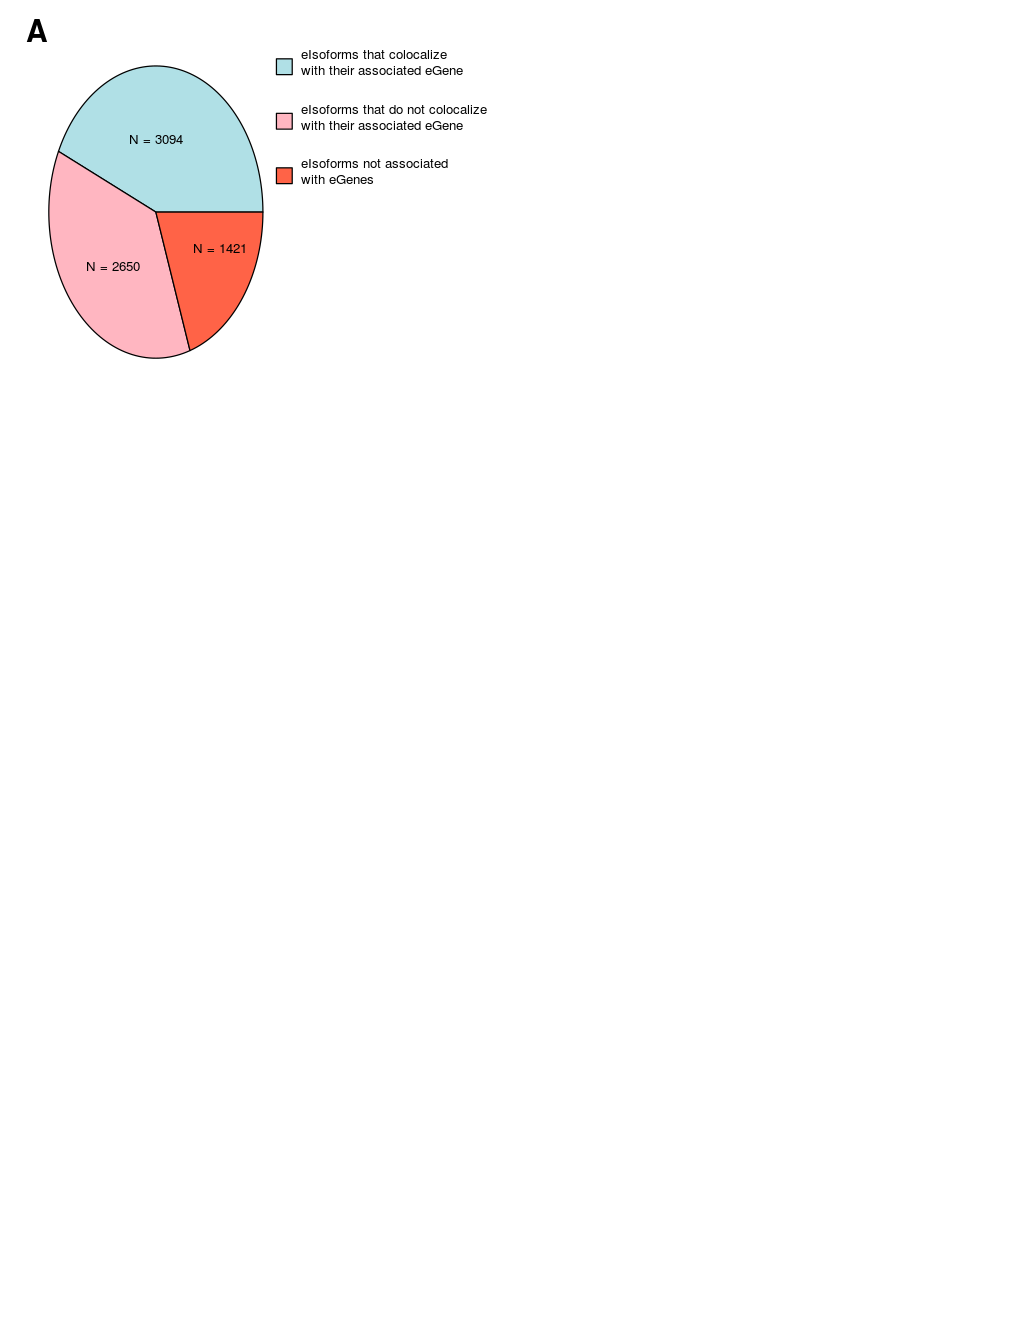

In [664]:
figure_4a = function()
{
    toplot = data.frame(slice = c(isoforms_coloc_egenes, isoforms_egenes - isoforms_coloc_egenes, isoforms_not_egenes), 
                        label = c("eIsoforms that colocalize with their associated eGene", "eIsoforms that do not colocalize with their associated eGene","eIsoforms not associated with eGenes"),
                        color = c("#B0E0E6", "#FFB6C1", "#FF6347")
                       )
    
    
    par(mar = c(2,2,1,1))
    
    plot(1,1, type = "n", xlim = c(0, 1), ylim = c(0, 1), axes = FALSE)
    floating.pie(toplot$slice, col = toplot$color, xpos = 0.25, ypos = 0.5, radius = 0.25, shadow = FALSE)
    
    points(x = rep(0.55, 3)      , y = 1 - 0.1 - (0:2) * 0.15, bg     = toplot$color, pch = 22, cex = 3)
    text  (x = rep(0.57, 3)      , y = 1 - 0.1 - (0:2) * 0.15, labels = gsub("associated with", "associated\nwith", gsub("colocalize ", "colocalize\n", toplot$label)), pos =  4)
    text  (x = c(0.25, 0.15, 0.4), y = c(0.7, 0.35, 0.4)     , labels = paste("N", toplot$slice, sep = " = "))
    
    
    mtext(text = "A", side = 2, line = -1, las = 2, at = 1, font = 2, cex = 1.5)
}

figure_4 = function()
{
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    
    figure_4a()
}

#png(filename = "manuscript/figure_4.png", width = 8.5, height = 11, units = "in", res = 300)
#figure_4()
#dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_4()


In [630]:
toint           = int_isoforms [int_isoforms $cell  == TRUE, c("transcript_id", "type", "interaction")]
totest          = eqtl_isoforms[eqtl_isoforms$egene == TRUE,]
totest$tr2type  = paste(totest$transcript_id, totest$type )
toint $tr2type  = paste(toint $transcript_id, toint $type )
totest$cell     = FALSE
totest$ingene   = FALSE
totest$test     = FALSE

totest[totest$pos >= totest$start & totest$pos <= totest$end                               , "ingene"] = TRUE
totest[totest$ingene == TRUE | (abs(totest$distance) < (totest$end - totest$start))        , "test"  ] = TRUE
totest[totest$tr2type %in% toint[toint$interaction %in% c("ipsc_cvpc", "adult"), "tr2type"], "cell"  ] = TRUE

#totest = totest[totest$test == TRUE,]

totest_stage = c(nrow(totest[ totest$cell == TRUE  & totest$ingene == TRUE ,]),
                 nrow(totest[ totest$cell == TRUE  & totest$ingene == FALSE,]),
                 nrow(totest[ totest$cell == FALSE & totest$ingene == TRUE ,]),
                 nrow(totest[ totest$cell == FALSE & totest$ingene == FALSE,])
                )

matrix(totest_stage, nrow = 2, byrow = TRUE)

test_stage = fisher.test(matrix(totest_stage, nrow = 2, byrow = TRUE))

message(paste("eIsoforms in the gene body are more likely to be associated with stage: p = ", signif(test_stage$p.value, digits = 3), "; OR = ", signif(test_stage$estimate, digits = 3), sep = ""))


128,169
2849,5343


eIsoforms in the gene body are more likely to be associated with stage: p = 0.00359; OR = 1.42



In [632]:
toint           = int_isoforms [int_isoforms $cell  == TRUE, c("transcript_id", "type", "interaction")]
totest          = eqtl_isoforms[eqtl_isoforms$egene == TRUE,]
totest$tr2type  = paste(totest$transcript_id, totest$type )
toint $tr2type  = paste(toint $transcript_id, toint $type )
totest$cell     = FALSE
totest$ingene   = FALSE
totest$test     = FALSE

totest[totest$pos >= totest$start & totest$pos <= totest$end                               , "ingene"] = TRUE
totest[totest$ingene == TRUE | (abs(totest$distance) < (totest$end - totest$start))        , "test"  ] = TRUE
totest[totest$tr2type %in% toint[!toint$interaction %in% c("ipsc_cvpc", "adult") & grepl("cibersort", toint$interaction) == FALSE, "tr2type"], "cell"  ] = TRUE

#totest = totest[totest$test == TRUE,]

totest_tissue = c(nrow(totest[ totest$cell == TRUE  & totest$ingene == TRUE ,]),
                  nrow(totest[ totest$cell == TRUE  & totest$ingene == FALSE,]),
                  nrow(totest[ totest$cell == FALSE & totest$ingene == TRUE ,]),
                  nrow(totest[ totest$cell == FALSE & totest$ingene == FALSE,])
                 )

matrix(totest_tissue, nrow = 2, byrow = TRUE)
test_tissue = fisher.test(matrix(totest_tissue, nrow = 2, byrow = TRUE))

message(paste("eIsoforms in the gene body are more likely to be associated with tissue: p = ", signif(test_tissue$p.value, digits = 3), "; OR = ", signif(test_tissue$estimate, digits = 3), sep = ""))



128,169
2849,5343


eIsoforms in the gene body are more likely to be associated with tissue: p = 1.06e-05; OR = 1.6



In [633]:
toint           = int_isoforms [int_isoforms $cell  == TRUE, c("transcript_id", "type", "interaction")]
totest          = eqtl_isoforms[eqtl_isoforms$egene == TRUE,]
totest$tr2type  = paste(totest$transcript_id, totest$type )
toint $tr2type  = paste(toint $transcript_id, toint $type )
totest$cell     = FALSE
totest$ingene   = FALSE
totest$test     = FALSE

totest[totest$ingene == TRUE | (abs(totest$distance) < (totest$end - totest$start))        , "test"  ] = TRUE
totest[totest$tr2type %in% toint[grepl("cibersort", toint$interaction) == TRUE , "tr2type"], "cell"  ] = TRUE
totest[totest$pos >= totest$start & totest$pos <= totest$end                               , "ingene"] = TRUE

#totest = totest[totest$test == TRUE,]

totest_cell = c(nrow(totest[ totest$cell == TRUE  & totest$ingene == TRUE ,]),
                nrow(totest[ totest$cell == TRUE  & totest$ingene == FALSE,]),
                nrow(totest[ totest$cell == FALSE & totest$ingene == TRUE ,]),
                nrow(totest[ totest$cell == FALSE & totest$ingene == FALSE,])
               )

matrix(totest_cell, nrow = 2, byrow = TRUE)

test_cell = fisher.test(matrix(totest_cell, nrow = 2, byrow = TRUE))

message(paste("eIsoforms in the gene body are more likely to be associated with tissue: p = ", signif(test_cell$p.value, digits = 3), "; OR = ", signif(test_cell$estimate, digits = 3), sep = ""))


179,215
2798,5297


eIsoforms in the gene body are more likely to be associated with tissue: p = 1.44e-05; OR = 1.58



In [1536]:
figure_s18x = function(x, name, panel = "")
{
    x = matrix(x, nrow = 2, byrow = TRUE)
    par(mar = c(4,4,2,1))
    plot(1,1, type = "n", xlim = c(0,4), ylim = c(0,4), xlab = "", ylab = "", axes = FALSE)
    
    abline(h = 1:3)
    abline(v = 1:3)
    
    test  = fisher.test(x)
    ptext = paste("p = ", signif(test$p.value, digits = 3), "; OR = ", signif(test$estimate, digits = 3), sep = "")
    
    mtext(text = paste(name, "associated", sep = "-"), side = 3, line = 0.5, at = 2.5)
    mtext(text = "eQTL in isoform body"              , side = 2, line = 0.5, at = 1.5)
    mtext(text = panel                               , side = 2, line = 1  , at = 4.2, font = 2, cex = 1.5, las = 2)
    mtext(text = ptext                               , side = 1, line = 1  , at = 2  , font = 2, cex = 1.2)
    
    text(x = rep(0.5, 3)     , y = c(2.5, 1.5, 0.5), labels = c("YES", "NO", "Total"), cex = 1.5)
    text(x = c(1.5, 2.5, 3.5), y = rep(3.5, 3)     , labels = c("YES", "NO", "Total"), cex = 1.5)
    
    text(x = rep(1.5, 3), y = c(2.5, 1.5, 0.5), cex = 1.5, labels = c(x[1,], sum(x[1,])))
    text(x = rep(2.5, 3), y = c(2.5, 1.5, 0.5), cex = 1.5, labels = c(x[2,], sum(x[1,])))
    text(x = rep(3.5, 3), y = c(2.5, 1.5, 0.5), cex = 1.5, labels = c(colSums(x), sum(x)))
    #text(x = rep(2.5, 2), y = c(2.5, 1.5), labels = c("YES", "NO"), cex = 1.5)
    
}

figure_s18 = function()
{
    layout(matrix(1:3, nrow = 3, byrow = TRUE))
    figure_s18x(totest_stage , "Stage"    , "A")
    figure_s18x(totest_tissue, "Tissue"   , "B")
    figure_s18x(totest_cell  , "Cell type", "C")
}

png(filename = "manuscript/figure_S18.png", width = 4.5, height = 8.5, units = "in", res = 300)
figure_s18()
dev.off()

options(repr.plot.width = 4.5, repr.plot.height = 8.5)
figure_s18()


png 
  2

ERROR: Error in plot.new(): could not open file '/tmp/6171273.1.juphigh.q/RtmpYpZ4AI/file2c4c3c9aeef1.png'


## Figure 5: colocalization between eQTLs and GWAS

In [362]:
coloc_gene       = fread("pipeline/6.1.coloc_gwas/coloc.eqtls.gene.txt"          , sep = "\t", header = TRUE , data.table = FALSE)
coloc_isoform    = fread("pipeline/6.1.coloc_gwas/coloc.eqtls.isoform.txt"       , sep = "\t", header = TRUE , data.table = FALSE)


In [427]:
message(paste("Number of eGenes that colocalize with GWAS"   , length(unique(coloc_gene   [ coloc_gene   $PP.H4.abf >= 0.5, "transcript_id"])), sep = " = "))
message(paste("Number of eIsoforms that colocalize with GWAS", length(unique(coloc_isoform[ coloc_isoform$PP.H4.abf >= 0.5, "transcript_id"])), sep = " = "))

message(paste("% of eGenes that colocalize with GWAS"   , signif(length(unique(coloc_gene   [ coloc_gene   $PP.H4.abf >= 0.5, "transcript_id"])) / length(unique(coloc_gene   $transcript_id)) * 100, digits = 4), sep = " = "))
message(paste("% of eIsoforms that colocalize with GWAS", signif(length(unique(coloc_isoform[ coloc_isoform$PP.H4.abf >= 0.5, "transcript_id"])) / length(unique(coloc_isoform$transcript_id)) * 100, digits = 4), sep = " = "))



Number of eGenes that colocalize with GWAS = 3722

Number of eIsoforms that colocalize with GWAS = 2364

% of eGenes that colocalize with GWAS = 31.95

% of eIsoforms that colocalize with GWAS = 33.04



In [1070]:
cell_gwas_enrichment = function(cell, name, egenes, coloc)
{
    totest = data.frame(tr2id = sort(unique(egenes$tr2id)), cell = FALSE, gwas = FALSE)
    
    totest[totest$tr2id %in% egenes[egenes$interaction == cell & egenes$cell == TRUE, "tr2id"  ], "cell"] = TRUE
    totest[totest$tr2id %in% coloc [coloc $PP.H4.abf   >= 0.5                       , "tr2type"], "gwas"] = TRUE
    
    totest = matrix(c(nrow(totest[totest$cell == TRUE  & totest$gwas == TRUE ,]),
                      nrow(totest[totest$cell == FALSE & totest$gwas == TRUE ,]),
                      nrow(totest[totest$cell == TRUE  & totest$gwas == FALSE,]),
                      nrow(totest[totest$cell == FALSE & totest$gwas == FALSE,])
                     ), nrow = 2, byrow = TRUE)
    
    test = fisher.test(totest)
    
    message(paste(name, cell, paste("p", signif(test$p.value, digits = 3), sep = " = "), paste("Estimate", signif(test$estimate, digits = 3), sep = " = "), sep = "; "))
}

#invisible(lapply(sort(unique(int_genes   $interaction)), function(cell){cell_gwas_enrichment(cell, "Genes"   , int_genes   , coloc_gene   )}))
#invisible(lapply(sort(unique(int_isoforms$interaction)), function(cell){cell_gwas_enrichment(cell, "Isoforms", int_isoforms, coloc_isoform)}))


In [1064]:
gwas_cell = function(name, egenes, coloc)
{
    egenes = egenes[ egenes$tr2id %in% unique(coloc[coloc$PP.H4.abf >= 0.5, "tr2type"]),]
    mycond = paste(unlist(lapply(0:max(egenes$type), function(type)
                  {
                      paste("Conditional ", type, " = ", length(unique(egenes[egenes$type == type & egenes$cell == TRUE, "transcript_id"])), sep = "")
                  })), collapse = "\n")
    
    mycell = paste(unlist(lapply(sort(unique(egenes[grepl("cibersort", egenes$interaction) == TRUE, "interaction"])), function(x)
             {
                 this = egenes[egenes$interaction == x & egenes$cell == TRUE,]
                 return(paste(gsub("_", " ", sub("^cibersort.regular\\.", "", x)), " = ", length(unique(this$transcript_id)), " (Specific = ", length(unique(this[this$specific == TRUE, "transcript_id"])), "; Associated = ", length(unique(this[this$associated == TRUE, "transcript_id"])), ")", sep = ""))
             })), collapse = "\n")
    
    mytissue = paste(unlist(lapply(sort(unique(egenes[grepl("cibersort", egenes$interaction) == FALSE, "interaction"])), function(x)
               {
                   this = egenes[egenes$interaction == x & egenes$cell == TRUE,]
                   return(paste(gsub("_", "-", x), " = ", length(unique(this$transcript_id)), " (Specific = ", length(unique(this[this$specific == TRUE, "transcript_id"])), "; Associated = ", length(unique(this[this$associated == TRUE, "transcript_id"])), ")", sep = ""))
               })), collapse = "\n")

    message(paste("####################################################",
                  name,
                  paste("Tested isoforms"                       , length(unique(egenes$transcript_id)), sep = " = "),
                  paste("Tested genes"                          , length(unique(egenes$transcript_id)), sep = " = "),
                  paste("Isoforms with significant interactions", length(unique(egenes[egenes$cell == TRUE, "transcript_id"])), sep = " = "),
                  paste("Genes with significant interactions"   , length(unique(egenes[egenes$cell == TRUE, "gene_id"      ])), sep = " = "),
                  "",
                  paste("Stage-associated isoforms"    , length(unique(egenes[egenes$cell == TRUE &                                                     egenes$interaction %in% c("ipsc_cvpc", "adult"), "transcript_id"])), sep = " = "),
                  paste("Tissue-associated isoforms"   , length(unique(egenes[egenes$cell == TRUE & grepl("^cibersort", egenes$interaction) == FALSE & !egenes$interaction %in% c("ipsc_cvpc", "adult"), "transcript_id"])), sep = " = "),
                  paste("Cell type-associated isoforms", length(unique(egenes[egenes$cell == TRUE & grepl("^cibersort", egenes$interaction) == TRUE                                                    , "transcript_id"])), sep = " = "),
                  "",
                  "Conditional eQTLs",
                  mycond,
                  "",
                  "Tissue-associated eQTLs",
                  mytissue,
                  "",
                  "Cell type-associated eQTLs",
                  mycell,
                  sep = "\n"
                 ))
}

gwas_cell("Genes"   , int_genes   , coloc_gene   )
gwas_cell("Isoforms", int_isoforms, coloc_isoform)


####################################################
Genes
Tested isoforms = 3722
Tested genes = 3722
Isoforms with significant interactions = 587
Genes with significant interactions = 587

Stage-associated isoforms = 226
Tissue-associated isoforms = 395
Cell type-associated isoforms = 372

Conditional eQTLs
Conditional 0 = 512
Conditional 1 = 76
Conditional 2 = 20
Conditional 3 = 5
Conditional 4 = 7
Conditional 5 = 5

Tissue-associated eQTLs
adult = 177 (Specific = 146; Associated = 31)
arteria = 206 (Specific = 110; Associated = 98)
arteria-aorta = 140 (Specific = 68; Associated = 75)
arteria-coronary = 29 (Specific = 8; Associated = 22)
heart = 150 (Specific = 85; Associated = 67)
heart-atrium = 56 (Specific = 22; Associated = 34)
heart-ventricle = 74 (Specific = 29; Associated = 46)
ipsc-cvpc = 50 (Specific = 20; Associated = 30)

Cell type-associated eQTLs
cardiac muscle = 128 (Specific = 77; Associated = 53)
cardiac neuron = 25 (Specific = 14; Associated = 11)
endocardial = 36 (S

In [400]:
manifest = fread("pipeline/6.1.coloc_gwas/traits.manifest.txt", sep = "\t", header = TRUE, data.table = FALSE)
manifest = manifest[ manifest$id %in% unique(coloc_gene$trait),]

manifest$group = ""

manifest[manifest$trait_type == "prescriptions", "group"] = "Prescriptions"
manifest[manifest$trait_type == "icd10"        , "group"] = "ICD10"

manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("ypertension"               , manifest$description) == TRUE    , "group"] = "Blood"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("holesterol"                , manifest$description) == TRUE    , "group"] = "Blood"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("LDL"                       , manifest$description) == TRUE    , "group"] = "Blood"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("besity"                    , manifest$description) == TRUE    , "group"] = "BMI/Obesity"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("BMI"                       , manifest$description) == TRUE    , "group"] = "BMI/Obesity"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("therosclerosis"            , manifest$description) == TRUE    , "group"] = "Blood"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("ibrillation"               , manifest$description) == TRUE    , "group"] = "Disease"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("threosclerosis"            , manifest$description) == TRUE    , "group"] = "Disease"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("isease"                    , manifest$description) == TRUE    , "group"] = "Disease"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("pain"                      , manifest$description) == TRUE    , "group"] = "Disease"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("infarction"                , manifest$description) == TRUE    , "group"] = "Disease"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("Varicose"                  , manifest$description) == TRUE    , "group"] = "Disease"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("failure"                   , manifest$description) == TRUE    , "group"] = "Disease"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("ngina"                     , manifest$description) == TRUE    , "group"] = "Disease"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("ressure"                   , manifest$description) == TRUE    , "group"] = "Pressure"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("ulse rate"                 , manifest$description) == TRUE    , "group"] = "EKG"
manifest[!manifest$trait_type %in% c("icd10", "prescriptions") & grepl("eart rate"                 , manifest$description) == TRUE    , "group"] = "EKG"

manifest[manifest$description == "Non-cancer illness code, self-reported"     , "group"] = "Disease"
manifest[manifest$description == "Vascular/heart problems diagnosed by doctor", "group"] = "Disease"
manifest[manifest$description == "Age heart attack diagnosed"                 , "group"] = "Disease"
manifest[manifest$description == "Phlebitis and thrombophlebitis"             , "group"] = "Disease"
manifest[manifest$description == "Angina pectoris"                            , "group"] = "Disease"
manifest[manifest$description == "Bundle branch block"                        , "group"] = "Disease"
manifest[manifest$description == "Cardiac conduction disorders"               , "group"] = "Disease"
manifest[manifest$description == "Palpitations"                               , "group"] = "Disease"
manifest[manifest$description == "Bundle branch block"                        , "group"] = "Disease"
manifest[manifest$description == "Triglycerides"                              , "group"] = "Blood"
manifest[manifest$description == "Lipoprotein A"                              , "group"] = "Blood"
manifest[manifest$description == "Ventricular rate"                           , "group"] = "EKG"
manifest[manifest$description == "QRS duration"                               , "group"] = "EKG"
manifest[manifest$description == "Calcium"                                    , "group"] = "Blood"

table(manifest$group)



        Blood   BMI/Obesity       Disease           EKG         ICD10 
           11             3            27             5             8 
Prescriptions      Pressure 
            9            49 

In [404]:
trait2eqtl_gene    = aggregate(id ~ trait, data = coloc_gene   [coloc_gene   $PP.H4.abf >= 0.5,], FUN = length)
trait2eqtl_isoform = aggregate(id ~ trait, data = coloc_isoform[coloc_isoform$PP.H4.abf >= 0.5,], FUN = length)

colnames(trait2eqtl_gene   ) = c("trait", "egenes"   )
colnames(trait2eqtl_isoform) = c("trait", "eisoforms")

trait2eqtl = merge(manifest  , trait2eqtl_gene   , by.x = "id", by.y = "trait", all.x = TRUE)
trait2eqtl = merge(trait2eqtl, trait2eqtl_isoform, by.x = "id", by.y = "trait", all.x = TRUE)

trait2eqtl$egenes    = trait2eqtl$egenes    / nrow(eqtl_genes   [eqtl_genes   $egene == TRUE, ]) * 100
trait2eqtl$eisoforms = trait2eqtl$eisoforms / nrow(eqtl_isoforms[eqtl_isoforms$egene == TRUE, ]) * 100


png 
  2

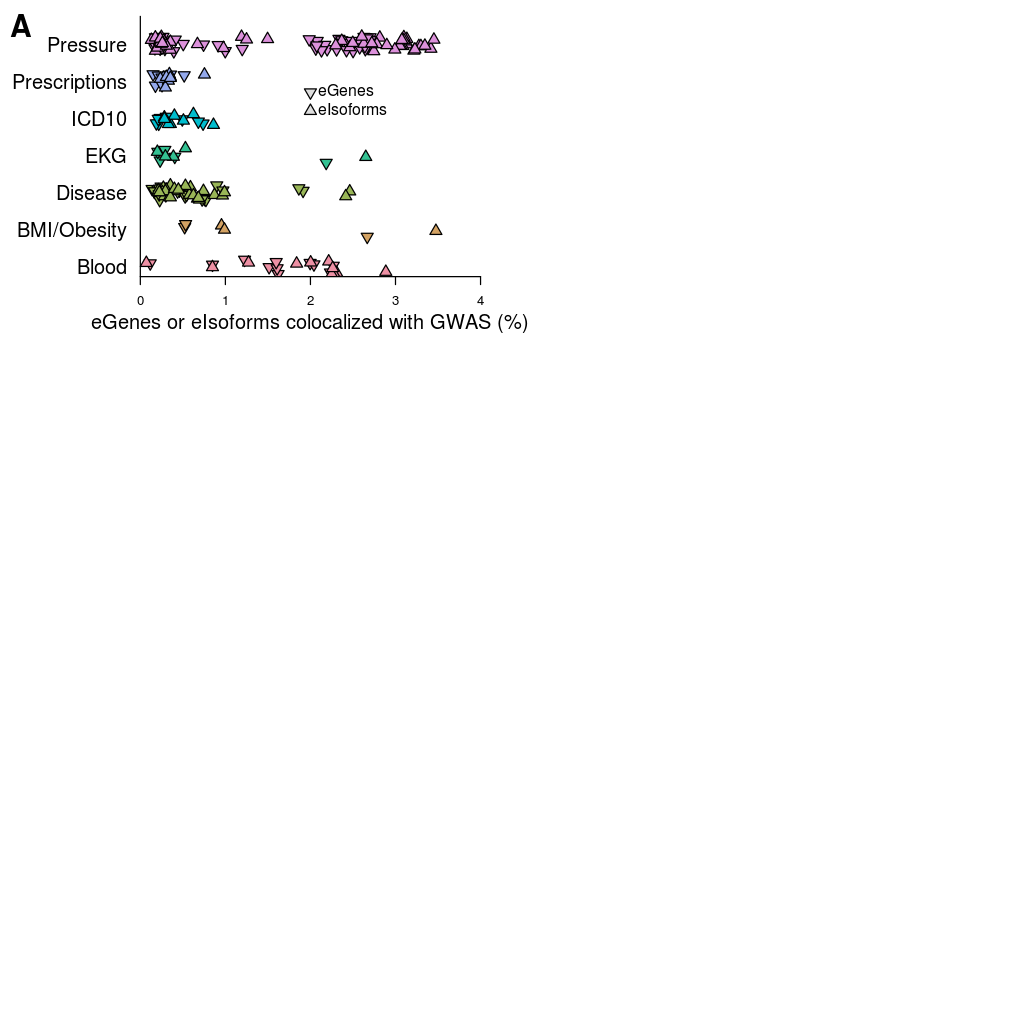

In [423]:
figure_5a = function()
{
    group2y = data.frame(group = sort(unique(manifest$group)), y = 1:length(unique(manifest$group)), color = qualitative_hcl(n = length(unique(manifest$group)), palette = "Set2"))
    toplot  = merge(trait2eqtl, group2y)
    
    par(mar = c(4,8,1,1))
    plot  (toplot$egenes   , jitter(toplot$y - 0.5, amount = 0.2), bg = toplot$color, pch = 25, cex = 1.5, xlim = c(0,4), ylim = c(0.5, nrow(group2y)), xlab = "", ylab = "", axes = FALSE)
    points(toplot$eisoforms, jitter(toplot$y - 0.5, amount = 0.2), bg = toplot$color, pch = 24, cex = 1.5)
    axis(1)
    
    abline(v = 0)
    
    mtext(text = group2y$group, side = 2, line = 0, at = group2y$y - 0.5, las = 2)
    mtext(text = "A"          , side = 2, line = 6, las = 2, at = max(group2y$y), font = 2, cex = 1.5)
    mtext(text = "eGenes or eIsoforms colocalized with GWAS (%)", side = 1, line = 2.5)
    
    points(x = rep(2,2), y = c(5.2, 4.7), cex = 1.5, pch = c(25,24), bg = "#dddddd")
    text  (x = rep(2,2), y = c(5.2, 4.7), cex = 1.2, labels = c("eGenes", "eIsoforms"), pos = 4)
}

figure_5 = function()
{
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    figure_5a()
}

png(filename = "manuscript/figure_5.png", width = 5, height = 8.5, units = "in", res = 300)
figure_5()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_5()

In [673]:
iso2egene         = merge(tosp1    , coloc_isoform[,c("tr2type", "trait", "PP.H4.abf")], by.x = "tr2type1", by.y = "tr2type", suffixes = c("_iso_gene", "_iso_trait"))
iso2egene$tr2type = iso2egene$tr2type2
iso2egene         = merge(iso2egene, coloc_gene   [,c("tr2type", "trait", "PP.H4.abf")], by = c("tr2type", "trait"), suffixes = 1:2)

colnames(iso2egene)[[7]] = "PP.H4.abf_gene_trait"

In [678]:
iso2egene_short = iso2egene[iso2egene$PP.H4.abf_iso_trait >= 0.5 | iso2egene$PP.H4.abf_gene_trait >= 0.5,]

In [711]:
ni_start = length(unique(iso2egene$tr2type1))
ng_start = length(unique(iso2egene$tr2type2))

ni0 = length(unique(iso2egene_short$tr2type1))
ng0 = length(unique(iso2egene_short$tr2type2))

ei1 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene >= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait >= 0.5 & iso2egene_short$PP.H4.abf_gene_trait >= 0.5), "tr2type1"])
eg1 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene >= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait >= 0.5 & iso2egene_short$PP.H4.abf_gene_trait >= 0.5), "tr2type2"])
ei2 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene >= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait <  0.5 | iso2egene_short$PP.H4.abf_gene_trait <  0.5) & !iso2egene_short$tr2type1 %in%   ei1                , "tr2type1"])
eg2 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene >= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait <  0.5 | iso2egene_short$PP.H4.abf_gene_trait <  0.5) & !iso2egene_short$tr2type2 %in%   eg1                , "tr2type2"])
ei3 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene <= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait >= 0.5 & iso2egene_short$PP.H4.abf_gene_trait >= 0.5) & !iso2egene_short$tr2type1 %in% c(ei1, ei2          ), "tr2type1"])
eg3 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene <= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait >= 0.5 & iso2egene_short$PP.H4.abf_gene_trait >= 0.5) & !iso2egene_short$tr2type2 %in% c(eg1, eg2          ), "tr2type2"])
ei4 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene <= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait <  0.5 & iso2egene_short$PP.H4.abf_gene_trait >= 0.5) & !iso2egene_short$tr2type1 %in% c(ei1, ei2, ei3     ), "tr2type1"])
eg4 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene <= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait <  0.5 & iso2egene_short$PP.H4.abf_gene_trait >= 0.5) & !iso2egene_short$tr2type2 %in% c(eg1, eg2, eg3     ), "tr2type2"])
ei5 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene <= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait >= 0.5 & iso2egene_short$PP.H4.abf_gene_trait <  0.5) & !iso2egene_short$tr2type1 %in% c(ei1, ei2, ei3, ei4), "tr2type1"])
eg5 = unique(iso2egene_short[ iso2egene_short$PP.H4.abf_iso_gene <= 0.5 & (iso2egene_short$PP.H4.abf_iso_trait >= 0.5 & iso2egene_short$PP.H4.abf_gene_trait <  0.5) & !iso2egene_short$tr2type2 %in% c(eg1, eg2, eg3, eg4), "tr2type2"])

ni1 = length(ei1)
ni2 = length(ei2)
ni3 = length(ei3)
ni4 = length(ei4)
ni5 = length(ei5)

ng1 = length(eg1)
ng2 = length(eg2)
ng3 = length(eg3)
ng4 = length(eg4)
ng5 = length(eg5)

message("########################################")
message("eIsoforms")
message(paste("eIsoforms", ni_start, sep = " = "))
message(paste("eIsoforms that colocalize with GWAS or have their associated eGene colocalize"                                , ni0, sep = " = "))
message(paste("eIsoforms that colocalize with their associated eGene and GWAS"                                               , ni1, sep = " = "))
message(paste("eIsoforms that colocalize with their associated eGene but not with GWAS"                                      , ni2, sep = " = "))
message(paste("eIsoforms that do not colocalize with their associated eGene but both eIsoform and eGene colocalize with GWAS", ni3, sep = " = "))
message(paste("eIsoforms that do not colocalize with their associated eGene and only eGene colocalize with GWAS"             , ni4, sep = " = "))
message(paste("eIsoforms that do not colocalize with their associated eGene and only eIsoform colocalize with GWAS"          , ni5, sep = " = "))

message("########################################")
message("eGenes")
message(paste("eGenes", ng_start, sep = " = "))
message(paste("eGenes that colocalize with GWAS or have their associated eIsoform colocalize"                                , ng0, sep = " = "))
message(paste("eGenes that colocalize with their associated eIsoform and GWAS"                                               , ng1, sep = " = "))
message(paste("eGenes that colocalize with their associated eIsoform but not with GWAS"                                      , ng2, sep = " = "))
message(paste("eGenes that do not colocalize with their associated eGene but both eIsoform and eGene colocalize with GWAS"   , ng3, sep = " = "))
message(paste("eGenes that do not colocalize with their associated eGene and only eGene colocalize with GWAS"                , ng4, sep = " = "))
message(paste("eGenes that do not colocalize with their associated eGene and only eIsoform colocalize with GWAS"             , ng5, sep = " = "))




########################################

eIsoforms

eIsoforms = 6886

eIsoforms that colocalize with GWAS or have their associated eGene colocalize = 3463

eIsoforms that colocalize with their associated eGene and GWAS = 775

eIsoforms that colocalize with their associated eGene but not with GWAS = 601

eIsoforms that do not colocalize with their associated eGene but both eIsoform and eGene colocalize with GWAS = 171

eIsoforms that do not colocalize with their associated eGene and only eGene colocalize with GWAS = 1376

eIsoforms that do not colocalize with their associated eGene and only eIsoform colocalize with GWAS = 540

########################################

eGenes

eGenes = 5082

eGenes that colocalize with GWAS or have their associated eIsoform colocalize = 2518

eGenes that colocalize with their associated eIsoform and GWAS = 474

eGenes that colocalize with their associated eIsoform but not with GWAS = 438

eGenes that do not colocalize with their associated eGene but bot

### Table 1: iPSC-CVPC-specific eIsoforms that colocalize with GWAS but their eGene does not

In [1149]:
tab_gene = fread("pipeline/X.1.combine/combined.gene_tpm.txt"            , sep = "\t", header = TRUE, data.table = FALSE)
tab_isof = fread("pipeline/X.1.combine/combined.isoform_use.txt"         , sep = "\t", header = TRUE, data.table = FALSE)
tab1     = fread("pipeline/X.1.combine/eisoforms_no_coloc_with_egene.txt", sep = "\t", header = TRUE, data.table = FALSE)

### Examples: LPP, KANK2, PRKG1, NOD1

In [1150]:
exons    = fread("/frazer01/reference/private/Gencode.v34lift37/exon_info.txt"      , sep = "\t", header = TRUE, data.table = FALSE)
cds      = fread("/frazer01/reference/private/Gencode.v34lift37/cds_info.txt"       , sep = "\t", header = TRUE, data.table = FALSE)


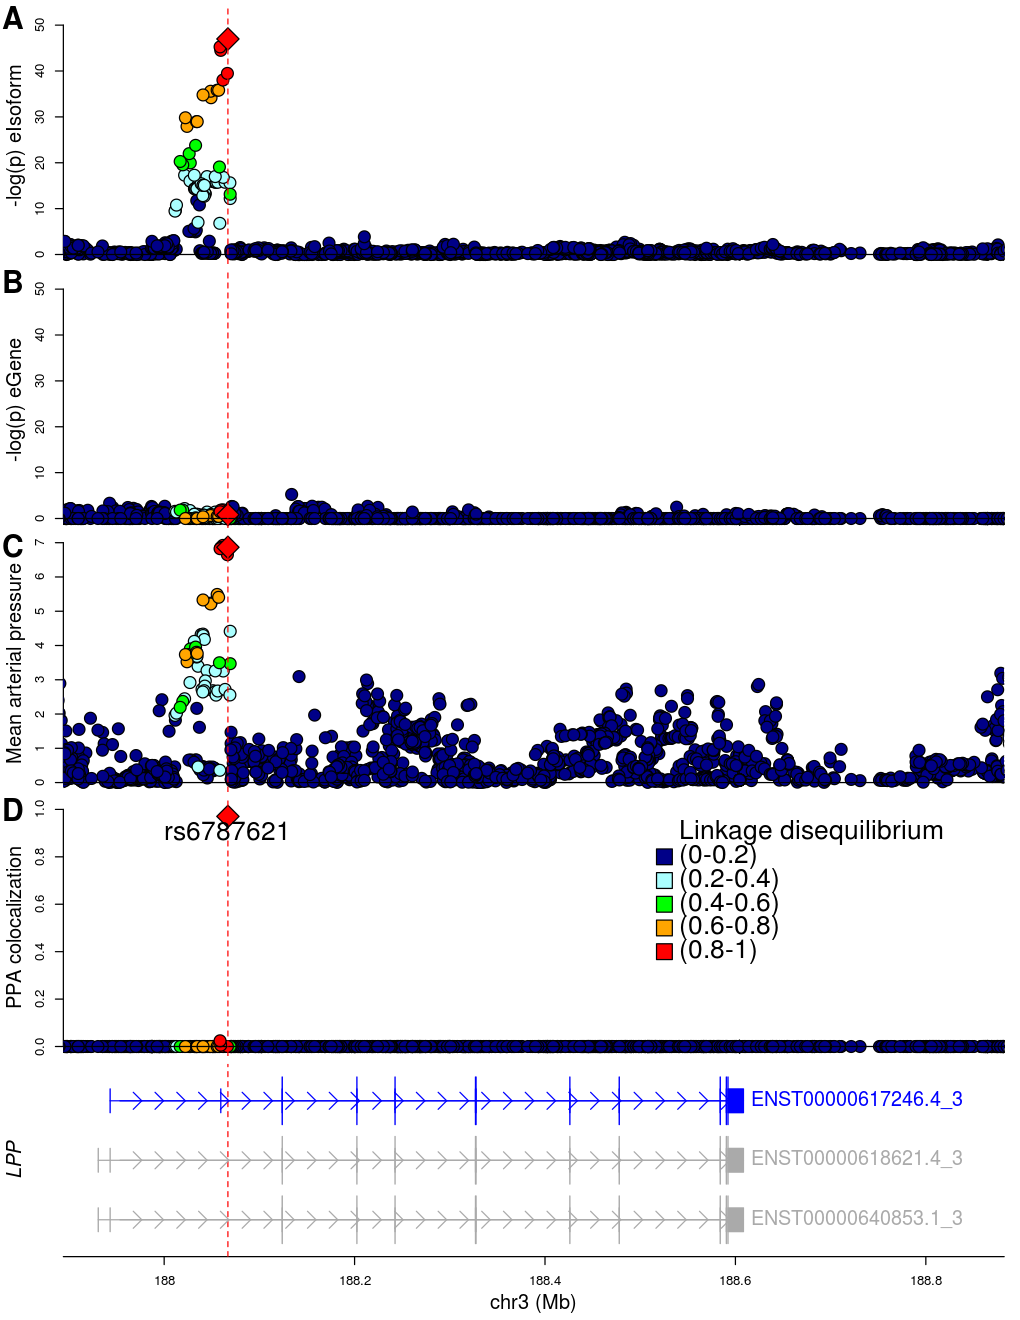

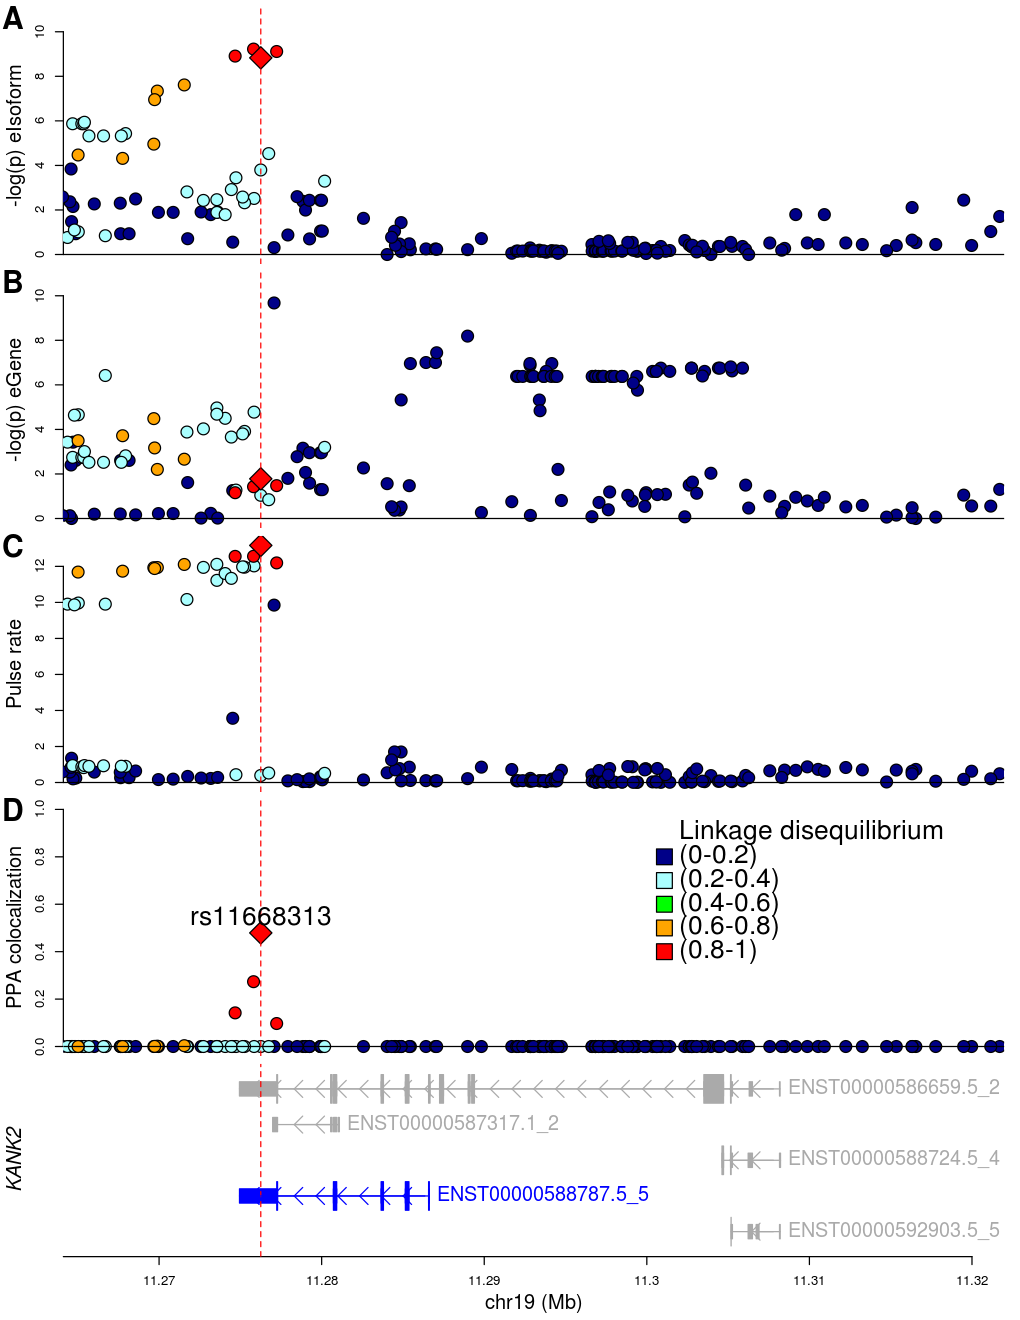

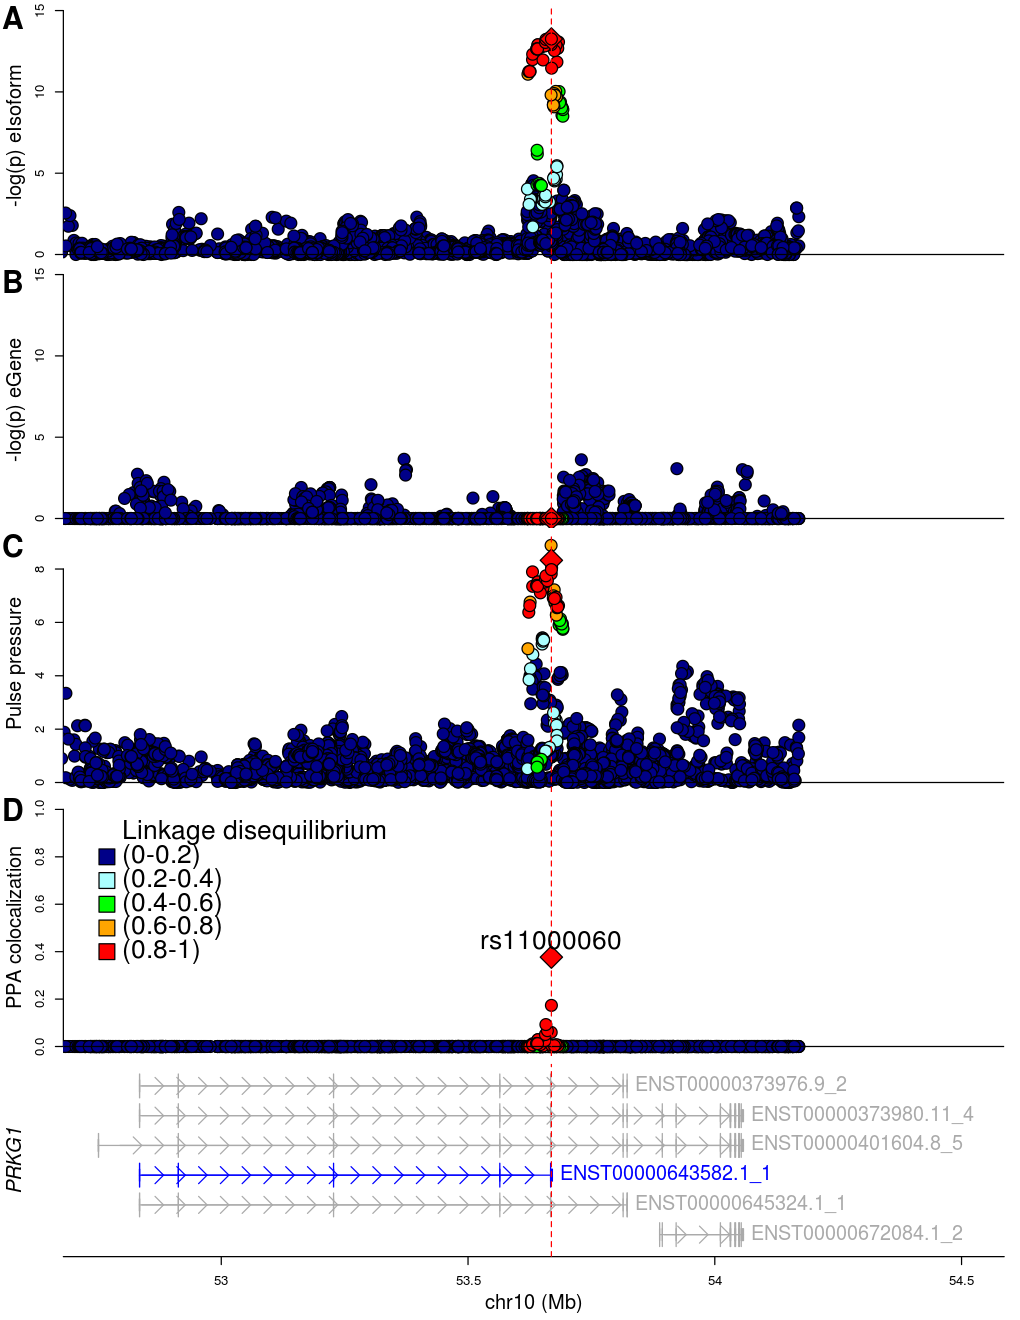

png 
  2

png 
  2

png 
  2

In [ ]:
plot_sumstats = function(indata, myvar, myrange, ylim = 0, y_axis = "", rsid = FALSE, is_x_axis = TRUE, is_log = FALSE, is_legend = FALSE, panel = "", ...)
{
    indata$myvar = indata[,myvar]
    
    if(is_log == TRUE){indata$myvar = -log10(indata$myvar)}
    
    if(ylim == 0){ylim = max(indata$myvar)}
    
    par(...)
    plot(1,1, type = "n", xlim = myrange, ylim = c(min(indata$myvar), ylim), xlab = "", ylab = "", axes = FALSE)
    axis(2)
    if(is_x_axis == TRUE){axis(1)}
    
    mtext(text = y_axis, side = 2, line = 2.5)
    mtext(text = panel , side = 2, line = 2.5, las = 2, at = ylim, font = 2, cex = 1.5)
    
    points(indata$pos, indata$myvar, pch = indata$pch, col = "#000000", bg = indata$ld_color, cex = indata$cex)
    
    abline(h = 0)
    abline(v = indata[indata$pch == 23, "pos"], lty = "dashed", col = "#ff0000")
    
    mylead   = indata[which.max(indata$pp_snp_isoform), ]
    mypos    =     3
    x_legend =     0.65

    if(mylead[1, "pos"] >= myrange[[1]] + (myrange[[2]] - myrange[[1]]) / 2)
    {
        x_legend = 0.01
    }
    
    if(rsid == TRUE)
    {
        if(mylead[1, "myvar"] > 0.9){mypos = 1}
        
        text(x = mylead[1, "pos"], y = mylead[1, "myvar"], labels = mylead[1, "rsid"], pos = mypos, cex = 2)
    }
    
    if(is_legend == TRUE)
    {
        tol = data.frame(r2 = (0:4) / 5, name = paste("(", (0:4) / 5, "-", (1:5) / 5, ")", sep = ""), y = (5:1 + 3)/10 * ylim, color = c("#000088", "#aaffff", "#00ff00", "#ffa500", "#ff0000"))
        
        points(x = rep(myrange[[1]] + (myrange[[2]] - myrange[[1]]) * x_legend, nrow(tol)    ), y =   tol$y              , pch    = 22      , bg  = tol$color, cex = 3)
        text  (x = rep(myrange[[1]] + (myrange[[2]] - myrange[[1]]) * x_legend, nrow(tol) + 1), y = c(tol$y, ylim * 9/10), labels = c(paste("", tol$name, ""), " Linkage disequilibrium "), pos = 4, cex = 2)
    }
}

plot_scatter = function(indata, x, y, is_log = FALSE)
{
    par(mar = c(4,4,1,1))
    
    if(is_log == TRUE)
    {
        indata$x = -log10(indata[,x])
        indata$y = -log10(indata[,y])
    }else
    {
        indata$x = indata[,x]
        indata$y = indata[,y]
    }
    
    mymax = max(c(indata$x, indata$y))
    
    #plot(indata$x, indata$y, pch = 16, col = "#000000", cex = 0.8, xlim = c(0, mymax), ylim = c(0, mymax), xlab = "", ylab = "")
    plot(indata$x, indata$y, pch = 16, col = "#000000", cex = 0.8, xlab = "", ylab = "")
    
    mtext(x, side = 1, line = 2.5)
    mtext(y, side = 2, line = 2.5)
}

plot_transcript = function(transcript_id, gene_id, geneinfo, indata, xlims, exons, cds, ...)
{
    geneinfo       = geneinfo[geneinfo$gene_id == gene_id,]
    exons          = exons   [exons   $gene_id == gene_id,]
    cds            = cds     [cds     $gene_id == gene_id,]
    chrom          = unique(geneinfo$chrom    )
    strand         = unique(geneinfo$strand   )
    gene_name      = unique(geneinfo$gene_name)
    geneinfo$color = "#aaaaaa"
    geneinfo       = geneinfo[order(geneinfo$transcript_id),]
    geneinfo$y     = nrow(geneinfo):1
    geneinfo[geneinfo$transcript_id == transcript_id, "color"] = "#0000ff"
    
    exons = merge(exons, geneinfo[,c("color", "y", "transcript_id")])
    cds   = merge(cds  , geneinfo[,c("color", "y", "transcript_id")])
    
    par(...)
    plot(1,1, type = "n", xlim = xlims, ylim = c(0, nrow(geneinfo)), xlab = "", ylab = "", axes = FALSE)
    axis(1, at = pretty(xlims, n = 5), labels = pretty(xlims, n = 5) * 1e-6)
    
    segments(x0 = geneinfo$start, x1 = geneinfo$end, y0 = geneinfo$y - 0.5, col = geneinfo$color)
    
    if(nrow(exons) > 0){rect(xleft = exons$start , xright = exons$end, ybottom = exons$y - 0.3, col = exons$color, ytop = exons$y - 0.7, border = exons$color)}
    if(nrow(cds  ) > 0){rect(xleft = cds  $start , xright = cds  $end, ybottom = cds  $y - 0.1, col = cds  $color, ytop = cds  $y - 0.9, border = cds  $color)}
    
    #text(x = max(exons$end), y = 0.5, labels = transcript_id, col = "#0000ff", pos = 4, cex = 1.5, font = 3)
    
    mtext(text = gene_name             , side = 2, line = 2.5, font = 3)
    mtext(text = paste(chrom, "(Mb)")  , side = 1, line = 2.5)
    text (x = geneinfo$end, y = geneinfo$y - 0.5, labels = geneinfo$transcript_id, pos = 4, col = geneinfo$color, cex = 1.5)
    
    abline(v = indata[indata$pch == 23, "pos"], lty = "dashed", col = "#ff0000")
    
    myangle = 0
    if(strand == "-"){myangle = 180}
    
    toarrow = xlims[[1]] + (1:39) / 40 * (xlims[[2]] - xlims[[1]])
    
    for(yy in 1:nrow(geneinfo))
    {
        y               = geneinfo[yy, "y"]
        this_transcript = geneinfo[yy, "transcript_id"]
        this_exons      = exons[exons$transcript_id == this_transcript,]
        this_cds        = cds  [cds  $transcript_id == this_transcript,]
        this_arrow      = toarrow[toarrow >= min(this_exons$start) & toarrow <= max(this_exons$end)]

        if(strand == "+"){arrows(x0 = this_arrow[1:(length(this_arrow) - 1)], y0 = y - 0.5, x1 = this_arrow[2:(length(this_arrow)    )], length = 0.1, angle = 45, col = geneinfo[yy, "color"])}
        if(strand == "-"){arrows(x0 = this_arrow[2:(length(this_arrow)    )], y0 = y - 0.5, x1 = this_arrow[1:(length(this_arrow) - 1)], length = 0.1, angle = 45, col = geneinfo[yy, "color"])}
    }
}

plot_ex = function(transcript_id, type, trait, geneinfo, manifest, exons, cds)
{
    gene            = geneinfo[geneinfo$transcript_id == transcript_id,]
    gene_id         = gene[1, "gene_id"]
    geneinfo        = geneinfo[geneinfo$gene_id == gene_id,]
    coloc_gene_file = paste("pipeline/6.1.coloc_gwas/coloc.gene", paste("snp", gene_id      , "txt", sep = "."), sep = "/")
    egene           =              fread(paste("pipeline/3.2.eqtls/eqtls_by_gene/cardiac_eqtls.gene"   , paste("qtl"    , gene_id      , "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
    eisof           =              fread(paste("pipeline/3.2.eqtls/eqtls_by_gene/cardiac_eqtls.isoform", paste("qtl"    , transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
    pp2snp_isof     =              fread(paste("pipeline/6.1.coloc_gwas/coloc.isoform"                 , paste("snp"    , transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
    gtdata          = add_rownames(fread(paste("pipeline/1.3.genotype/use_isoform"                     , paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE))
    
    if(file.exists(coloc_gene_file) == TRUE)
    {
        pp2snp_gene     = fread(coloc_gene_file, sep = "\t", header = TRUE, data.table = FALSE)
        pp2snp_gene     = pp2snp_gene[pp2snp_gene$trait == trait & pp2snp_gene$type == 0,]
    }
    
    pp2snp_isof     = pp2snp_isof[pp2snp_isof$trait == trait & pp2snp_isof$type == type,]
    egene           = egene[egene$type == 0   ,]
    eisof           = eisof[eisof$type == type,]
    egene           = merge(eisof, egene[,c("id", "beta", "se", "pval")], by = "id", suffixes = c("", "_gene"))
    infile          = manifest[manifest$id == trait, "filename"]
    myrange         = range(egene$pos)
    coord           = paste(sub("chr", "", gene[1, "chrom"]), ":", myrange[[1]], "-", myrange[[2]], sep = "")
    command         = paste("tabix", "-h", infile, coord)
    gwas            = fread(cmd = command, sep = "\t", header = TRUE, data.table = FALSE)
    colnames(gwas)  = unlist(strsplit(system(paste("zcat", infile, "|", "head", "-n", 1), intern = TRUE), "\t"))
    gwas$id         = paste("VAR", gwas$chr, gwas$pos, gwas$ref, gwas$alt, sep = "_")
    gwas            = gwas[,c("id", "beta_meta", "se_meta", "pval_meta")]
    colnames(gwas)  = gsub("meta", "gwas", colnames(gwas))
    toplot          = merge(egene, gwas)
    toplot          = merge(toplot, pp2snp_isof[,c("id", "pp_snp")])
    
    if(file.exists(coloc_gene_file) == TRUE)
    {
        toplot          = merge(toplot, pp2snp_gene[,c("id", "pp_snp")], by = "id", suffixes = c("_isoform", "_gene"))
    }else
    {
        toplot$pp_snp_isoform = toplot$pp_snp
    }
    
    mylead    = toplot[which.max(toplot$pp_snp_isoform), "id"]
    lddata    = data.frame(id = rownames(gtdata), r2 = 0, ld_color = "#000088")
    mylead_gt = as.numeric(gtdata[mylead,])
    lddata$r2 = unlist(lapply(1:nrow(gtdata), function(jj)
    {
        tocor = data.frame(x = mylead_gt, y = as.numeric(gtdata[jj, ]))
        tocor = tocor[is.na(tocor$x) == FALSE & is.na(tocor$y) == FALSE, ]
        out   = (cor(tocor$x, tocor$y))^2
        
        return(out)
    }))
    
    if(nrow(lddata[lddata$r2 >= 0.2, ]) > 0){lddata[lddata$r2 >= 0.2, "ld_color"] = "#aaffff"}
    if(nrow(lddata[lddata$r2 >= 0.4, ]) > 0){lddata[lddata$r2 >= 0.4, "ld_color"] = "#00ff00"}
    if(nrow(lddata[lddata$r2 >= 0.6, ]) > 0){lddata[lddata$r2 >= 0.6, "ld_color"] = "#ffa500"}
    if(nrow(lddata[lddata$r2 >= 0.8, ]) > 0){lddata[lddata$r2 >= 0.8, "ld_color"] = "#ff0000"}
    
    toplot            = merge(toplot, lddata)
    ylim              = -log10(min(c(toplot$pval, toplot$pval_gene)))
    #myrange           = range(c(gene$start, gene$end, egene[which.min(egene$pval), "pos"] - 10000, egene[which.min(egene$pval), "pos"] + 10000))
    #myrange           = range(c(gene$start, gene$end, toplot[toplot$id == mylead, "pos"] - 10000, toplot[toplot$id == mylead, "pos"] + 10000))
    myrange           = range(c(geneinfo$start, geneinfo$end + (geneinfo$end - geneinfo$start) * 0.35, toplot[toplot$id == mylead, "pos"] - 10000, toplot[toplot$id == mylead, "pos"] + 10000))
    
    #return(manifest[manifest$id == trait, c("id", "description", "category")])
    
    if(manifest[manifest$id == trait, "description"] == "")
    {
        trait_description = sub("prescriptions-", "", sub("-both_sexes", "", manifest[manifest$id == trait, "id"]))
    }else
    {
        trait_description = unlist(strsplit(manifest[manifest$id == trait, "description"], ","))[[1]]
    }
    
    toplot$cex =  2
    toplot$pch = 21
    toplot     = toplot[order(toplot$r2),]
    
    toplot[toplot$id == mylead, "cex"] =  3
    toplot[toplot$id == mylead, "pch"] = 23
    
    #png(filename = paste("pipeline/X.1.combine", paste("example", gene[1, "gene_name"], "png", sep = "."), sep = "/"), width = 6.5, height = 11, units = "in", res = 300)
    options(repr.plot.width = 8.5, repr.plot.height = 11)
    layout(cbind(1:5))
    
    plot_sumstats(toplot, "pval"          , myrange, ylim * 1.1, "-log(p) eIsoform"  , FALSE, FALSE, TRUE , FALSE, "A", mar = c(0,4,0.5,1))
    plot_sumstats(toplot, "pval_gene"     , myrange, ylim * 1.1, "-log(p) eGene"     , FALSE, FALSE, TRUE , FALSE, "B", mar = c(0,4,0.5,1))
    plot_sumstats(toplot, "pval_gwas"     , myrange, 0         , trait_description   , FALSE, FALSE, TRUE , FALSE, "C", mar = c(0,4,0.5,1))
    plot_sumstats(toplot, "pp_snp_isoform", myrange, 1         , "PPA colocalization", TRUE , FALSE, FALSE, TRUE , "D", mar = c(0,4,0.5,1))
    
    plot_transcript(transcript_id, gene_id, geneinfo, toplot, myrange, exons, cds, mar = c(4,4,0.5,1))
    
    #plot_scatter(toplot, "pval"     , "pval_gene", TRUE)
    #plot_scatter(toplot, "pval"     , "pval_gwas", TRUE)
    #plot_scatter(toplot, "pval_gene", "pval_gwas", TRUE)
    
    #dev.off()
}

ii = 1
plot_ex(tab1[1, "transcript_id"], tab1[1, "type"], tab1[1, "trait"], geneinfo_isoforms, manifest, exons, cds)
plot_ex(tab1[2, "transcript_id"], tab1[2, "type"], tab1[2, "trait"], geneinfo_isoforms, manifest, exons, cds)
plot_ex(tab1[3, "transcript_id"], tab1[3, "type"], tab1[3, "trait"], geneinfo_isoforms, manifest, exons, cds)
plot_ex(tab1[4, "transcript_id"], tab1[4, "type"], tab1[4, "trait"], geneinfo_isoforms, manifest, exons, cds)

#invisible(lapply(1:nrow(tab1), function(ii){plot_ex(tab1[ii, "transcript_id"], tab1[ii, "type"], tab1[ii, "trait"], geneinfo_isoform, manifest, exons, cds)}))

png(filename = "manuscript/figure_X.png", width = 8.5, height = 11, units = "in", res = 300)
plot_ex(tab1[1, "transcript_id"], tab1[1, "type"], tab1[1, "trait"], geneinfo_isoforms, manifest, exons, cds)
dev.off()

png(filename = "manuscript/figure_SX1.png", width = 8.5, height = 11, units = "in", res = 300)
plot_ex(tab1[2, "transcript_id"], tab1[2, "type"], tab1[2, "trait"], geneinfo_isoforms, manifest, exons, cds)
dev.off()

png(filename = "manuscript/figure_SX2.png", width = 8.5, height = 11, units = "in", res = 300)
plot_ex(tab1[3, "transcript_id"], tab1[3, "type"], tab1[3, "trait"], geneinfo_isoforms, manifest, exons, cds)
dev.off()

png(filename = "manuscript/figure_SX3.png", width = 8.5, height = 11, units = "in", res = 300)
plot_ex(tab1[4, "transcript_id"], tab1[4, "type"], tab1[4, "trait"], geneinfo_isoforms, manifest, exons, cds)
dev.off()


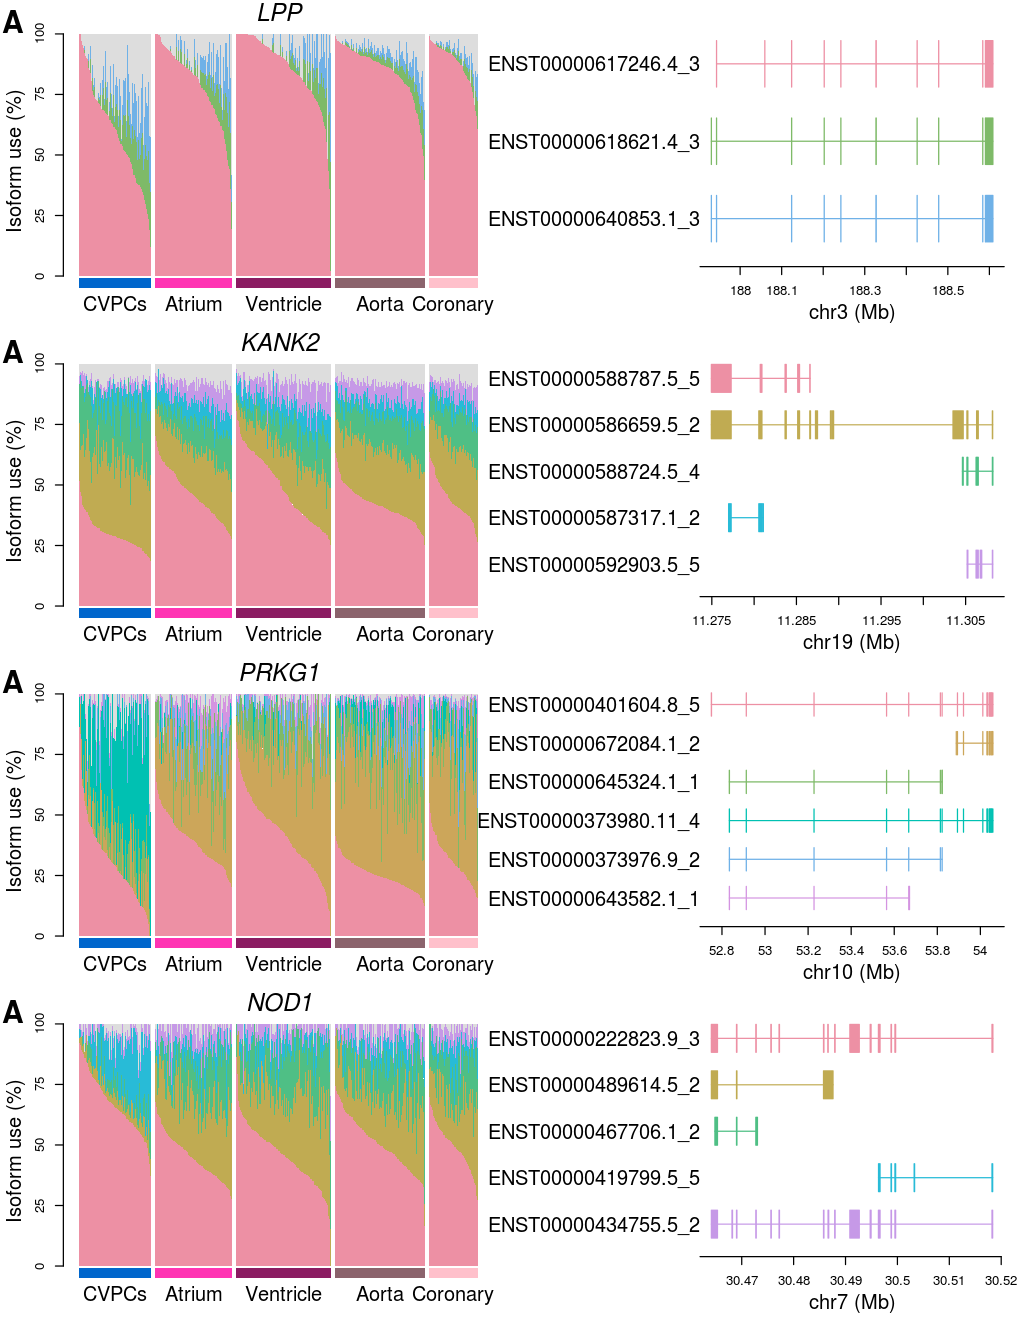

In [1139]:
options(repr.plot.width = 8.5, repr.plot.height = 11)
layout(matrix(1:8, nrow = 4, byrow = TRUE))
figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "LPP"  , "gene_id"], "A")
figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "KANK2", "gene_id"], "A")
figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "PRKG1", "gene_id"], "A")
figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "NOD1" , "gene_id"], "A")


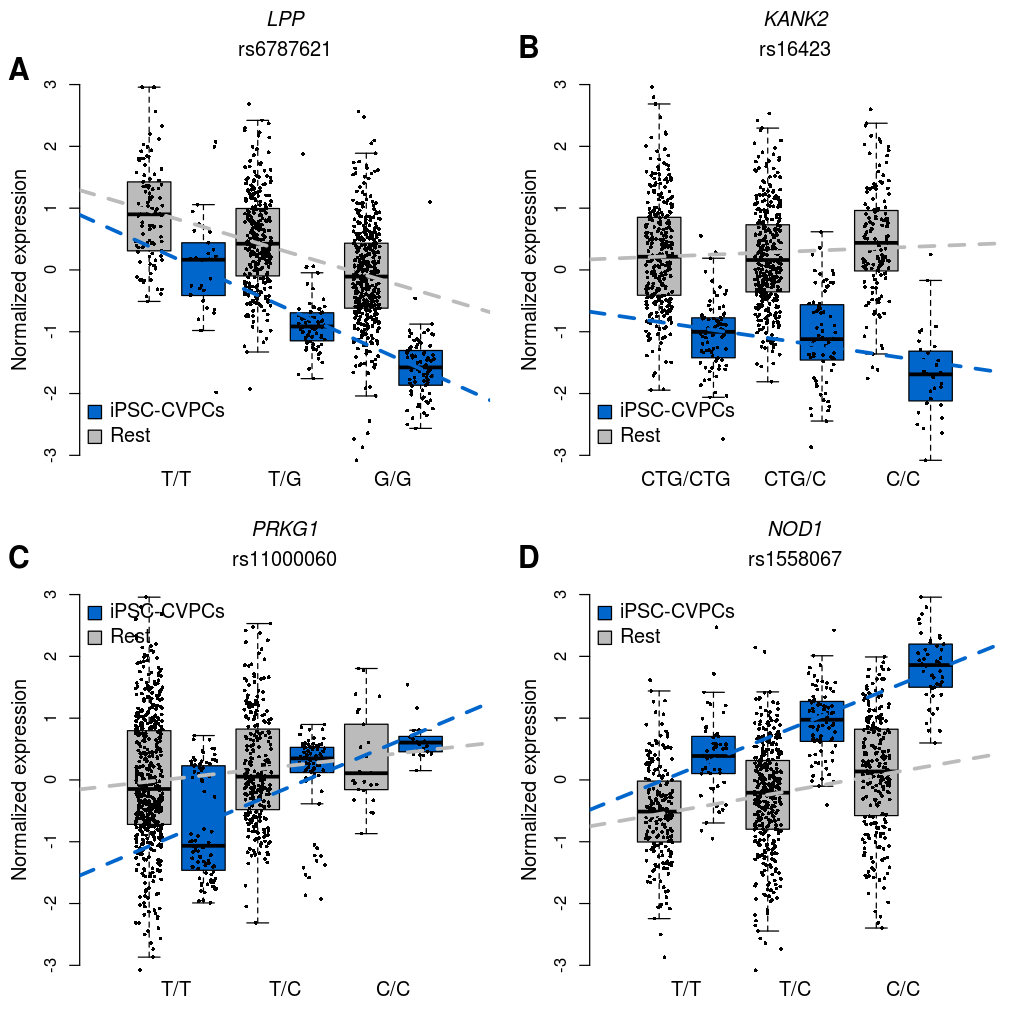

In [1145]:
options(repr.plot.width = 8.5, repr.plot.height = 8.5)
layout(matrix(1:4, nrow = 2, byrow = TRUE))

plot_celltype_numeric ("ENST00000617246.4_3" , "use_isoform", "VAR_3_188066953_T_G"  , "ipsc_cvpc", covariates, metadata, eqtl_isoforms, tissue2color3, TRUE, "A")
plot_celltype_numeric ("ENST00000588787.5_5" , "use_isoform", "VAR_19_11275811_CTG_C", "ipsc_cvpc", covariates, metadata, eqtl_isoforms, tissue2color3, TRUE, "B")
plot_celltype_numeric ("ENST00000643582.1_1" , "use_isoform", "VAR_10_53668890_T_C"  , "ipsc_cvpc", covariates, metadata, eqtl_isoforms, tissue2color3, TRUE, "C")
plot_celltype_numeric ("ENST00000222823.9_3" , "use_isoform", "VAR_7_30503280_T_C"   , "ipsc_cvpc", covariates, metadata, eqtl_isoforms, tissue2color3, TRUE, "D")



### Good examples:
- MECR: mitochondrion
- MRPL20-AS1
- SLC35E2A
- SLC25A34
- PLK3
- ODF2L
- GSTM4
- RAP1A: calcium, a lot of data
- MUC1: calcium
- S100A13: calcium
- KIAA0040: systolic (eGene) and diastolic (eIsoforms) blood pressure
- RRP15
- VCL: QRS
- ZMIZ1: cholesterol, androgen receptor
- BTAF1: TF, pulse pressure
- R3HCC1L: pulse pressure
- CD151: BMI
- TSPAN4: Calcium, BMI
- EIF3F: AFIB
- DENND2B: cytoskeleton, blood pressure
- SWAP70: hypertension
- HES4: TF, HDL
- NUCB2: blood pressure
- TRPT1: BMI and heart rate
- SRSF8: RBP, MI
- BRAF: pulse rate (not isoform vs. eGene)
- MIIP: Calcium

### RBPs identified by Tim
- HNRNPL: differentially expressed between fetal and adult, eQTLs (gene = LDL, transcript = calcium, weak); no eQTL associations with stage or cell. It regulated TNF-alpha (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3903238/). TNF-α inhibitor treatment was associated with a significant increase in total cholesterol and triglycerides levels and the atherogenic index (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5103435/). 
- HNRNPA1
- HNRNPA2B1
- FUS
- RSF1: eQTL only for isoform, very weak colocalization with obesity
- RBM45
- RBM24
- RBM5: eQTL only for isoforms, colocalize with obesity and cholesterol. Known GWAS locus for HDL. Regulates genes involved in cholesterol homeostasis (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5133678/).
- PCB3
- SRSF7
- FMR1
- YBX1
- FXR2
- PPRC1
- RBM8A
- HNRNPA1L2
- ZC3H10

### TFs identified by Jennifer (fetal-specific)
- MEF2C: eQTL only for eGene
- ATF1: two gene eQTLs, weak colocalization with HDL. Evidence of association with cholesterol: https://pubmed.ncbi.nlm.nih.gov/24051143/
- MEF2D
- RUNX3
- RARG
- NFKB1

### TFs identified by Jennifer (adult-specific)
- ZBTB14
- IKZF1
- ZNF331
- FOSL1
- FOS
- FOSL2
- JUNB
- JUND: strong colocalization between isoform eQTLs and triglycerides; other isoform eQTLs colocalize with varicose veins. Associated with obesity-induced Metabolic cardiomyopathy (MC). Obese mice lacking JunD were protected against MC. Cardiac-specific overexpression of JunD in lean mice led to PPARγ activation, cardiac steatosis, and dysfunction, thereby mimicking the MC phenotype (https://academic.oup.com/eurheartj/article/40/12/997/5281245)
- KLF4: eQTL but nothing else
- EBF1
- SP2
- JUN
- NKX2-5
- TBX3
- AHR
- SNAI2

### TFs identified by Jennifer (all)

- TFAP4
- ZNF384
- STAT3
- SOX5
- STAT6
- BCL6
- NR2C2
- ATF2
- FOXO4
- ZNF331
- TAL1
- GATA3
- NFATC2
- GATA2
- E2F5
- FOXO1
- FOXK1: eQTL associated with smooth muscle
- TBP
- FOXJ2
- GATA6
- TGIF1
- ESR1
- NKX3-1
- SMAD3: eIsoform associated with obesity, QRS duration and calcium (no eGenes). eIsoforms is expressed at higher levels in the adult and is fibroblast-specific. Smad3 Deficiency in Mice Protects Against Insulin Resistance and Obesity Induced by a High-Fat Diet (https://diabetes.diabetesjournals.org/content/60/2/464). Smad proteins differentially regulate obesity-induced glucose and lipid abnormalities and inflammation via class-specific control of AMPK-related kinase MPK38/MELK activity (https://www.nature.com/articles/s41419-018-0489-x). Protection from obesity and diabetes by blockade of TGF-β/Smad3 signaling (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3169298/). https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3341711/. Also involved in fibrosis and post-MI heart remodeling (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5637726/). Everything seems to tie well together: differential expression, cell type-specificity and colocalization. It just misses some cell type or stage association for the eQTLs.
- FOXO3
- STAT1
- RARG
- STAT5A
- GATA4
- RUNX1
- ZNF143
- HIC1
- NKX2.5
- TBX3
- ZSCAN31
- FOXP2
- FOSL2
- EBF1
- ATF3
- FOSL1
- REL
- ZBTB14
- EPAS1
- ZFX
- CREM
- ZBTB7A
- IKZF1
- MBD2
- NFATC3
- FOXP1
- NFATC4
- PRDM1
- STAT4
- NFKB1
- IRF9
- KLF8
- USF1
- JUND
- ZNF8
- COT1
- MEF2A
- MEIS2
- FOXH1
- FOXM1
- FOSB
- LYL1
- ZEB1
- CREB1


### iPSC-CVPC-specific eIsoforms that colocalize with GWAS, but their associated eGene does not: HES4; ADAM15; TOR1AIP1; LGALS8; PRKG1; MXI1; DKK3; GPR137; UCHL3; CIB1; MLST8; NOMO3; ATXN2L; CTDNEP1; AC005670.3; AP3D1; KANK2; DMPK; DIDO1; THOC5; STAB1; LPP; RPL9; CAST; HLA-F-AS1; HLA-C; AC147651.1; NOD1; PTP4A3
- ***LPP***: mechanosensitive protein regulated by nitric oxide in the heart ([PMC3642136](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3642136/)). ieQTLs are associated with blood pressure
- ***LGALS8*** (galectin-8): ([review of functions](https://jcs.biologists.org/content/joces/131/9/jcs208884.full.pdf)). ieQTLs are associated with pulse pressure but not gene eQTLs.
- ***PRKG1***: key mediator of the nitric oxide (NO)/cGMP signaling pathway (GeneCards). Recurrent Gain-of-Function Mutation in PRKG1 Causes Thoracic Aortic Aneurysms and Acute Aortic Dissections ([PMC3738837](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3738837/)). genetic variability in PRKG1 might affect left ventricular (LV) function and structure ([24060898](https://www.ahajournals.org/doi/pdf/10.1161/HYPERTENSIONAHA.113.01630)). ieQTLs are associated with blood pressure.
- ***MXI1***: transcriptional repressor thought to negatively regulate MYC function (GeneCards). MXI1-0, an Alternatively Transcribed Mxi1 Isoform, Is Overexpressed in Glioblastomas
 ([PMC1531670](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1531670/)). ieQTLs are associated with ischaemic heart disease and triglycerides.
- ***GPR137***: G protein coupled receptor. Has different isoforms with known functions during development ([25514843](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4337595/)). Its alternative splicing is associated with ESRP1 ([28975893](https://elifesciences.org/articles/28366)) ieQTLs only are associated with heart failure. 
- ***KANK2***: Involved in actin stress fibers formation(GeneCards). Associated with response to MI ([32570033](https://europepmc.org/article/med/32570033)). Involved in focal adhesion (https://www.nature.com/articles/ncb3402). ieQTLs are associated with HDL cholesterol; Pulse rate, automated reading
- ***NOD1***: NOD1 Activation Induces Cardiac Dysfunction and Modulates Cardiac Fibrosis and Cardiomyocyte Apoptosis ([23028889](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3445482/)). Deficiency of NOD1 Improves the β-Adrenergic Modulation of Ca2+ Handling in a Mouse Model of Heart Failure ([29962957](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6010671/)). ieQTLs only are associated with LDL levels, while gene eQTLs are associated with triglycerides (low PP)


### Adult-specific eIsoforms that colocalize with GWAS, but their associated eGene does not: PALMD; FMO2; B3GAT3; XRRA1; TMEM255B; MLH3; ATXN3; XRCC3; ICE2; HAGHL; EMP2; HP; RPL13; NUP88; GRAMD1A; PCAT19; AC073254.1; SERHL; FAM118A; TDGF1; PIGG; CRMP1; AC093752.1; NPR3; ITGA1; ATG10; MRNIP; HLA-C; NOTCH4; HLA-DQA1; HLA-DPB1; TMEM63B; AC147651.1; PRKRIP1; NMRK1
- ***PALMD*** (palmdelphin): susceptibility gene for calcific aortic valve stenosis ([29511167](https://www.nature.com/articles/s41467-018-03260-6)). ieQTL is associated with pulse rate, gene eQTL is associated with blood pressure
- ***HP*** (Haptoglobin): associated with MI risk ([19657769](https://pubmed.ncbi.nlm.nih.gov/19657769/)) and cardiac disease in diabetes ([PMC5019011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5019011/)). ieQTLs are associated with blood pressure, atherosclerosis, hypertension, pulse rate
- ***XRCC3***: DNA repair. Associated with increased carotid artery thickness upon exposure to ionizing radiations ([X](https://academic.oup.com/eurheartj/article/34/suppl_1/P3922/2862076)). XRCC3 polymorphism is associated with hypertension-induced left ventricular hypertrophy ([29626209](https://www.nature.com/articles/s41440-018-0038-0?platform=hootsuite)). Xrcc3 Induces Cisplatin Resistance by Stimulation of Rad51-Related Recombinational Repair, S-Phase Checkpoint Activation, and Reduced Apoptosis ([15843498](https://jpet.aspetjournals.org/content/314/2/495.abstract)). iEQTLs are associated with pulse rate, BMI, atrial fibrillation, heart failure and hypertension (gene eQTLs only with LDL levels).
- ***ATXN3***: . Splice Isoforms of the Polyglutamine Disease Protein Ataxin-3 Exhibit Similar Enzymatic yet Different Aggregation Properties ([21060878](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2965175/)). A knockin mouse model of spinocerebellar ataxia type 3 exhibits prominent aggregate pathology and aberrant splicing of the disease gene transcript ([25320121](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4321438/)). ieQTLs are associated with HDL levels and pulse rate (no associations for gene-level).
- ***NUP88***: nucleoporin complex. Other NUPs are associated with heart disease ([PMC5027676](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5027676/)). ieQTLs only are associated with LDL levels.
- ***USP34***: Acts as an activator of the Wnt signaling pathway downstream of the beta-catenin destruction complex by deubiquitinating and stabilizing AXIN1 and AXIN2, leading to promote nuclear accumulation of AXIN1 and AXIN2 and positively regulate beta-catenin (CTNBB1)-mediated transcription (GeneCards). Associated with CHD ([29555671](https://www.ahajournals.org/doi/full/10.1161/circgen.117.001978)). eQTLs are associated with blood pressure (systolic for Egenes, diastolic for eIsoforms).



In [725]:
message(paste('render_html("', geneinfo_genes[geneinfo_genes$gene_id %in% unlist(lapply(eg5, function(x){unlist(strsplit(x, " "))[[1]]})), "gene_name"], '")', sep = "", collapse = "\n"))

render_html("HES4")
render_html("SCNN1D")
render_html("INTS11")
render_html("CPTP")
render_html("CCNL2")
render_html("MRPL20-AS1")
render_html("ATAD3B")
render_html("SLC35E2B")
render_html("SLC35E2A")
render_html("PRDM16-DT")
render_html("CLCN6")
render_html("MIIP")
render_html("TMEM51")
render_html("SLC25A34")
render_html("ARHGEF19")
render_html("NBPF1")
render_html("CROCCP2")
render_html("HSPG2")
render_html("ZNF436-AS1")
render_html("DNALI1")
render_html("C1orf109")
render_html("TRIT1")
render_html("ZNF684")
render_html("PLK3")
render_html("SPATA6")
render_html("HHLA3")
render_html("CRYZ")
render_html("ACADM")
render_html("RABGGTB")
render_html("ODF2L")
render_html("LMO4")
render_html("RTCA")
render_html("GSTM4")
render_html("DRAM2")
render_html("RAP1A")
render_html("MOV10")
render_html("TSPAN2")
render_html("PTGFRN")
render_html("NUDT17")
render_html("MRPS21")
render_html("S100A13")
render_html("EFNA1")
render_html("MUC1")
render_html("CCT3")
render_html("IFI16")
render_html("FCGR2

In [881]:
manifest$category

[1] "ACE inhibitor,anti-hypertensive"                                                                                                                       
  [2] "angiotensin receptor blocker,ARB,anti-hypertensive"                                                                                                    
  [3] "circulatory system"                                                                                                                                    
  [4] "endocrine/metabolic"                                                                                                                                   
  [5] ""                                                                                                                                                      
  [6] ""                                                                                                                                                      
  [7] ""                                                                                                                                                      
  [8] ""                                                                                                                                                      
  [9] "selective beta1 antagonist,beta blocker"                                                                                                               
 [10] "UK Biobank Assessment Centre > Physical measures > ECG at rest, 12-lead"                                                                               
 [11] "UK Biobank Assessment Centre > Physical measures > ECG during exercise"                                                                                
 [12] "UK Biobank Assessment Centre > Physical measures > ECG during exercise"                                                                                
 [13] "UK Biobank Assessment Centre > Touchscreen > Health and medical history > Medical conditions"                                                          
 [14] "circulatory system"                                                                                                                                    
 [15] "endocrine/metabolic"                                                                                                                                   
 [16] "ACE inhibitor,anti-hypertensive"                                                                                                                       
 [17] "UK Biobank Assessment Centre > Touchscreen > Health and medical history > Medical conditions"                                                          
 [18] "UK Biobank Assessment Centre > Touchscreen > Health and medical history > Medical conditions"                                                          
 [19] "UK Biobank Assessment Centre > Touchscreen > Health and medical history > Medical conditions"                                                          
 [20] "UK Biobank Assessment Centre > Touchscreen > Health and medical history > Medication"                                                                  
 [21] "UK Biobank Assessment Centre > Touchscreen > Health and medical history > Medication"                                                                  
 [22] "UK Biobank Assessment Centre > Touchscreen > Health and medical history > Medication"                                                                  
 [23] "UK Biobank Assessment Centre > Touchscreen > Health and medical history > Medication"                                                                  
 [24] "NSAID,non-steroidal anti-inflammatory drug"                                                                                                            
 [25] "circulatory system"                                                                                                                                    
 [26] "UK Biobank Assessmen